# AHNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/AHNet.ipynb)

## Environment Set Up

### Requirements

In [ ]:
!pip install monai[einops]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2

### Colab Integration

In [ ]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ln -s /content/drive/MyDrive/TFM/data /content/data
!ln -s /content/drive/MyDrive/TFM/utils /content/utils
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

Mounted at /content/drive


### Imports

In [ ]:
# System
import os
import time

# Data Load & Visualization
import numpy as np
import pandas as pd

# Monai
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

# PyTorch
import torch
from torch.utils.data import SequentialSampler

# Utils
from utils.Models import AHNET
from utils.Transforms import Transforms
from utils.Plots import plot_gt_vs_pred
from utils.Datasets import UCSF_Dataset

### Config

In [ ]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [ ]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

In [ ]:
# Configs
%matplotlib inline
%load_ext cudf.pandas
pd.set_option("display.max_columns", None)

### User Configurations

In [ ]:
# Model Configurations
model_name = "AHNet"
model = AHNET
b_size = 1 # Batch Size
t_size = None # Training Subjects (None for all)
v_size = None # Validation Subjects (None for all)
spatial_size = (256, 256, 160)

# Training Configuration
init_epoch = 50 # 0 if new training
best_epoch = 50 # Load model if not training from epoch 0 - None if new training
max_epochs = 100
best_metric = -1
best_metric_epoch = -1
if best_epoch is not None:
    best_metric_epoch = best_epoch
    if os.path.exists(f"outputs/{model_name}/{model_name}_metrics.csv"):
       df = pd.read_csv(f"outputs/{model_name}/{model_name}_metrics.csv")
       best_metric = df.loc[df["epoch"] == best_epoch]["metric"].values[0]

## Load Data

In [ ]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100381A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,71.0,1.5,1.5,4.0,3082.045582,4.0,3082.045541,2445.030377,77.549672,770.511385,974.806455,4.146686e-05,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...
1,100414B,Female,Breast,GE 1.5 T Signa HDxt,0.59x0.59,512x512x50,No,52.0,1.5,3.0,5.0,84.446590,5.0,84.446586,22.656401,11.328201,16.889317,3.940386,3.629621e-06,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...
2,100132B,Male,Lung,GE 1.5 T Signa HDxt,0.5x0.5,512x512x156,No,55.0,1.5,1.2,5.0,734.400029,5.0,734.400029,236.700009,81.300003,146.880006,64.989060,1.136868e-13,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...
3,100212A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x98,No,52.0,1.5,1.5,9.0,208.062478,9.0,208.062474,43.260514,16.480196,23.118053,7.876000,3.481233e-06,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...
4,100243B,Female,Breast,GE 1.5 T Signa HDxt,0.86x0.86,256x256x100,No,55.0,1.5,1.5,6.0,517.367105,6.0,517.367098,173.932836,8.862820,86.227850,52.711028,6.960829e-06,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...


In [ ]:
transforms = Transforms(seed)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, transforms.val(), v_size)

# Samplers
train_sampler = SequentialSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=val_sampler)

## Training

### Parameters

In [ ]:
# Training
VAL_AMP = True
lr = 1e-4
weight_decay = 1e-5

# Report Frequency
plt_imgs = []
val_interval = 1
plot_interval = 1
best_metric_update = False
best_metric_update_epoch = best_epoch if best_epoch is not None else -1
max_step = len(train_dataset) // train_loader.batch_size - 1
max_val_step = len(val_dataset) // val_loader.batch_size - 3

# Metrics Storages
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

### Model, Loss, Optimizer & Inference

In [ ]:
# Model
model.to(device)

# Load model from file
if init_epoch is not None:
    if os.path.exists(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"):
        model.load_state_dict(torch.load(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"))

# Report File Headers
if init_epoch is None:
    with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
      f.write(f"epoch,metric,metric_tc,metric_wt,metric_et,train_loss,val_loss\n")

# Loss Function
loss_function = DiceLoss(smooth_nr=1e-5, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Training Process

----------
epoch 51/100
TRAIN
   Batch 1/248, train_loss: 0.3673, step time: 14.3501
   Batch 2/248, train_loss: 0.8478, step time: 1.0110
   Batch 3/248, train_loss: 0.5781, step time: 1.0232
   Batch 4/248, train_loss: 0.9951, step time: 1.0248
   Batch 5/248, train_loss: 0.4958, step time: 1.0311
   Batch 6/248, train_loss: 0.4747, step time: 1.0254
   Batch 7/248, train_loss: 0.3605, step time: 1.0113
   Batch 8/248, train_loss: 0.7081, step time: 1.0157
   Batch 9/248, train_loss: 0.3439, step time: 1.0151
   Batch 10/248, train_loss: 0.5188, step time: 1.0358
   Batch 11/248, train_loss: 0.3896, step time: 1.0213
   Batch 12/248, train_loss: 0.5429, step time: 0.9962
   Batch 13/248, train_loss: 0.5180, step time: 1.0301
   Batch 14/248, train_loss: 0.3368, step time: 1.0202
   Batch 15/248, train_loss: 0.5459, step time: 1.0332
   Batch 16/248, train_loss: 0.4289, step time: 1.0126
   Batch 17/248, train_loss: 0.4951, step time: 1.0350
   Batch 18/248, train_loss: 0.5411, step t

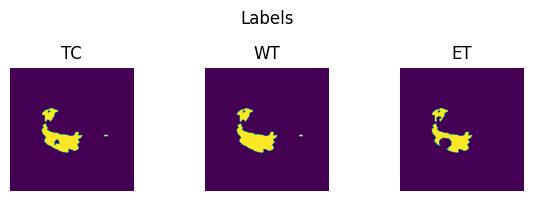

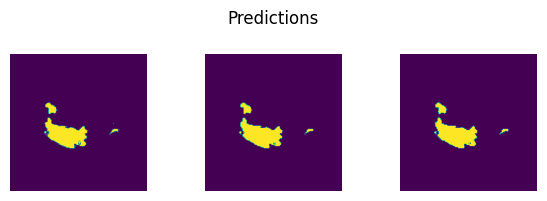

VAL
   Batch 1/31, val_loss: 0.6944
   Batch 2/31, val_loss: 0.7791
   Batch 3/31, val_loss: 0.7650
   Batch 4/31, val_loss: 0.7472
   Batch 5/31, val_loss: 0.7375
   Batch 6/31, val_loss: 0.5671
   Batch 7/31, val_loss: 0.6677
   Batch 8/31, val_loss: 0.7605
   Batch 9/31, val_loss: 0.5699
   Batch 10/31, val_loss: 0.7261
   Batch 11/31, val_loss: 0.6360
   Batch 12/31, val_loss: 0.7503
   Batch 13/31, val_loss: 0.7900
   Batch 14/31, val_loss: 0.7504
   Batch 15/31, val_loss: 0.7344
   Batch 16/31, val_loss: 0.7426
   Batch 17/31, val_loss: 0.7440
   Batch 18/31, val_loss: 0.7242
   Batch 19/31, val_loss: 0.6294
   Batch 20/31, val_loss: 0.6835
   Batch 21/31, val_loss: 0.7573
   Batch 22/31, val_loss: 0.7900
   Batch 23/31, val_loss: 0.7738
   Batch 24/31, val_loss: 0.6083
   Batch 25/31, val_loss: 0.6352
   Batch 26/31, val_loss: 0.7037
   Batch 27/31, val_loss: 0.7686
   Batch 28/31, val_loss: 0.6115
   Batch 29/31, val_loss: 0.7899
   Batch 30/31, val_loss: 0.7317
   Batch 31/31,

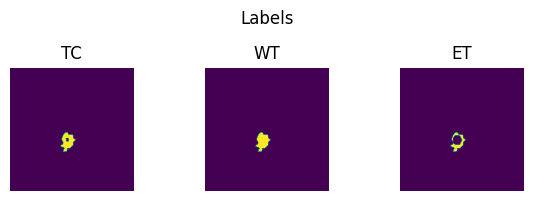

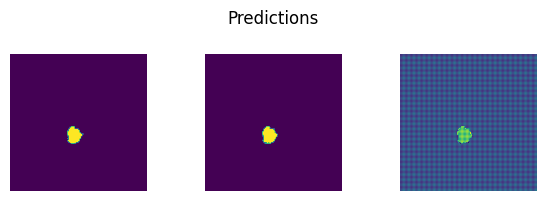

epoch 51
   average train loss: 0.4960
   average validation loss: 0.7133
   saved as best model: False
   current mean dice: 0.3850
   current TC dice: 0.5640
   current WT dice: 0.5607
   current ET dice: 0.0244
Best Mean Metric: 0.3886
time consuming of epoch 51 is: 3791.4095
----------
epoch 52/100
TRAIN
   Batch 1/248, train_loss: 0.3705, step time: 1.0396
   Batch 2/248, train_loss: 0.8846, step time: 1.0418
   Batch 3/248, train_loss: 0.5488, step time: 1.0406
   Batch 4/248, train_loss: 0.9785, step time: 1.0288
   Batch 5/248, train_loss: 0.4789, step time: 1.0357
   Batch 6/248, train_loss: 0.4612, step time: 1.0450
   Batch 7/248, train_loss: 0.3474, step time: 1.0480
   Batch 8/248, train_loss: 0.7106, step time: 1.0345
   Batch 9/248, train_loss: 0.3452, step time: 1.0480
   Batch 10/248, train_loss: 0.5212, step time: 1.0292
   Batch 11/248, train_loss: 0.3971, step time: 1.0327
   Batch 12/248, train_loss: 0.5343, step time: 1.0439
   Batch 13/248, train_loss: 0.5056, st

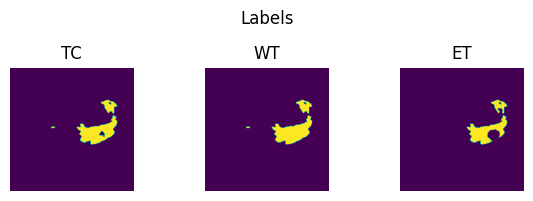

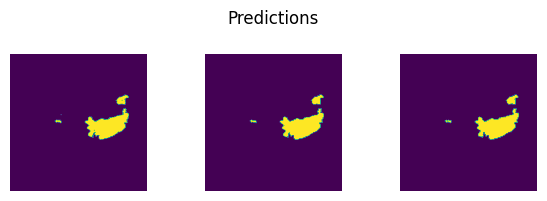

VAL
   Batch 1/31, val_loss: 0.7261
   Batch 2/31, val_loss: 0.7866
   Batch 3/31, val_loss: 0.7849
   Batch 4/31, val_loss: 0.7701
   Batch 5/31, val_loss: 0.7779
   Batch 6/31, val_loss: 0.5859
   Batch 7/31, val_loss: 0.6972
   Batch 8/31, val_loss: 0.7837
   Batch 9/31, val_loss: 0.5935
   Batch 10/31, val_loss: 0.7646
   Batch 11/31, val_loss: 0.6634
   Batch 12/31, val_loss: 0.7949
   Batch 13/31, val_loss: 0.8148
   Batch 14/31, val_loss: 0.7873
   Batch 15/31, val_loss: 0.7857
   Batch 16/31, val_loss: 0.7837
   Batch 17/31, val_loss: 0.7765
   Batch 18/31, val_loss: 0.7540
   Batch 19/31, val_loss: 0.6491
   Batch 20/31, val_loss: 0.7201
   Batch 21/31, val_loss: 0.7453
   Batch 22/31, val_loss: 0.8052
   Batch 23/31, val_loss: 0.8000
   Batch 24/31, val_loss: 0.6174
   Batch 25/31, val_loss: 0.6571
   Batch 26/31, val_loss: 0.7315
   Batch 27/31, val_loss: 0.7845
   Batch 28/31, val_loss: 0.6422
   Batch 29/31, val_loss: 0.8208
   Batch 30/31, val_loss: 0.7781
   Batch 31/31,

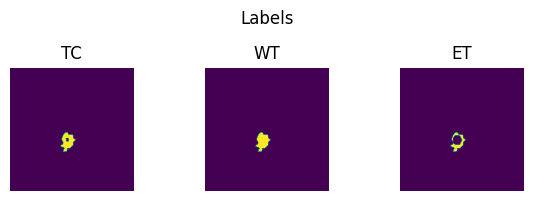

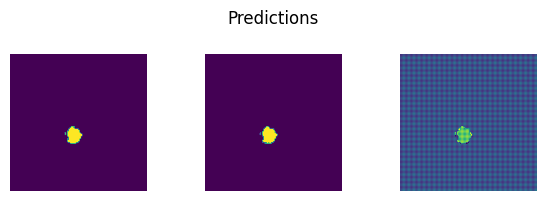

epoch 52
   average train loss: 0.5044
   average validation loss: 0.7403
   saved as best model: False
   current mean dice: 0.3605
   current TC dice: 0.5263
   current WT dice: 0.5292
   current ET dice: 0.0242
Best Mean Metric: 0.3886
time consuming of epoch 52 is: 1599.4205
----------
epoch 53/100
TRAIN
   Batch 1/248, train_loss: 0.3641, step time: 1.0340
   Batch 2/248, train_loss: 0.8126, step time: 1.0472
   Batch 3/248, train_loss: 0.5433, step time: 1.0385
   Batch 4/248, train_loss: 0.9980, step time: 1.0409
   Batch 5/248, train_loss: 0.4924, step time: 1.0259
   Batch 6/248, train_loss: 0.4204, step time: 1.0305
   Batch 7/248, train_loss: 0.3583, step time: 1.0470
   Batch 8/248, train_loss: 0.7852, step time: 1.0263
   Batch 9/248, train_loss: 0.3444, step time: 1.0215
   Batch 10/248, train_loss: 0.4970, step time: 1.0222
   Batch 11/248, train_loss: 0.3875, step time: 1.0358
   Batch 12/248, train_loss: 0.5173, step time: 1.0444
   Batch 13/248, train_loss: 0.6256, st

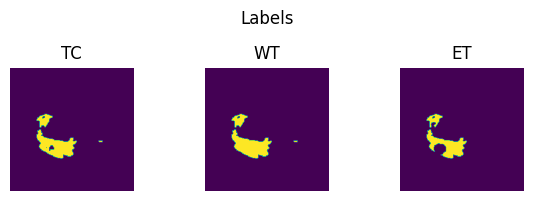

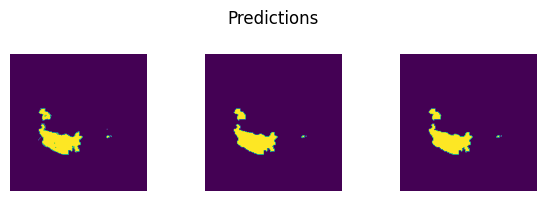

VAL
   Batch 1/31, val_loss: 0.6981
   Batch 2/31, val_loss: 0.7519
   Batch 3/31, val_loss: 0.8096
   Batch 4/31, val_loss: 0.7841
   Batch 5/31, val_loss: 0.7957
   Batch 6/31, val_loss: 0.5776
   Batch 7/31, val_loss: 0.6896
   Batch 8/31, val_loss: 0.8135
   Batch 9/31, val_loss: 0.5793
   Batch 10/31, val_loss: 0.7933
   Batch 11/31, val_loss: 0.6425
   Batch 12/31, val_loss: 0.7980
   Batch 13/31, val_loss: 0.8081
   Batch 14/31, val_loss: 0.7975
   Batch 15/31, val_loss: 0.8311
   Batch 16/31, val_loss: 0.7623
   Batch 17/31, val_loss: 0.8141
   Batch 18/31, val_loss: 0.7757
   Batch 19/31, val_loss: 0.6476
   Batch 20/31, val_loss: 0.7185
   Batch 21/31, val_loss: 0.7533
   Batch 22/31, val_loss: 0.8250
   Batch 23/31, val_loss: 0.8208
   Batch 24/31, val_loss: 0.6074
   Batch 25/31, val_loss: 0.6454
   Batch 26/31, val_loss: 0.7267
   Batch 27/31, val_loss: 0.8090
   Batch 28/31, val_loss: 0.6302
   Batch 29/31, val_loss: 0.8478
   Batch 30/31, val_loss: 0.7984
   Batch 31/31,

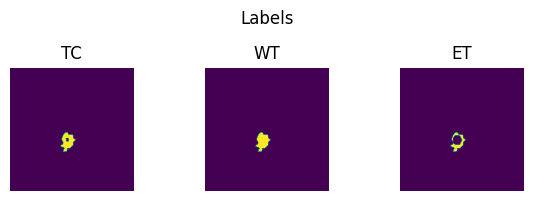

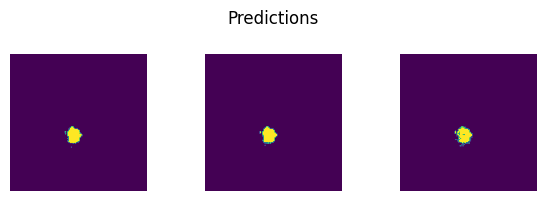

epoch 53
   average train loss: 0.4709
   average validation loss: 0.7468
   saved as best model: True
   current mean dice: 0.4980
   current TC dice: 0.5349
   current WT dice: 0.5364
   current ET dice: 0.4660
Best Mean Metric: 0.4980
time consuming of epoch 53 is: 1589.2099
----------
epoch 54/100
TRAIN
   Batch 1/248, train_loss: 0.0973, step time: 1.0327
   Batch 2/248, train_loss: 0.7584, step time: 1.0184
   Batch 3/248, train_loss: 0.4009, step time: 1.0269
   Batch 4/248, train_loss: 0.9981, step time: 1.0108
   Batch 5/248, train_loss: 0.2377, step time: 1.0231
   Batch 6/248, train_loss: 0.3750, step time: 1.0180
   Batch 7/248, train_loss: 0.1022, step time: 1.0170
   Batch 8/248, train_loss: 0.5726, step time: 1.0318
   Batch 9/248, train_loss: 0.0621, step time: 1.0217
   Batch 10/248, train_loss: 0.3680, step time: 1.0134
   Batch 11/248, train_loss: 0.3116, step time: 1.0072
   Batch 12/248, train_loss: 0.5640, step time: 1.0067
   Batch 13/248, train_loss: 0.3771, ste

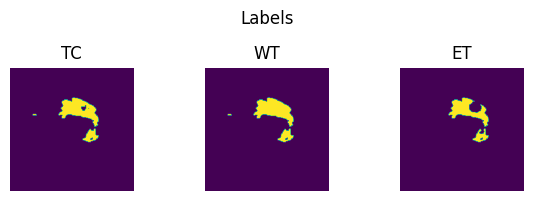

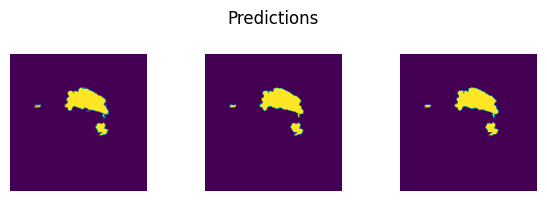

VAL
   Batch 1/31, val_loss: 0.7041
   Batch 2/31, val_loss: 0.7585
   Batch 3/31, val_loss: 0.8013
   Batch 4/31, val_loss: 0.7641
   Batch 5/31, val_loss: 0.7772
   Batch 6/31, val_loss: 0.5589
   Batch 7/31, val_loss: 0.6931
   Batch 8/31, val_loss: 0.7913
   Batch 9/31, val_loss: 0.5588
   Batch 10/31, val_loss: 0.7873
   Batch 11/31, val_loss: 0.6145
   Batch 12/31, val_loss: 0.7883
   Batch 13/31, val_loss: 0.7912
   Batch 14/31, val_loss: 0.7897
   Batch 15/31, val_loss: 0.7784
   Batch 16/31, val_loss: 0.7316
   Batch 17/31, val_loss: 0.7912
   Batch 18/31, val_loss: 0.7557
   Batch 19/31, val_loss: 0.6277
   Batch 20/31, val_loss: 0.7479
   Batch 21/31, val_loss: 0.7859
   Batch 22/31, val_loss: 0.8159
   Batch 23/31, val_loss: 0.7994
   Batch 24/31, val_loss: 0.5960
   Batch 25/31, val_loss: 0.6341
   Batch 26/31, val_loss: 0.6901
   Batch 27/31, val_loss: 0.7920
   Batch 28/31, val_loss: 0.6457
   Batch 29/31, val_loss: 0.8191
   Batch 30/31, val_loss: 0.7702
   Batch 31/31,

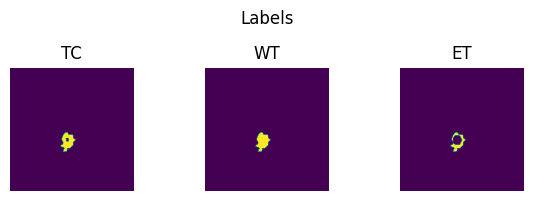

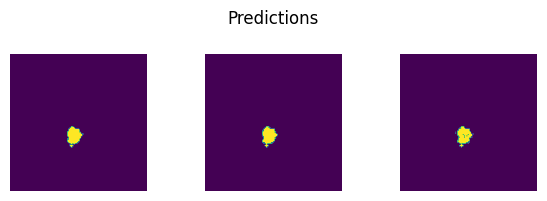

epoch 54
   average train loss: 0.3489
   average validation loss: 0.7334
   saved as best model: False
   current mean dice: 0.4914
   current TC dice: 0.5311
   current WT dice: 0.5296
   current ET dice: 0.4433
Best Mean Metric: 0.4980
time consuming of epoch 54 is: 1589.0679
----------
epoch 55/100
TRAIN
   Batch 1/248, train_loss: 0.1090, step time: 1.0129
   Batch 2/248, train_loss: 0.8021, step time: 1.0165
   Batch 3/248, train_loss: 0.4390, step time: 1.0305
   Batch 4/248, train_loss: 0.9978, step time: 0.9998
   Batch 5/248, train_loss: 0.2625, step time: 1.0057
   Batch 6/248, train_loss: 0.2469, step time: 1.0050
   Batch 7/248, train_loss: 0.1047, step time: 1.0081
   Batch 8/248, train_loss: 0.6754, step time: 1.0252
   Batch 9/248, train_loss: 0.0603, step time: 1.0238
   Batch 10/248, train_loss: 0.3031, step time: 1.0067
   Batch 11/248, train_loss: 0.3487, step time: 1.0187
   Batch 12/248, train_loss: 0.4041, step time: 1.0301
   Batch 13/248, train_loss: 0.3279, st

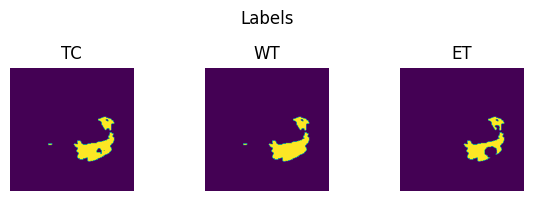

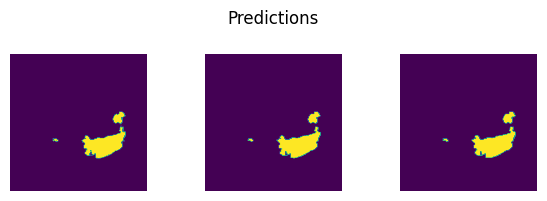

VAL
   Batch 1/31, val_loss: 0.7287
   Batch 2/31, val_loss: 0.7454
   Batch 3/31, val_loss: 0.8084
   Batch 4/31, val_loss: 0.8068
   Batch 5/31, val_loss: 0.7894
   Batch 6/31, val_loss: 0.5756
   Batch 7/31, val_loss: 0.7098
   Batch 8/31, val_loss: 0.8288
   Batch 9/31, val_loss: 0.5634
   Batch 10/31, val_loss: 0.7874
   Batch 11/31, val_loss: 0.6341
   Batch 12/31, val_loss: 0.8108
   Batch 13/31, val_loss: 0.7922
   Batch 14/31, val_loss: 0.8046
   Batch 15/31, val_loss: 0.8027
   Batch 16/31, val_loss: 0.7527
   Batch 17/31, val_loss: 0.8146
   Batch 18/31, val_loss: 0.7825
   Batch 19/31, val_loss: 0.6462
   Batch 20/31, val_loss: 0.7302
   Batch 21/31, val_loss: 0.8079
   Batch 22/31, val_loss: 0.8507
   Batch 23/31, val_loss: 0.8233
   Batch 24/31, val_loss: 0.6122
   Batch 25/31, val_loss: 0.6262
   Batch 26/31, val_loss: 0.6983
   Batch 27/31, val_loss: 0.8076
   Batch 28/31, val_loss: 0.6177
   Batch 29/31, val_loss: 0.8591
   Batch 30/31, val_loss: 0.8050
   Batch 31/31,

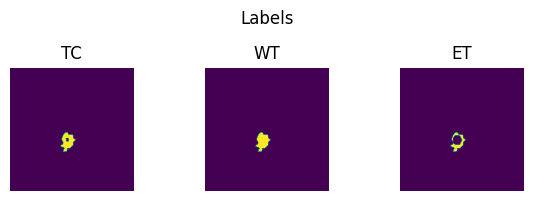

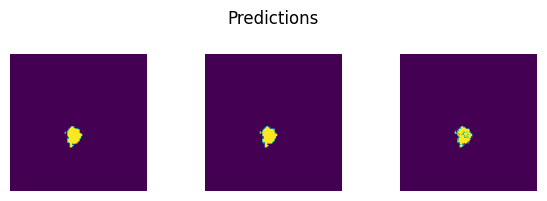

epoch 55
   average train loss: 0.3232
   average validation loss: 0.7491
   saved as best model: False
   current mean dice: 0.4964
   current TC dice: 0.5365
   current WT dice: 0.5357
   current ET dice: 0.4501
Best Mean Metric: 0.4980
time consuming of epoch 55 is: 1597.0483
----------
epoch 56/100
TRAIN
   Batch 1/248, train_loss: 0.0999, step time: 1.0217
   Batch 2/248, train_loss: 0.7197, step time: 1.0223
   Batch 3/248, train_loss: 0.4126, step time: 1.0181
   Batch 4/248, train_loss: 0.9961, step time: 1.0225
   Batch 5/248, train_loss: 0.2521, step time: 1.0365
   Batch 6/248, train_loss: 0.2652, step time: 1.0353
   Batch 7/248, train_loss: 0.0891, step time: 1.0145
   Batch 8/248, train_loss: 0.6560, step time: 1.0230
   Batch 9/248, train_loss: 0.0551, step time: 1.0265
   Batch 10/248, train_loss: 0.2904, step time: 1.0209
   Batch 11/248, train_loss: 0.2571, step time: 1.0306
   Batch 12/248, train_loss: 0.4679, step time: 1.0085
   Batch 13/248, train_loss: 0.3007, st

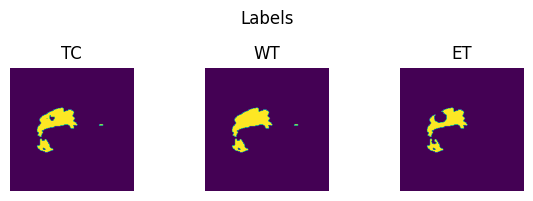

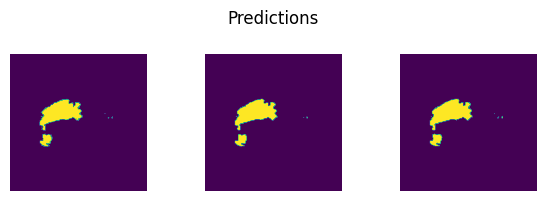

VAL
   Batch 1/31, val_loss: 0.7743
   Batch 2/31, val_loss: 0.7854
   Batch 3/31, val_loss: 0.8910
   Batch 4/31, val_loss: 0.8827
   Batch 5/31, val_loss: 0.8984
   Batch 6/31, val_loss: 0.6266
   Batch 7/31, val_loss: 0.7713
   Batch 8/31, val_loss: 0.9032
   Batch 9/31, val_loss: 0.6200
   Batch 10/31, val_loss: 0.8595
   Batch 11/31, val_loss: 0.6787
   Batch 12/31, val_loss: 0.8931
   Batch 13/31, val_loss: 0.8400
   Batch 14/31, val_loss: 0.8693
   Batch 15/31, val_loss: 0.9023
   Batch 16/31, val_loss: 0.8326
   Batch 17/31, val_loss: 0.8994
   Batch 18/31, val_loss: 0.8601
   Batch 19/31, val_loss: 0.6980
   Batch 20/31, val_loss: 0.7892
   Batch 21/31, val_loss: 0.8848
   Batch 22/31, val_loss: 0.9199
   Batch 23/31, val_loss: 0.8920
   Batch 24/31, val_loss: 0.6743
   Batch 25/31, val_loss: 0.6804
   Batch 26/31, val_loss: 0.7705
   Batch 27/31, val_loss: 0.9029
   Batch 28/31, val_loss: 0.6993
   Batch 29/31, val_loss: 0.9289
   Batch 30/31, val_loss: 0.8944
   Batch 31/31,

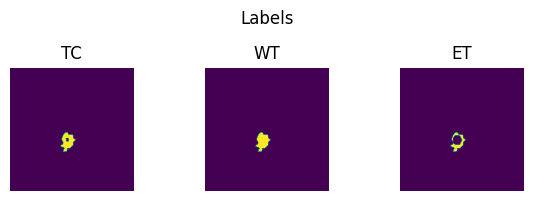

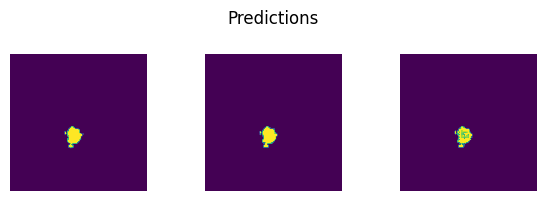

epoch 56
   average train loss: 0.3033
   average validation loss: 0.8198
   saved as best model: True
   current mean dice: 0.5122
   current TC dice: 0.5566
   current WT dice: 0.5539
   current ET dice: 0.4636
Best Mean Metric: 0.5122
time consuming of epoch 56 is: 1573.6946
----------
epoch 57/100
TRAIN
   Batch 1/248, train_loss: 0.0890, step time: 1.0260
   Batch 2/248, train_loss: 0.7650, step time: 1.0359
   Batch 3/248, train_loss: 0.3512, step time: 1.0194
   Batch 4/248, train_loss: 0.9848, step time: 1.0369
   Batch 5/248, train_loss: 0.2137, step time: 1.0268
   Batch 6/248, train_loss: 0.3108, step time: 1.0241
   Batch 7/248, train_loss: 0.0943, step time: 1.0117
   Batch 8/248, train_loss: 0.6398, step time: 1.0060
   Batch 9/248, train_loss: 0.0526, step time: 1.0045
   Batch 10/248, train_loss: 0.2995, step time: 1.0183
   Batch 11/248, train_loss: 0.2882, step time: 1.0354
   Batch 12/248, train_loss: 0.4212, step time: 1.0359
   Batch 13/248, train_loss: 0.3315, ste

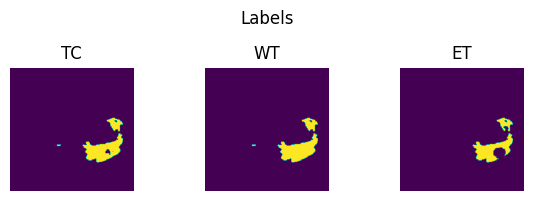

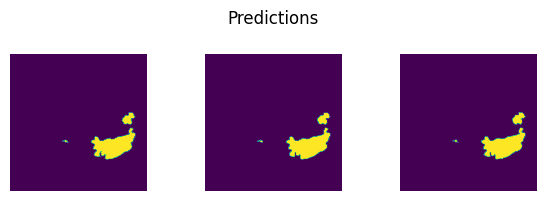

VAL
   Batch 1/31, val_loss: 0.7980
   Batch 2/31, val_loss: 0.8533
   Batch 3/31, val_loss: 0.8973
   Batch 4/31, val_loss: 0.8825
   Batch 5/31, val_loss: 0.8992
   Batch 6/31, val_loss: 0.6347
   Batch 7/31, val_loss: 0.7741
   Batch 8/31, val_loss: 0.9179
   Batch 9/31, val_loss: 0.6299
   Batch 10/31, val_loss: 0.8605
   Batch 11/31, val_loss: 0.7197
   Batch 12/31, val_loss: 0.8954
   Batch 13/31, val_loss: 0.8777
   Batch 14/31, val_loss: 0.8779
   Batch 15/31, val_loss: 0.9007
   Batch 16/31, val_loss: 0.8696
   Batch 17/31, val_loss: 0.9020
   Batch 18/31, val_loss: 0.8718
   Batch 19/31, val_loss: 0.7070
   Batch 20/31, val_loss: 0.8063
   Batch 21/31, val_loss: 0.8844
   Batch 22/31, val_loss: 0.9239
   Batch 23/31, val_loss: 0.8990
   Batch 24/31, val_loss: 0.6684
   Batch 25/31, val_loss: 0.7198
   Batch 26/31, val_loss: 0.8166
   Batch 27/31, val_loss: 0.9118
   Batch 28/31, val_loss: 0.6916
   Batch 29/31, val_loss: 0.9313
   Batch 30/31, val_loss: 0.8972
   Batch 31/31,

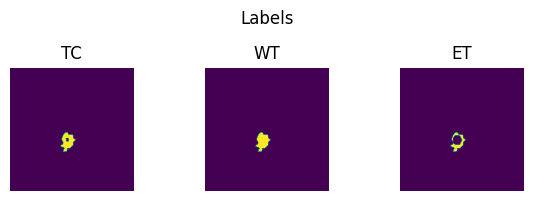

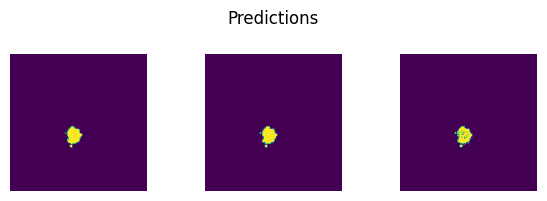

epoch 57
   average train loss: 0.3019
   average validation loss: 0.8328
   saved as best model: False
   current mean dice: 0.5032
   current TC dice: 0.5465
   current WT dice: 0.5443
   current ET dice: 0.4530
Best Mean Metric: 0.5122
time consuming of epoch 57 is: 1597.5667
----------
epoch 58/100
TRAIN
   Batch 1/248, train_loss: 0.0890, step time: 1.0245
   Batch 2/248, train_loss: 0.7465, step time: 1.0427
   Batch 3/248, train_loss: 0.3932, step time: 1.0245
   Batch 4/248, train_loss: 0.9944, step time: 1.0282
   Batch 5/248, train_loss: 0.2319, step time: 1.0436
   Batch 6/248, train_loss: 0.2377, step time: 1.0377
   Batch 7/248, train_loss: 0.0853, step time: 1.0192
   Batch 8/248, train_loss: 0.6442, step time: 1.0513
   Batch 9/248, train_loss: 0.0539, step time: 1.0267
   Batch 10/248, train_loss: 0.3029, step time: 1.0313
   Batch 11/248, train_loss: 0.2522, step time: 1.0256
   Batch 12/248, train_loss: 0.4100, step time: 1.0422
   Batch 13/248, train_loss: 0.3030, st

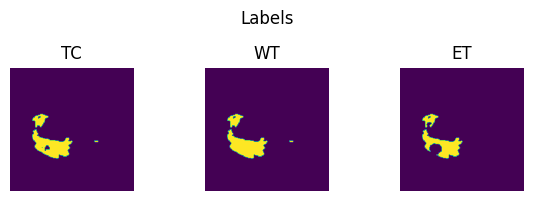

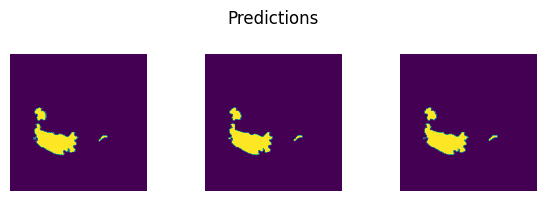

VAL
   Batch 1/31, val_loss: 0.8147
   Batch 2/31, val_loss: 0.9208
   Batch 3/31, val_loss: 0.9062
   Batch 4/31, val_loss: 0.8972
   Batch 5/31, val_loss: 0.9164
   Batch 6/31, val_loss: 0.6339
   Batch 7/31, val_loss: 0.7823
   Batch 8/31, val_loss: 0.9133
   Batch 9/31, val_loss: 0.6332
   Batch 10/31, val_loss: 0.8644
   Batch 11/31, val_loss: 0.7556
   Batch 12/31, val_loss: 0.9054
   Batch 13/31, val_loss: 0.9048
   Batch 14/31, val_loss: 0.8796
   Batch 15/31, val_loss: 0.9267
   Batch 16/31, val_loss: 0.9062
   Batch 17/31, val_loss: 0.9078
   Batch 18/31, val_loss: 0.8780
   Batch 19/31, val_loss: 0.7094
   Batch 20/31, val_loss: 0.8093
   Batch 21/31, val_loss: 0.8872
   Batch 22/31, val_loss: 0.9251
   Batch 23/31, val_loss: 0.9136
   Batch 24/31, val_loss: 0.6874
   Batch 25/31, val_loss: 0.7492
   Batch 26/31, val_loss: 0.8608
   Batch 27/31, val_loss: 0.9231
   Batch 28/31, val_loss: 0.6981
   Batch 29/31, val_loss: 0.9411
   Batch 30/31, val_loss: 0.8956
   Batch 31/31,

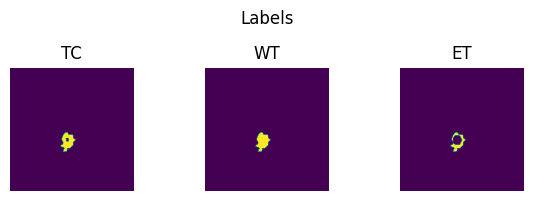

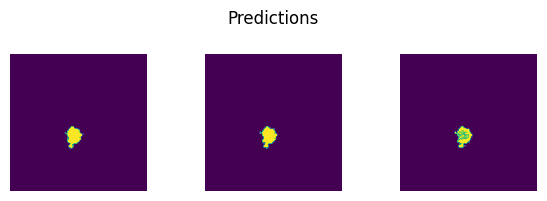

epoch 58
   average train loss: 0.3116
   average validation loss: 0.8469
   saved as best model: False
   current mean dice: 0.5035
   current TC dice: 0.5397
   current WT dice: 0.5406
   current ET dice: 0.4736
Best Mean Metric: 0.5122
time consuming of epoch 58 is: 1613.9302
----------
epoch 59/100
TRAIN
   Batch 1/248, train_loss: 0.0906, step time: 1.0523
   Batch 2/248, train_loss: 0.7838, step time: 1.0308
   Batch 3/248, train_loss: 0.3793, step time: 1.0390
   Batch 4/248, train_loss: 0.9972, step time: 1.0284
   Batch 5/248, train_loss: 0.2437, step time: 1.0407
   Batch 6/248, train_loss: 0.2842, step time: 1.0263
   Batch 7/248, train_loss: 0.0801, step time: 1.0243
   Batch 8/248, train_loss: 0.7318, step time: 1.0496
   Batch 9/248, train_loss: 0.0529, step time: 1.0353
   Batch 10/248, train_loss: 0.3050, step time: 1.0236
   Batch 11/248, train_loss: 0.2444, step time: 1.0392
   Batch 12/248, train_loss: 0.3644, step time: 1.0440
   Batch 13/248, train_loss: 0.3220, st

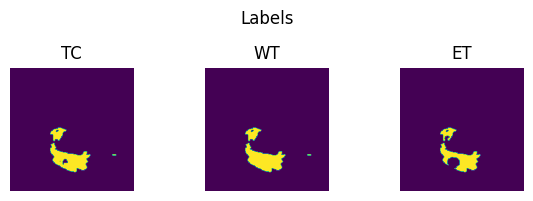

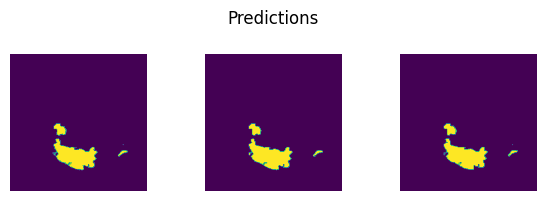

VAL
   Batch 1/31, val_loss: 0.8247
   Batch 2/31, val_loss: 0.9609
   Batch 3/31, val_loss: 0.9546
   Batch 4/31, val_loss: 0.9373
   Batch 5/31, val_loss: 0.9744
   Batch 6/31, val_loss: 0.6772
   Batch 7/31, val_loss: 0.8188
   Batch 8/31, val_loss: 0.9542
   Batch 9/31, val_loss: 0.6831
   Batch 10/31, val_loss: 0.9434
   Batch 11/31, val_loss: 0.7958
   Batch 12/31, val_loss: 0.9534
   Batch 13/31, val_loss: 0.9440
   Batch 14/31, val_loss: 0.9269
   Batch 15/31, val_loss: 0.9772
   Batch 16/31, val_loss: 0.9448
   Batch 17/31, val_loss: 0.9498
   Batch 18/31, val_loss: 0.9216
   Batch 19/31, val_loss: 0.7508
   Batch 20/31, val_loss: 0.8647
   Batch 21/31, val_loss: 0.9360
   Batch 22/31, val_loss: 0.9700
   Batch 23/31, val_loss: 0.9530
   Batch 24/31, val_loss: 0.7326
   Batch 25/31, val_loss: 0.7854
   Batch 26/31, val_loss: 0.9006
   Batch 27/31, val_loss: 0.9740
   Batch 28/31, val_loss: 0.7445
   Batch 29/31, val_loss: 0.9753
   Batch 30/31, val_loss: 0.9525
   Batch 31/31,

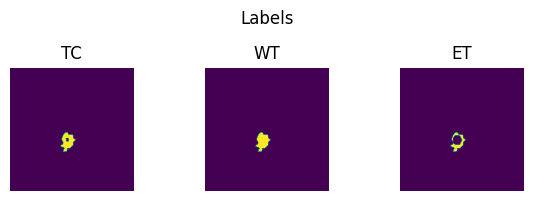

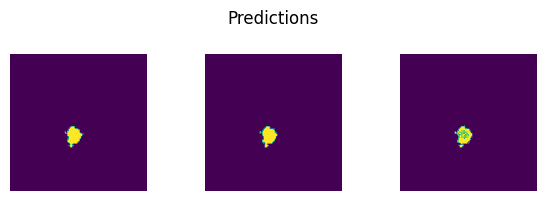

epoch 59
   average train loss: 0.2950
   average validation loss: 0.8915
   saved as best model: True
   current mean dice: 0.5242
   current TC dice: 0.5643
   current WT dice: 0.5637
   current ET dice: 0.4815
Best Mean Metric: 0.5242
time consuming of epoch 59 is: 1639.7257
----------
epoch 60/100
TRAIN
   Batch 1/248, train_loss: 0.0961, step time: 1.0442
   Batch 2/248, train_loss: 0.7652, step time: 1.0401
   Batch 3/248, train_loss: 0.3707, step time: 1.0338
   Batch 4/248, train_loss: 0.9909, step time: 1.0381
   Batch 5/248, train_loss: 0.2252, step time: 1.0521
   Batch 6/248, train_loss: 0.2307, step time: 1.0301
   Batch 7/248, train_loss: 0.0804, step time: 1.0401
   Batch 8/248, train_loss: 0.6032, step time: 1.0430
   Batch 9/248, train_loss: 0.0519, step time: 1.0225
   Batch 10/248, train_loss: 0.2912, step time: 1.0328
   Batch 11/248, train_loss: 0.2786, step time: 1.0479
   Batch 12/248, train_loss: 0.3649, step time: 1.0298
   Batch 13/248, train_loss: 0.2945, ste

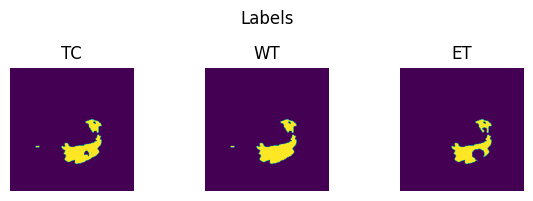

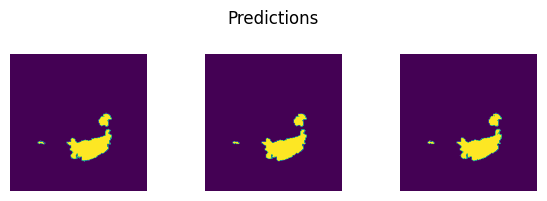

VAL
   Batch 1/31, val_loss: 0.8367
   Batch 2/31, val_loss: 0.9697
   Batch 3/31, val_loss: 0.9665
   Batch 4/31, val_loss: 0.9486
   Batch 5/31, val_loss: 0.9880
   Batch 6/31, val_loss: 0.6847
   Batch 7/31, val_loss: 0.8351
   Batch 8/31, val_loss: 0.9677
   Batch 9/31, val_loss: 0.6907
   Batch 10/31, val_loss: 0.9244
   Batch 11/31, val_loss: 0.8074
   Batch 12/31, val_loss: 0.9669
   Batch 13/31, val_loss: 0.9531
   Batch 14/31, val_loss: 0.9436
   Batch 15/31, val_loss: 0.9895
   Batch 16/31, val_loss: 0.9563
   Batch 17/31, val_loss: 0.9624
   Batch 18/31, val_loss: 0.9340
   Batch 19/31, val_loss: 0.7586
   Batch 20/31, val_loss: 0.8575
   Batch 21/31, val_loss: 0.9465
   Batch 22/31, val_loss: 0.9819
   Batch 23/31, val_loss: 0.9658
   Batch 24/31, val_loss: 0.7405
   Batch 25/31, val_loss: 0.7963
   Batch 26/31, val_loss: 0.9129
   Batch 27/31, val_loss: 0.9803
   Batch 28/31, val_loss: 0.7497
   Batch 29/31, val_loss: 0.9854
   Batch 30/31, val_loss: 0.9635
   Batch 31/31,

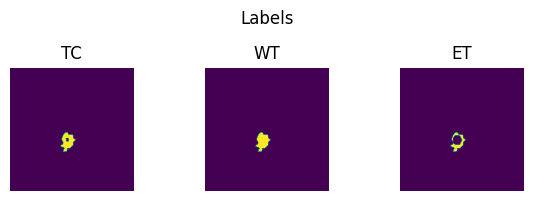

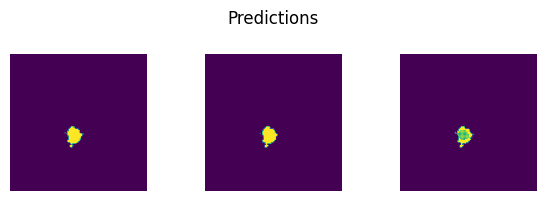

epoch 60
   average train loss: 0.2917
   average validation loss: 0.9010
   saved as best model: True
   current mean dice: 0.5257
   current TC dice: 0.5671
   current WT dice: 0.5672
   current ET dice: 0.4768
Best Mean Metric: 0.5257
time consuming of epoch 60 is: 1586.3241
----------
epoch 61/100
TRAIN
   Batch 1/248, train_loss: 0.0947, step time: 1.0448
   Batch 2/248, train_loss: 0.6854, step time: 1.0304
   Batch 3/248, train_loss: 0.3562, step time: 1.0266
   Batch 4/248, train_loss: 0.9977, step time: 1.0157
   Batch 5/248, train_loss: 0.2366, step time: 1.0426
   Batch 6/248, train_loss: 0.2361, step time: 1.0243
   Batch 7/248, train_loss: 0.0823, step time: 1.0387
   Batch 8/248, train_loss: 0.6961, step time: 1.0211
   Batch 9/248, train_loss: 0.0512, step time: 1.0235
   Batch 10/248, train_loss: 0.2821, step time: 1.0382
   Batch 11/248, train_loss: 0.2712, step time: 1.0258
   Batch 12/248, train_loss: 0.4054, step time: 1.0423
   Batch 13/248, train_loss: 0.3217, ste

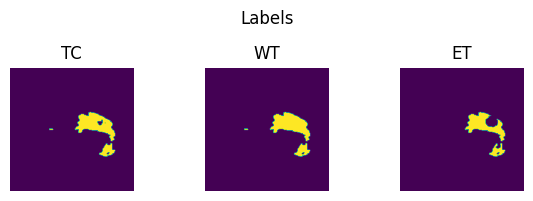

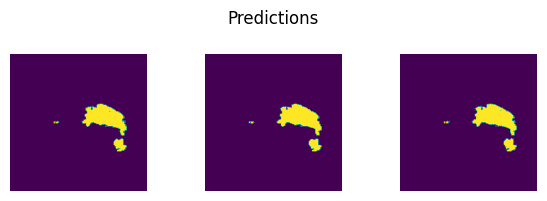

VAL
   Batch 1/31, val_loss: 0.8363
   Batch 2/31, val_loss: 0.9662
   Batch 3/31, val_loss: 0.9680
   Batch 4/31, val_loss: 0.9483
   Batch 5/31, val_loss: 0.9874
   Batch 6/31, val_loss: 0.6842
   Batch 7/31, val_loss: 0.8259
   Batch 8/31, val_loss: 0.9614
   Batch 9/31, val_loss: 0.6906
   Batch 10/31, val_loss: 0.9508
   Batch 11/31, val_loss: 0.8042
   Batch 12/31, val_loss: 0.9657
   Batch 13/31, val_loss: 0.9493
   Batch 14/31, val_loss: 0.9392
   Batch 15/31, val_loss: 0.9889
   Batch 16/31, val_loss: 0.9557
   Batch 17/31, val_loss: 0.9653
   Batch 18/31, val_loss: 0.9350
   Batch 19/31, val_loss: 0.7546
   Batch 20/31, val_loss: 0.8600
   Batch 21/31, val_loss: 0.9470
   Batch 22/31, val_loss: 0.9827
   Batch 23/31, val_loss: 0.9646
   Batch 24/31, val_loss: 0.7375
   Batch 25/31, val_loss: 0.7961
   Batch 26/31, val_loss: 0.9108
   Batch 27/31, val_loss: 0.9884
   Batch 28/31, val_loss: 0.7516
   Batch 29/31, val_loss: 0.9842
   Batch 30/31, val_loss: 0.9623
   Batch 31/31,

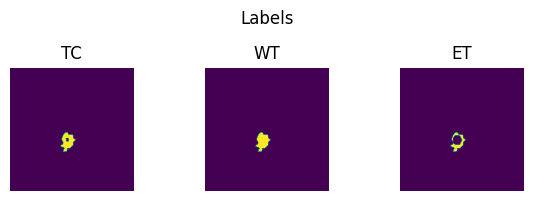

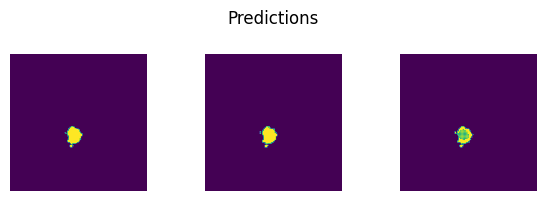

epoch 61
   average train loss: 0.2895
   average validation loss: 0.9009
   saved as best model: False
   current mean dice: 0.5248
   current TC dice: 0.5706
   current WT dice: 0.5682
   current ET dice: 0.4682
Best Mean Metric: 0.5257
time consuming of epoch 61 is: 1610.0901
----------
epoch 62/100
TRAIN
   Batch 1/248, train_loss: 0.0889, step time: 1.0319
   Batch 2/248, train_loss: 0.7445, step time: 1.0462
   Batch 3/248, train_loss: 0.3639, step time: 1.0474
   Batch 4/248, train_loss: 0.9935, step time: 1.0399
   Batch 5/248, train_loss: 0.2062, step time: 1.0336
   Batch 6/248, train_loss: 0.2121, step time: 1.0354
   Batch 7/248, train_loss: 0.0755, step time: 1.0235
   Batch 8/248, train_loss: 0.6642, step time: 1.0221
   Batch 9/248, train_loss: 0.0552, step time: 1.0358
   Batch 10/248, train_loss: 0.3070, step time: 1.0327
   Batch 11/248, train_loss: 0.2508, step time: 1.0376
   Batch 12/248, train_loss: 0.4369, step time: 1.0257
   Batch 13/248, train_loss: 0.3439, st

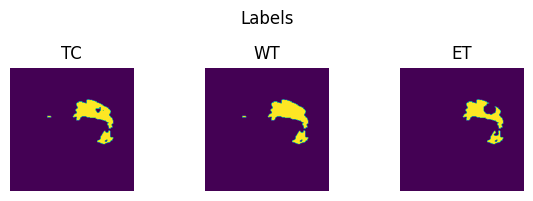

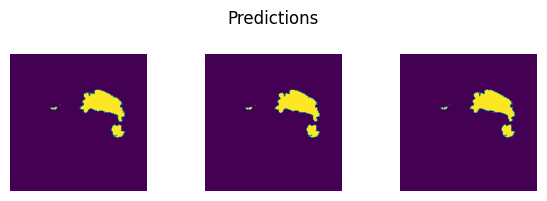

VAL
   Batch 1/31, val_loss: 0.8343
   Batch 2/31, val_loss: 0.9799
   Batch 3/31, val_loss: 0.9685
   Batch 4/31, val_loss: 0.9508
   Batch 5/31, val_loss: 0.9910
   Batch 6/31, val_loss: 0.6861
   Batch 7/31, val_loss: 0.8252
   Batch 8/31, val_loss: 0.9669
   Batch 9/31, val_loss: 0.6914
   Batch 10/31, val_loss: 0.9350
   Batch 11/31, val_loss: 0.8082
   Batch 12/31, val_loss: 0.9673
   Batch 13/31, val_loss: 0.9538
   Batch 14/31, val_loss: 0.9448
   Batch 15/31, val_loss: 0.9923
   Batch 16/31, val_loss: 0.9592
   Batch 17/31, val_loss: 0.9618
   Batch 18/31, val_loss: 0.9334
   Batch 19/31, val_loss: 0.7576
   Batch 20/31, val_loss: 0.8520
   Batch 21/31, val_loss: 0.9500
   Batch 22/31, val_loss: 0.9808
   Batch 23/31, val_loss: 0.9653
   Batch 24/31, val_loss: 0.7400
   Batch 25/31, val_loss: 0.7993
   Batch 26/31, val_loss: 0.9146
   Batch 27/31, val_loss: 0.9869
   Batch 28/31, val_loss: 0.7539
   Batch 29/31, val_loss: 0.9860
   Batch 30/31, val_loss: 0.9737
   Batch 31/31,

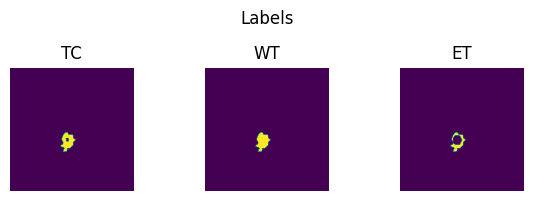

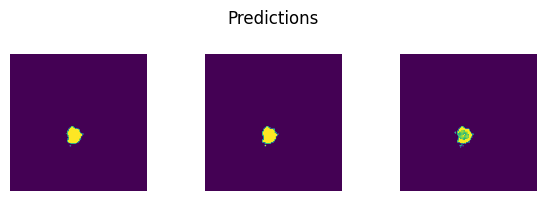

epoch 62
   average train loss: 0.2965
   average validation loss: 0.9025
   saved as best model: True
   current mean dice: 0.5336
   current TC dice: 0.5749
   current WT dice: 0.5740
   current ET dice: 0.4866
Best Mean Metric: 0.5336
time consuming of epoch 62 is: 1612.1345
----------
epoch 63/100
TRAIN
   Batch 1/248, train_loss: 0.1097, step time: 1.0375
   Batch 2/248, train_loss: 0.7277, step time: 1.0613
   Batch 3/248, train_loss: 0.3358, step time: 1.0444
   Batch 4/248, train_loss: 0.9973, step time: 1.0230
   Batch 5/248, train_loss: 0.2152, step time: 1.0366
   Batch 6/248, train_loss: 0.2126, step time: 1.0250
   Batch 7/248, train_loss: 0.0768, step time: 1.0446
   Batch 8/248, train_loss: 0.6123, step time: 1.0352
   Batch 9/248, train_loss: 0.0532, step time: 1.0361
   Batch 10/248, train_loss: 0.2889, step time: 1.0239
   Batch 11/248, train_loss: 0.2436, step time: 1.0262
   Batch 12/248, train_loss: 0.3694, step time: 1.0301
   Batch 13/248, train_loss: 0.2956, ste

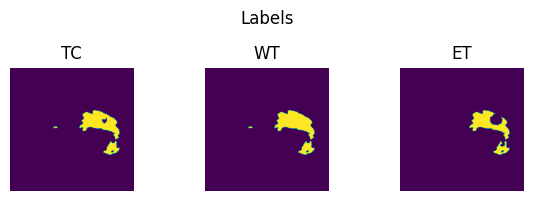

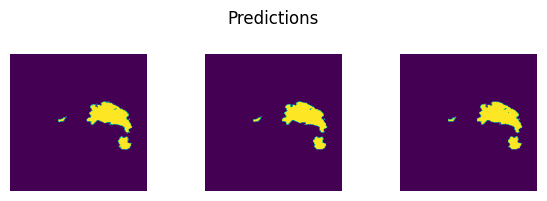

VAL
   Batch 1/31, val_loss: 0.8452
   Batch 2/31, val_loss: 0.9870
   Batch 3/31, val_loss: 0.9705
   Batch 4/31, val_loss: 0.9515
   Batch 5/31, val_loss: 0.9923
   Batch 6/31, val_loss: 0.6868
   Batch 7/31, val_loss: 0.8324
   Batch 8/31, val_loss: 0.9652
   Batch 9/31, val_loss: 0.6931
   Batch 10/31, val_loss: 0.9509
   Batch 11/31, val_loss: 0.8145
   Batch 12/31, val_loss: 0.9681
   Batch 13/31, val_loss: 0.9562
   Batch 14/31, val_loss: 0.9472
   Batch 15/31, val_loss: 0.9930
   Batch 16/31, val_loss: 0.9645
   Batch 17/31, val_loss: 0.9674
   Batch 18/31, val_loss: 0.9352
   Batch 19/31, val_loss: 0.7585
   Batch 20/31, val_loss: 0.8526
   Batch 21/31, val_loss: 0.9500
   Batch 22/31, val_loss: 0.9842
   Batch 23/31, val_loss: 0.9676
   Batch 24/31, val_loss: 0.7414
   Batch 25/31, val_loss: 0.8041
   Batch 26/31, val_loss: 0.9194
   Batch 27/31, val_loss: 0.9821
   Batch 28/31, val_loss: 0.7515
   Batch 29/31, val_loss: 0.9869
   Batch 30/31, val_loss: 0.9688
   Batch 31/31,

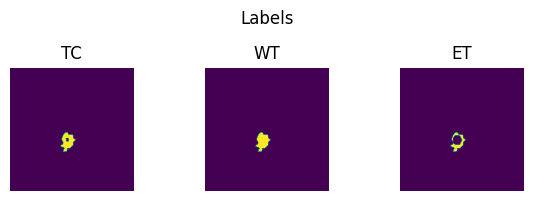

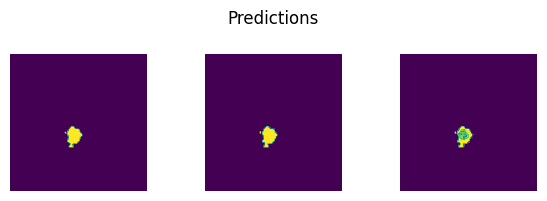

epoch 63
   average train loss: 0.2871
   average validation loss: 0.9051
   saved as best model: False
   current mean dice: 0.5328
   current TC dice: 0.5754
   current WT dice: 0.5755
   current ET dice: 0.4813
Best Mean Metric: 0.5336
time consuming of epoch 63 is: 1621.1411
----------
epoch 64/100
TRAIN
   Batch 1/248, train_loss: 0.0983, step time: 1.0528
   Batch 2/248, train_loss: 0.6112, step time: 1.0526
   Batch 3/248, train_loss: 0.3403, step time: 1.0289
   Batch 4/248, train_loss: 0.9378, step time: 1.0498
   Batch 5/248, train_loss: 0.2058, step time: 1.0511
   Batch 6/248, train_loss: 0.2006, step time: 1.0473
   Batch 7/248, train_loss: 0.0779, step time: 1.0405
   Batch 8/248, train_loss: 0.5683, step time: 1.0356
   Batch 9/248, train_loss: 0.0513, step time: 1.0263
   Batch 10/248, train_loss: 0.2854, step time: 1.0300
   Batch 11/248, train_loss: 0.2549, step time: 1.0486
   Batch 12/248, train_loss: 0.3881, step time: 1.0283
   Batch 13/248, train_loss: 0.2857, st

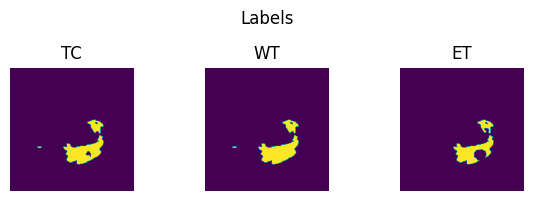

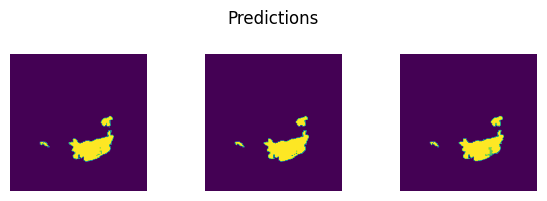

VAL
   Batch 1/31, val_loss: 0.8550
   Batch 2/31, val_loss: 0.9897
   Batch 3/31, val_loss: 0.9745
   Batch 4/31, val_loss: 0.9528
   Batch 5/31, val_loss: 0.9946
   Batch 6/31, val_loss: 0.6854
   Batch 7/31, val_loss: 0.8289
   Batch 8/31, val_loss: 0.9646
   Batch 9/31, val_loss: 0.6954
   Batch 10/31, val_loss: 0.9485
   Batch 11/31, val_loss: 0.8172
   Batch 12/31, val_loss: 0.9719
   Batch 13/31, val_loss: 0.9563
   Batch 14/31, val_loss: 0.9490
   Batch 15/31, val_loss: 0.9950
   Batch 16/31, val_loss: 0.9672
   Batch 17/31, val_loss: 0.9644
   Batch 18/31, val_loss: 0.9378
   Batch 19/31, val_loss: 0.7600
   Batch 20/31, val_loss: 0.8640
   Batch 21/31, val_loss: 0.9006
   Batch 22/31, val_loss: 0.9826
   Batch 23/31, val_loss: 0.9689
   Batch 24/31, val_loss: 0.7377
   Batch 25/31, val_loss: 0.8058
   Batch 26/31, val_loss: 0.9213
   Batch 27/31, val_loss: 0.9836
   Batch 28/31, val_loss: 0.7542
   Batch 29/31, val_loss: 0.9881
   Batch 30/31, val_loss: 0.9770
   Batch 31/31,

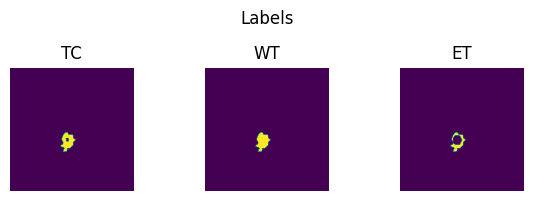

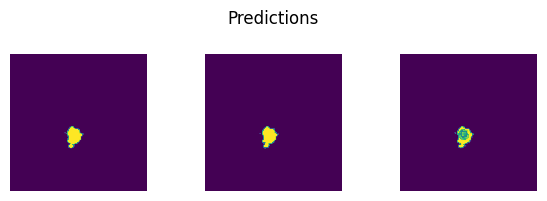

epoch 64
   average train loss: 0.2939
   average validation loss: 0.9052
   saved as best model: True
   current mean dice: 0.5343
   current TC dice: 0.5771
   current WT dice: 0.5779
   current ET dice: 0.4903
Best Mean Metric: 0.5343
time consuming of epoch 64 is: 1609.1059
----------
epoch 65/100
TRAIN
   Batch 1/248, train_loss: 0.0848, step time: 1.0252
   Batch 2/248, train_loss: 0.7846, step time: 1.0525
   Batch 3/248, train_loss: 0.3740, step time: 1.0474
   Batch 4/248, train_loss: 0.9991, step time: 1.0479
   Batch 5/248, train_loss: 0.2308, step time: 1.0334
   Batch 6/248, train_loss: 0.4638, step time: 1.0374
   Batch 7/248, train_loss: 0.0923, step time: 1.0464
   Batch 8/248, train_loss: 0.6349, step time: 1.0411
   Batch 9/248, train_loss: 0.0526, step time: 1.0239
   Batch 10/248, train_loss: 0.2781, step time: 1.0412
   Batch 11/248, train_loss: 0.2576, step time: 1.0492
   Batch 12/248, train_loss: 0.3948, step time: 1.0406
   Batch 13/248, train_loss: 0.3116, ste

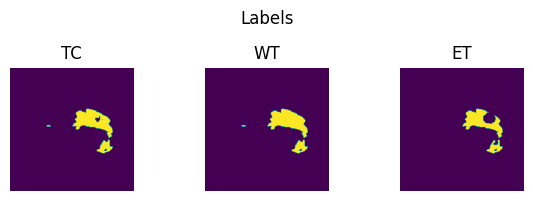

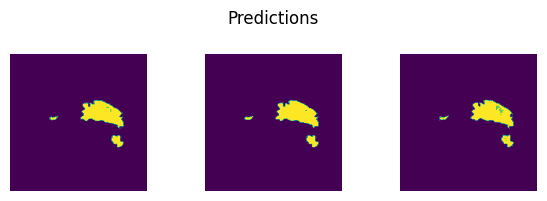

VAL
   Batch 1/31, val_loss: 0.8435
   Batch 2/31, val_loss: 0.9779
   Batch 3/31, val_loss: 0.9720
   Batch 4/31, val_loss: 0.9518
   Batch 5/31, val_loss: 0.9927
   Batch 6/31, val_loss: 0.6890
   Batch 7/31, val_loss: 0.8293
   Batch 8/31, val_loss: 0.9650
   Batch 9/31, val_loss: 0.6939
   Batch 10/31, val_loss: 0.9506
   Batch 11/31, val_loss: 0.8135
   Batch 12/31, val_loss: 0.9687
   Batch 13/31, val_loss: 0.9561
   Batch 14/31, val_loss: 0.9405
   Batch 15/31, val_loss: 0.9936
   Batch 16/31, val_loss: 0.9649
   Batch 17/31, val_loss: 0.9675
   Batch 18/31, val_loss: 0.9383
   Batch 19/31, val_loss: 0.7591
   Batch 20/31, val_loss: 0.8621
   Batch 21/31, val_loss: 0.9489
   Batch 22/31, val_loss: 0.9848
   Batch 23/31, val_loss: 0.9678
   Batch 24/31, val_loss: 0.7373
   Batch 25/31, val_loss: 0.8023
   Batch 26/31, val_loss: 0.9192
   Batch 27/31, val_loss: 0.9902
   Batch 28/31, val_loss: 0.7525
   Batch 29/31, val_loss: 0.9863
   Batch 30/31, val_loss: 0.9738
   Batch 31/31,

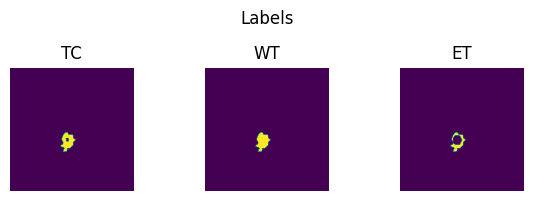

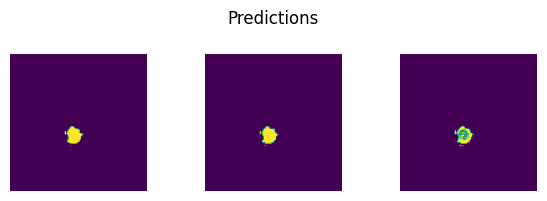

epoch 65
   average train loss: 0.2957
   average validation loss: 0.9053
   saved as best model: False
   current mean dice: 0.5114
   current TC dice: 0.5498
   current WT dice: 0.5492
   current ET dice: 0.4671
Best Mean Metric: 0.5343
time consuming of epoch 65 is: 1602.9937
----------
epoch 66/100
TRAIN
   Batch 1/248, train_loss: 0.0881, step time: 1.0443
   Batch 2/248, train_loss: 0.7030, step time: 1.0474
   Batch 3/248, train_loss: 0.3271, step time: 1.0263
   Batch 4/248, train_loss: 0.9661, step time: 1.0452
   Batch 5/248, train_loss: 0.1919, step time: 1.0407
   Batch 6/248, train_loss: 0.2338, step time: 1.0374
   Batch 7/248, train_loss: 0.0776, step time: 1.0523
   Batch 8/248, train_loss: 0.6877, step time: 1.0432
   Batch 9/248, train_loss: 0.0535, step time: 1.0321
   Batch 10/248, train_loss: 0.2704, step time: 1.0351
   Batch 11/248, train_loss: 0.2364, step time: 1.0276
   Batch 12/248, train_loss: 0.3711, step time: 1.0316
   Batch 13/248, train_loss: 0.2888, st

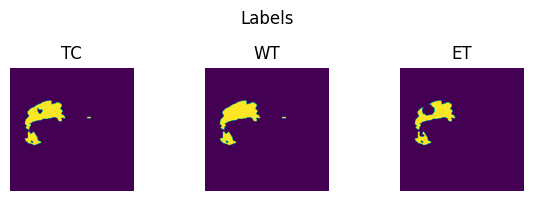

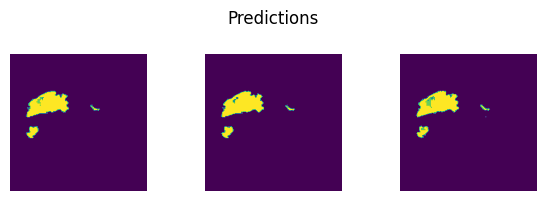

VAL
   Batch 1/31, val_loss: 0.8560
   Batch 2/31, val_loss: 0.9756
   Batch 3/31, val_loss: 0.9699
   Batch 4/31, val_loss: 0.9515
   Batch 5/31, val_loss: 0.9911
   Batch 6/31, val_loss: 0.6860
   Batch 7/31, val_loss: 0.8298
   Batch 8/31, val_loss: 0.9719
   Batch 9/31, val_loss: 0.6920
   Batch 10/31, val_loss: 0.9778
   Batch 11/31, val_loss: 0.8114
   Batch 12/31, val_loss: 0.9701
   Batch 13/31, val_loss: 0.9578
   Batch 14/31, val_loss: 0.9450
   Batch 15/31, val_loss: 0.9923
   Batch 16/31, val_loss: 0.9615
   Batch 17/31, val_loss: 0.9691
   Batch 18/31, val_loss: 0.9372
   Batch 19/31, val_loss: 0.7584
   Batch 20/31, val_loss: 0.8636
   Batch 21/31, val_loss: 0.9482
   Batch 22/31, val_loss: 0.9821
   Batch 23/31, val_loss: 0.9698
   Batch 24/31, val_loss: 0.7359
   Batch 25/31, val_loss: 0.8010
   Batch 26/31, val_loss: 0.9157
   Batch 27/31, val_loss: 0.9896
   Batch 28/31, val_loss: 0.7516
   Batch 29/31, val_loss: 0.9860
   Batch 30/31, val_loss: 0.9765
   Batch 31/31,

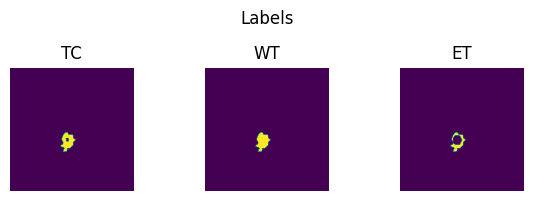

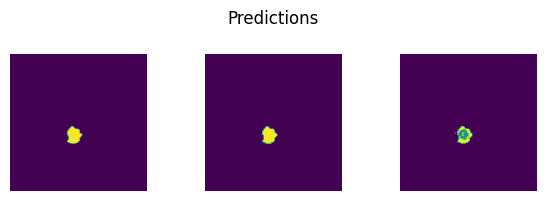

epoch 66
   average train loss: 0.2859
   average validation loss: 0.9063
   saved as best model: False
   current mean dice: 0.4869
   current TC dice: 0.5231
   current WT dice: 0.5216
   current ET dice: 0.4456
Best Mean Metric: 0.5343
time consuming of epoch 66 is: 1608.8683
----------
epoch 67/100
TRAIN
   Batch 1/248, train_loss: 0.0936, step time: 1.0451
   Batch 2/248, train_loss: 0.6984, step time: 1.0419
   Batch 3/248, train_loss: 0.4987, step time: 1.0221
   Batch 4/248, train_loss: 0.9610, step time: 1.0478
   Batch 5/248, train_loss: 0.2108, step time: 1.0504
   Batch 6/248, train_loss: 0.2183, step time: 1.0458
   Batch 7/248, train_loss: 0.0722, step time: 1.0439
   Batch 8/248, train_loss: 0.6912, step time: 1.0261
   Batch 9/248, train_loss: 0.0539, step time: 1.0364
   Batch 10/248, train_loss: 0.3469, step time: 1.0395
   Batch 11/248, train_loss: 0.2799, step time: 1.0457
   Batch 12/248, train_loss: 0.5283, step time: 1.0386
   Batch 13/248, train_loss: 0.4276, st

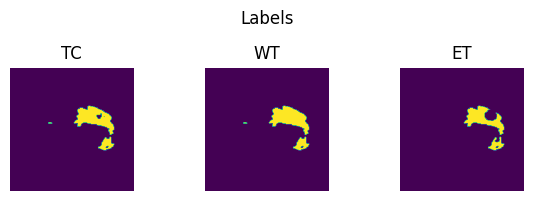

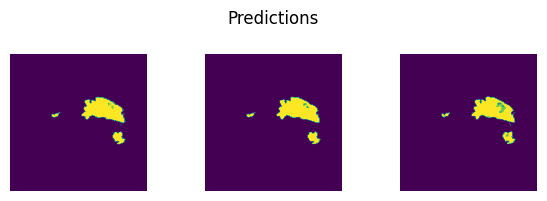

VAL
   Batch 1/31, val_loss: 0.8394
   Batch 2/31, val_loss: 0.9683
   Batch 3/31, val_loss: 0.9708
   Batch 4/31, val_loss: 0.9512
   Batch 5/31, val_loss: 0.9922
   Batch 6/31, val_loss: 0.6854
   Batch 7/31, val_loss: 0.8257
   Batch 8/31, val_loss: 0.9656
   Batch 9/31, val_loss: 0.6934
   Batch 10/31, val_loss: 0.9471
   Batch 11/31, val_loss: 0.8100
   Batch 12/31, val_loss: 0.9669
   Batch 13/31, val_loss: 0.9526
   Batch 14/31, val_loss: 0.9409
   Batch 15/31, val_loss: 0.9929
   Batch 16/31, val_loss: 0.9623
   Batch 17/31, val_loss: 0.9717
   Batch 18/31, val_loss: 0.9366
   Batch 19/31, val_loss: 0.7565
   Batch 20/31, val_loss: 0.8542
   Batch 21/31, val_loss: 0.9514
   Batch 22/31, val_loss: 0.9851
   Batch 23/31, val_loss: 0.9669
   Batch 24/31, val_loss: 0.7367
   Batch 25/31, val_loss: 0.7990
   Batch 26/31, val_loss: 0.9165
   Batch 27/31, val_loss: 0.9894
   Batch 28/31, val_loss: 0.7523
   Batch 29/31, val_loss: 0.9875
   Batch 30/31, val_loss: 0.9755
   Batch 31/31,

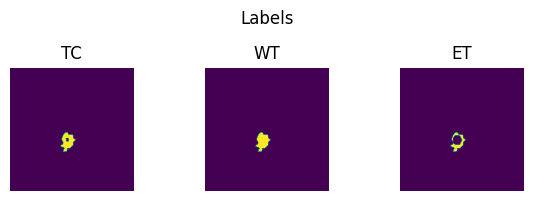

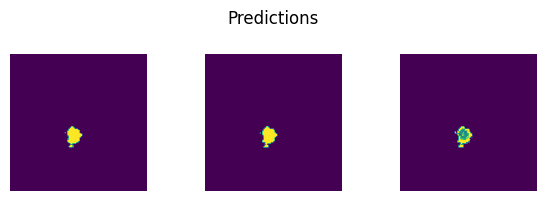

epoch 67
   average train loss: 0.2968
   average validation loss: 0.9036
   saved as best model: False
   current mean dice: 0.5160
   current TC dice: 0.5521
   current WT dice: 0.5532
   current ET dice: 0.4757
Best Mean Metric: 0.5343
time consuming of epoch 67 is: 1613.0791
----------
epoch 68/100
TRAIN
   Batch 1/248, train_loss: 0.0858, step time: 1.0325
   Batch 2/248, train_loss: 0.6651, step time: 1.0245
   Batch 3/248, train_loss: 0.3637, step time: 1.0245
   Batch 4/248, train_loss: 0.9709, step time: 1.0188
   Batch 5/248, train_loss: 0.1985, step time: 1.0158
   Batch 6/248, train_loss: 0.2284, step time: 1.0154
   Batch 7/248, train_loss: 0.0759, step time: 1.0151
   Batch 8/248, train_loss: 0.5781, step time: 1.0070
   Batch 9/248, train_loss: 0.0493, step time: 1.0106
   Batch 10/248, train_loss: 0.2770, step time: 1.0253
   Batch 11/248, train_loss: 0.2209, step time: 1.0082
   Batch 12/248, train_loss: 0.4093, step time: 1.0035
   Batch 13/248, train_loss: 0.3087, st

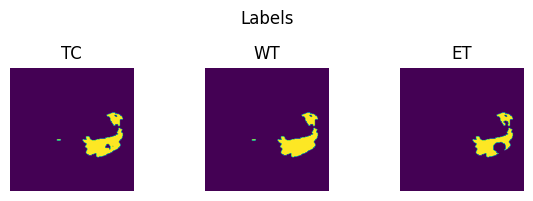

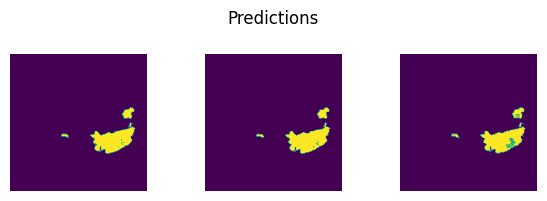

VAL
   Batch 1/31, val_loss: 0.8519
   Batch 2/31, val_loss: 0.9503
   Batch 3/31, val_loss: 0.9737
   Batch 4/31, val_loss: 0.9506
   Batch 5/31, val_loss: 0.9913
   Batch 6/31, val_loss: 0.6851
   Batch 7/31, val_loss: 0.8296
   Batch 8/31, val_loss: 0.9607
   Batch 9/31, val_loss: 0.6939
   Batch 10/31, val_loss: 0.9330
   Batch 11/31, val_loss: 0.8087
   Batch 12/31, val_loss: 0.9692
   Batch 13/31, val_loss: 0.9521
   Batch 14/31, val_loss: 0.9451
   Batch 15/31, val_loss: 0.9926
   Batch 16/31, val_loss: 0.9592
   Batch 17/31, val_loss: 0.9656
   Batch 18/31, val_loss: 0.9348
   Batch 19/31, val_loss: 0.7558
   Batch 20/31, val_loss: 0.8549
   Batch 21/31, val_loss: 0.9523
   Batch 22/31, val_loss: 0.9867
   Batch 23/31, val_loss: 0.9686
   Batch 24/31, val_loss: 0.7372
   Batch 25/31, val_loss: 0.7961
   Batch 26/31, val_loss: 0.9139
   Batch 27/31, val_loss: 0.9907
   Batch 28/31, val_loss: 0.7476
   Batch 29/31, val_loss: 0.9871
   Batch 30/31, val_loss: 0.9670
   Batch 31/31,

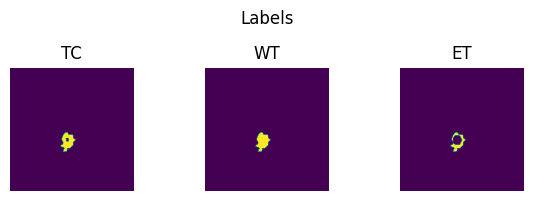

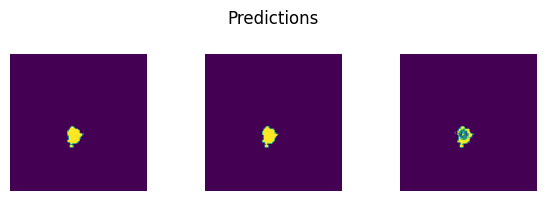

epoch 68
   average train loss: 0.2789
   average validation loss: 0.9024
   saved as best model: False
   current mean dice: 0.5100
   current TC dice: 0.5461
   current WT dice: 0.5466
   current ET dice: 0.4751
Best Mean Metric: 0.5343
time consuming of epoch 68 is: 1598.5266
----------
epoch 69/100
TRAIN
   Batch 1/248, train_loss: 0.0869, step time: 1.0295
   Batch 2/248, train_loss: 0.7088, step time: 1.0317
   Batch 3/248, train_loss: 0.4143, step time: 1.0081
   Batch 4/248, train_loss: 0.9984, step time: 1.0234
   Batch 5/248, train_loss: 0.1852, step time: 1.0074
   Batch 6/248, train_loss: 0.3034, step time: 1.0133
   Batch 7/248, train_loss: 0.0800, step time: 1.0231
   Batch 8/248, train_loss: 0.5966, step time: 1.0037
   Batch 9/248, train_loss: 0.0497, step time: 1.0068
   Batch 10/248, train_loss: 0.2751, step time: 1.0134
   Batch 11/248, train_loss: 0.2206, step time: 1.0120
   Batch 12/248, train_loss: 0.3482, step time: 1.0190
   Batch 13/248, train_loss: 0.3170, st

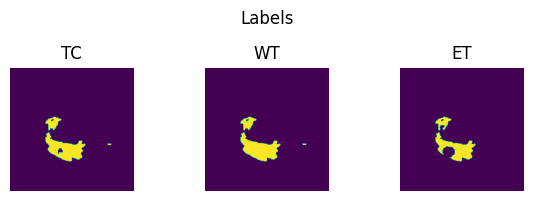

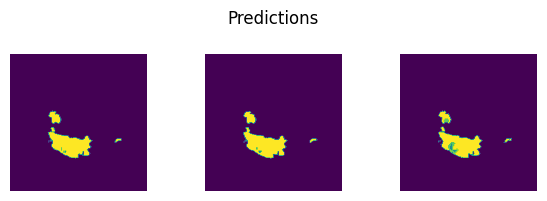

VAL
   Batch 1/31, val_loss: 0.8519
   Batch 2/31, val_loss: 0.9341
   Batch 3/31, val_loss: 0.9702
   Batch 4/31, val_loss: 0.9488
   Batch 5/31, val_loss: 0.9906
   Batch 6/31, val_loss: 0.6831
   Batch 7/31, val_loss: 0.8287
   Batch 8/31, val_loss: 0.9653
   Batch 9/31, val_loss: 0.6909
   Batch 10/31, val_loss: 0.9486
   Batch 11/31, val_loss: 0.8052
   Batch 12/31, val_loss: 0.9665
   Batch 13/31, val_loss: 0.9476
   Batch 14/31, val_loss: 0.9417
   Batch 15/31, val_loss: 0.9916
   Batch 16/31, val_loss: 0.9572
   Batch 17/31, val_loss: 0.9681
   Batch 18/31, val_loss: 0.9355
   Batch 19/31, val_loss: 0.7531
   Batch 20/31, val_loss: 0.8665
   Batch 21/31, val_loss: 0.9496
   Batch 22/31, val_loss: 0.9853
   Batch 23/31, val_loss: 0.9712
   Batch 24/31, val_loss: 0.7368
   Batch 25/31, val_loss: 0.7964
   Batch 26/31, val_loss: 0.9105
   Batch 27/31, val_loss: 0.9853
   Batch 28/31, val_loss: 0.7462
   Batch 29/31, val_loss: 0.9856
   Batch 30/31, val_loss: 0.9708
   Batch 31/31,

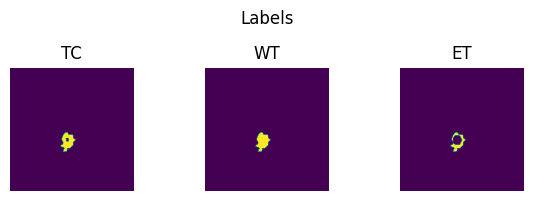

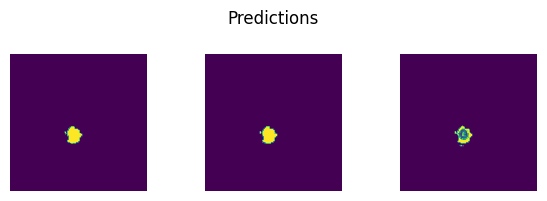

epoch 69
   average train loss: 0.2756
   average validation loss: 0.9016
   saved as best model: False
   current mean dice: 0.5135
   current TC dice: 0.5449
   current WT dice: 0.5438
   current ET dice: 0.4871
Best Mean Metric: 0.5343
time consuming of epoch 69 is: 1592.4116
----------
epoch 70/100
TRAIN
   Batch 1/248, train_loss: 0.0850, step time: 1.0167
   Batch 2/248, train_loss: 0.7024, step time: 1.0191
   Batch 3/248, train_loss: 0.3460, step time: 1.0148
   Batch 4/248, train_loss: 0.9523, step time: 1.0209
   Batch 5/248, train_loss: 0.1976, step time: 1.0211
   Batch 6/248, train_loss: 0.2323, step time: 1.0101
   Batch 7/248, train_loss: 0.0770, step time: 1.0194
   Batch 8/248, train_loss: 0.6237, step time: 1.0109
   Batch 9/248, train_loss: 0.0495, step time: 1.0164
   Batch 10/248, train_loss: 0.2567, step time: 1.0172
   Batch 11/248, train_loss: 0.2141, step time: 1.0371
   Batch 12/248, train_loss: 0.3747, step time: 1.0212
   Batch 13/248, train_loss: 0.2811, st

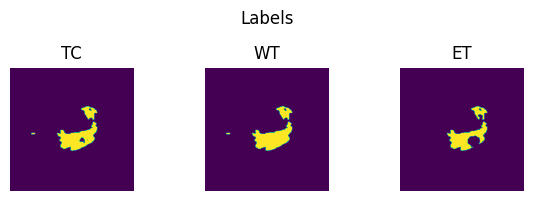

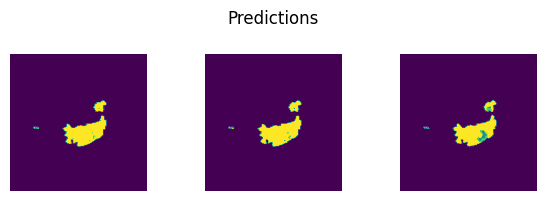

VAL
   Batch 1/31, val_loss: 0.8416
   Batch 2/31, val_loss: 0.9242
   Batch 3/31, val_loss: 0.9748
   Batch 4/31, val_loss: 0.9492
   Batch 5/31, val_loss: 0.9898
   Batch 6/31, val_loss: 0.6856
   Batch 7/31, val_loss: 0.8296
   Batch 8/31, val_loss: 0.9712
   Batch 9/31, val_loss: 0.6932
   Batch 10/31, val_loss: 0.9516
   Batch 11/31, val_loss: 0.8033
   Batch 12/31, val_loss: 0.9679
   Batch 13/31, val_loss: 0.9438
   Batch 14/31, val_loss: 0.9422
   Batch 15/31, val_loss: 0.9916
   Batch 16/31, val_loss: 0.9545
   Batch 17/31, val_loss: 0.9724
   Batch 18/31, val_loss: 0.9374
   Batch 19/31, val_loss: 0.7542
   Batch 20/31, val_loss: 0.8677
   Batch 21/31, val_loss: 0.9500
   Batch 22/31, val_loss: 0.9845
   Batch 23/31, val_loss: 0.9659
   Batch 24/31, val_loss: 0.7357
   Batch 25/31, val_loss: 0.7999
   Batch 26/31, val_loss: 0.9074
   Batch 27/31, val_loss: 0.9905
   Batch 28/31, val_loss: 0.7515
   Batch 29/31, val_loss: 0.9860
   Batch 30/31, val_loss: 0.9685
   Batch 31/31,

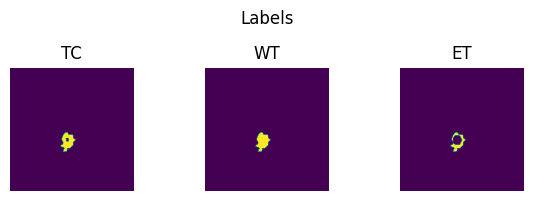

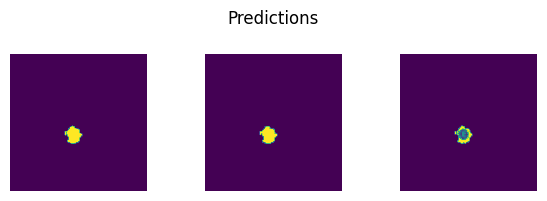

epoch 70
   average train loss: 0.2796
   average validation loss: 0.9017
   saved as best model: False
   current mean dice: 0.5015
   current TC dice: 0.5334
   current WT dice: 0.5353
   current ET dice: 0.4683
Best Mean Metric: 0.5343
time consuming of epoch 70 is: 1618.4020
----------
epoch 71/100
TRAIN
   Batch 1/248, train_loss: 0.0953, step time: 1.0486
   Batch 2/248, train_loss: 0.6466, step time: 1.0393
   Batch 3/248, train_loss: 0.3780, step time: 1.0395
   Batch 4/248, train_loss: 0.9512, step time: 1.0438
   Batch 5/248, train_loss: 0.1903, step time: 1.0394
   Batch 6/248, train_loss: 0.2087, step time: 1.0437
   Batch 7/248, train_loss: 0.0736, step time: 1.0377
   Batch 8/248, train_loss: 0.5527, step time: 1.0415
   Batch 9/248, train_loss: 0.0523, step time: 1.0274
   Batch 10/248, train_loss: 0.2642, step time: 1.0435
   Batch 11/248, train_loss: 0.2125, step time: 1.0404
   Batch 12/248, train_loss: 0.3606, step time: 1.0324
   Batch 13/248, train_loss: 0.2899, st

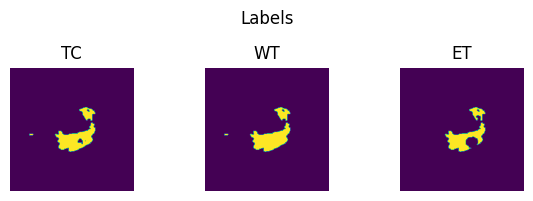

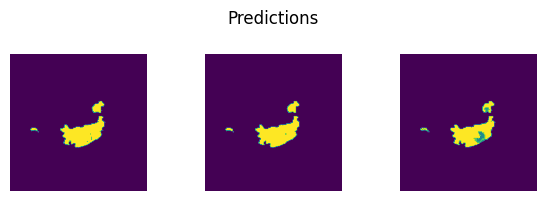

VAL
   Batch 1/31, val_loss: 0.8516
   Batch 2/31, val_loss: 0.9126
   Batch 3/31, val_loss: 0.9737
   Batch 4/31, val_loss: 0.9471
   Batch 5/31, val_loss: 0.9881
   Batch 6/31, val_loss: 0.6801
   Batch 7/31, val_loss: 0.8263
   Batch 8/31, val_loss: 0.9629
   Batch 9/31, val_loss: 0.6897
   Batch 10/31, val_loss: 0.9224
   Batch 11/31, val_loss: 0.8001
   Batch 12/31, val_loss: 0.9673
   Batch 13/31, val_loss: 0.9418
   Batch 14/31, val_loss: 0.9411
   Batch 15/31, val_loss: 0.9901
   Batch 16/31, val_loss: 0.9519
   Batch 17/31, val_loss: 0.9688
   Batch 18/31, val_loss: 0.9296
   Batch 19/31, val_loss: 0.7521
   Batch 20/31, val_loss: 0.8663
   Batch 21/31, val_loss: 0.9494
   Batch 22/31, val_loss: 0.9846
   Batch 23/31, val_loss: 0.9650
   Batch 24/31, val_loss: 0.7312
   Batch 25/31, val_loss: 0.7927
   Batch 26/31, val_loss: 0.9050
   Batch 27/31, val_loss: 0.9844
   Batch 28/31, val_loss: 0.7459
   Batch 29/31, val_loss: 0.9849
   Batch 30/31, val_loss: 0.9674
   Batch 31/31,

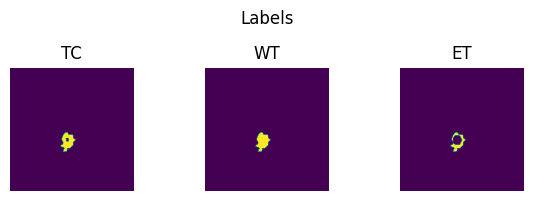

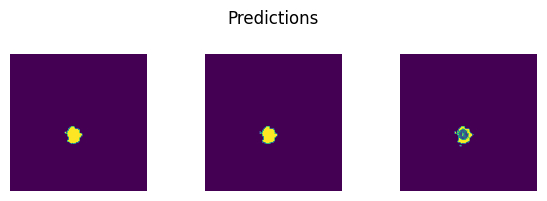

epoch 71
   average train loss: 0.2675
   average validation loss: 0.8980
   saved as best model: False
   current mean dice: 0.5085
   current TC dice: 0.5450
   current WT dice: 0.5450
   current ET dice: 0.4703
Best Mean Metric: 0.5343
time consuming of epoch 71 is: 1619.8276
----------
epoch 72/100
TRAIN
   Batch 1/248, train_loss: 0.0866, step time: 1.0457
   Batch 2/248, train_loss: 0.6743, step time: 1.0347
   Batch 3/248, train_loss: 0.3708, step time: 1.0332
   Batch 4/248, train_loss: 0.9919, step time: 1.0401
   Batch 5/248, train_loss: 0.2494, step time: 1.0410
   Batch 6/248, train_loss: 0.1869, step time: 1.0295
   Batch 7/248, train_loss: 0.0740, step time: 1.0359
   Batch 8/248, train_loss: 0.6114, step time: 1.0243
   Batch 9/248, train_loss: 0.0501, step time: 1.0321
   Batch 10/248, train_loss: 0.2389, step time: 1.0330
   Batch 11/248, train_loss: 0.2119, step time: 1.0361
   Batch 12/248, train_loss: 0.3355, step time: 1.0417
   Batch 13/248, train_loss: 0.2777, st

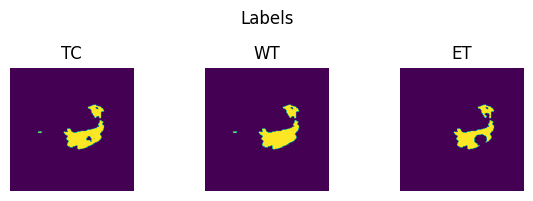

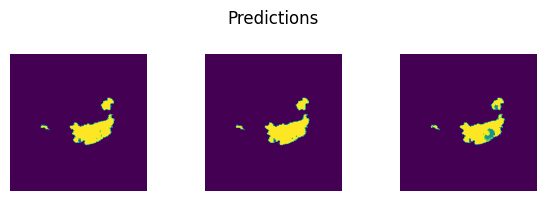

VAL
   Batch 1/31, val_loss: 0.8207
   Batch 2/31, val_loss: 0.9031
   Batch 3/31, val_loss: 0.9720
   Batch 4/31, val_loss: 0.9470
   Batch 5/31, val_loss: 0.9872
   Batch 6/31, val_loss: 0.6814
   Batch 7/31, val_loss: 0.8214
   Batch 8/31, val_loss: 0.9611
   Batch 9/31, val_loss: 0.6912
   Batch 10/31, val_loss: 0.9485
   Batch 11/31, val_loss: 0.7998
   Batch 12/31, val_loss: 0.9638
   Batch 13/31, val_loss: 0.9396
   Batch 14/31, val_loss: 0.9368
   Batch 15/31, val_loss: 0.9882
   Batch 16/31, val_loss: 0.9512
   Batch 17/31, val_loss: 0.9709
   Batch 18/31, val_loss: 0.9314
   Batch 19/31, val_loss: 0.7520
   Batch 20/31, val_loss: 0.8516
   Batch 21/31, val_loss: 0.9510
   Batch 22/31, val_loss: 0.9832
   Batch 23/31, val_loss: 0.9601
   Batch 24/31, val_loss: 0.7327
   Batch 25/31, val_loss: 0.7887
   Batch 26/31, val_loss: 0.9023
   Batch 27/31, val_loss: 0.9859
   Batch 28/31, val_loss: 0.7500
   Batch 29/31, val_loss: 0.9843
   Batch 30/31, val_loss: 0.9687
   Batch 31/31,

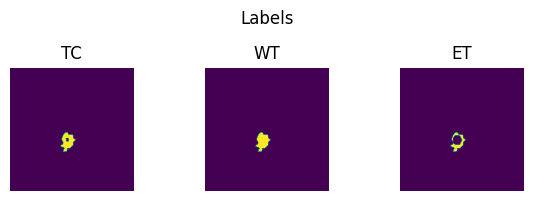

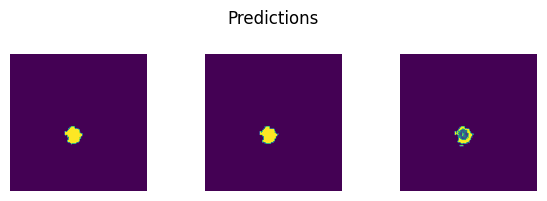

epoch 72
   average train loss: 0.2656
   average validation loss: 0.8964
   saved as best model: False
   current mean dice: 0.5070
   current TC dice: 0.5440
   current WT dice: 0.5457
   current ET dice: 0.4712
Best Mean Metric: 0.5343
time consuming of epoch 72 is: 1612.6269
----------
epoch 73/100
TRAIN
   Batch 1/248, train_loss: 0.0878, step time: 1.0458
   Batch 2/248, train_loss: 0.6685, step time: 1.0349
   Batch 3/248, train_loss: 0.4069, step time: 1.0250
   Batch 4/248, train_loss: 0.9361, step time: 1.0311
   Batch 5/248, train_loss: 0.1858, step time: 1.0312
   Batch 6/248, train_loss: 0.2210, step time: 1.0240
   Batch 7/248, train_loss: 0.0705, step time: 1.0295
   Batch 8/248, train_loss: 0.5241, step time: 1.0445
   Batch 9/248, train_loss: 0.0479, step time: 1.0322
   Batch 10/248, train_loss: 0.2644, step time: 1.0412
   Batch 11/248, train_loss: 0.2201, step time: 1.0215
   Batch 12/248, train_loss: 0.3445, step time: 1.0254
   Batch 13/248, train_loss: 0.2961, st

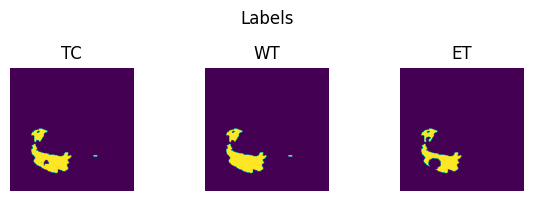

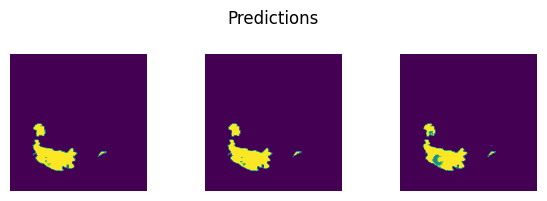

VAL
   Batch 1/31, val_loss: 0.8340
   Batch 2/31, val_loss: 0.8987
   Batch 3/31, val_loss: 0.9687
   Batch 4/31, val_loss: 0.9467
   Batch 5/31, val_loss: 0.9877
   Batch 6/31, val_loss: 0.6760
   Batch 7/31, val_loss: 0.8164
   Batch 8/31, val_loss: 0.9558
   Batch 9/31, val_loss: 0.6848
   Batch 10/31, val_loss: 0.9384
   Batch 11/31, val_loss: 0.7929
   Batch 12/31, val_loss: 0.9667
   Batch 13/31, val_loss: 0.9407
   Batch 14/31, val_loss: 0.9370
   Batch 15/31, val_loss: 0.9870
   Batch 16/31, val_loss: 0.9470
   Batch 17/31, val_loss: 0.9603
   Batch 18/31, val_loss: 0.9270
   Batch 19/31, val_loss: 0.7456
   Batch 20/31, val_loss: 0.8549
   Batch 21/31, val_loss: 0.9464
   Batch 22/31, val_loss: 0.9819
   Batch 23/31, val_loss: 0.9643
   Batch 24/31, val_loss: 0.7296
   Batch 25/31, val_loss: 0.7800
   Batch 26/31, val_loss: 0.8992
   Batch 27/31, val_loss: 0.9788
   Batch 28/31, val_loss: 0.7411
   Batch 29/31, val_loss: 0.9828
   Batch 30/31, val_loss: 0.9660
   Batch 31/31,

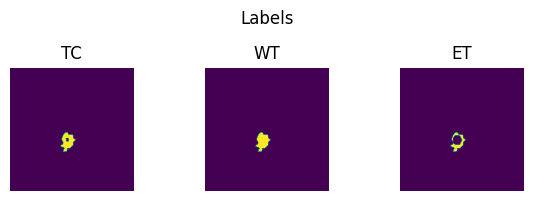

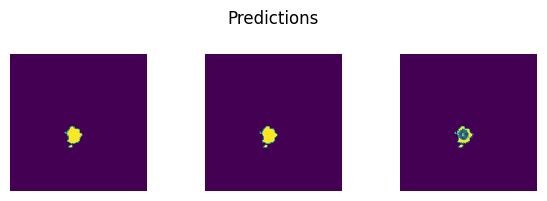

epoch 73
   average train loss: 0.2642
   average validation loss: 0.8936
   saved as best model: False
   current mean dice: 0.5143
   current TC dice: 0.5488
   current WT dice: 0.5485
   current ET dice: 0.4803
Best Mean Metric: 0.5343
time consuming of epoch 73 is: 1576.8774
----------
epoch 74/100
TRAIN
   Batch 1/248, train_loss: 0.0784, step time: 1.0481
   Batch 2/248, train_loss: 0.7066, step time: 1.0477
   Batch 3/248, train_loss: 0.3347, step time: 1.0224
   Batch 4/248, train_loss: 0.9819, step time: 1.0544
   Batch 5/248, train_loss: 0.1890, step time: 1.0512
   Batch 6/248, train_loss: 0.2485, step time: 1.0444
   Batch 7/248, train_loss: 0.0736, step time: 1.0341
   Batch 8/248, train_loss: 0.7231, step time: 1.0391
   Batch 9/248, train_loss: 0.0459, step time: 1.0449
   Batch 10/248, train_loss: 0.2674, step time: 1.0423
   Batch 11/248, train_loss: 0.2171, step time: 1.0404
   Batch 12/248, train_loss: 0.3380, step time: 1.0370
   Batch 13/248, train_loss: 0.2785, st

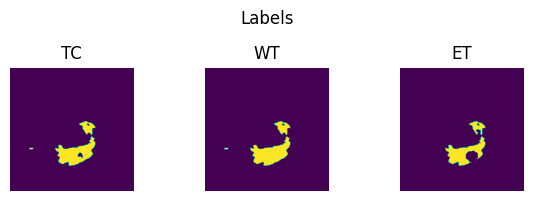

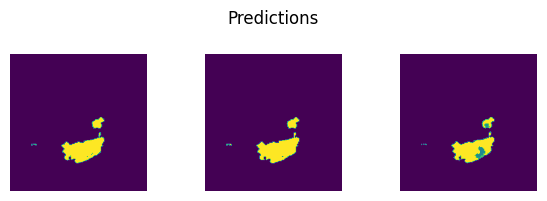

VAL
   Batch 1/31, val_loss: 0.8225
   Batch 2/31, val_loss: 0.8813
   Batch 3/31, val_loss: 0.9670
   Batch 4/31, val_loss: 0.9424
   Batch 5/31, val_loss: 0.9808
   Batch 6/31, val_loss: 0.6817
   Batch 7/31, val_loss: 0.8230
   Batch 8/31, val_loss: 0.9592
   Batch 9/31, val_loss: 0.6885
   Batch 10/31, val_loss: 0.9606
   Batch 11/31, val_loss: 0.7893
   Batch 12/31, val_loss: 0.9648
   Batch 13/31, val_loss: 0.9350
   Batch 14/31, val_loss: 0.9369
   Batch 15/31, val_loss: 0.9823
   Batch 16/31, val_loss: 0.9406
   Batch 17/31, val_loss: 0.9683
   Batch 18/31, val_loss: 0.9263
   Batch 19/31, val_loss: 0.7448
   Batch 20/31, val_loss: 0.8734
   Batch 21/31, val_loss: 0.9447
   Batch 22/31, val_loss: 0.9800
   Batch 23/31, val_loss: 0.9568
   Batch 24/31, val_loss: 0.7268
   Batch 25/31, val_loss: 0.7795
   Batch 26/31, val_loss: 0.8926
   Batch 27/31, val_loss: 0.9799
   Batch 28/31, val_loss: 0.7442
   Batch 29/31, val_loss: 0.9806
   Batch 30/31, val_loss: 0.9557
   Batch 31/31,

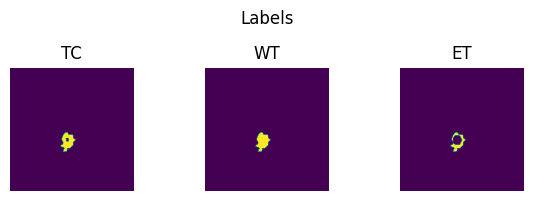

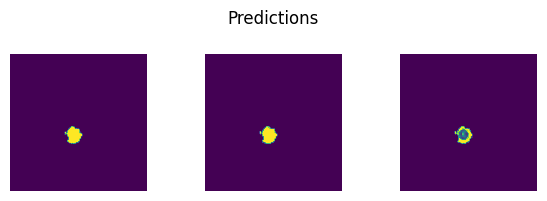

epoch 74
   average train loss: 0.2636
   average validation loss: 0.8926
   saved as best model: False
   current mean dice: 0.5179
   current TC dice: 0.5551
   current WT dice: 0.5548
   current ET dice: 0.4770
Best Mean Metric: 0.5343
time consuming of epoch 74 is: 1607.5827
----------
epoch 75/100
TRAIN
   Batch 1/248, train_loss: 0.1013, step time: 1.0298
   Batch 2/248, train_loss: 0.6926, step time: 1.0394
   Batch 3/248, train_loss: 0.3647, step time: 1.0418
   Batch 4/248, train_loss: 0.9461, step time: 1.0382
   Batch 5/248, train_loss: 0.2309, step time: 1.0522
   Batch 6/248, train_loss: 0.2425, step time: 1.0277
   Batch 7/248, train_loss: 0.0780, step time: 1.0242
   Batch 8/248, train_loss: 0.5525, step time: 1.0241
   Batch 9/248, train_loss: 0.0540, step time: 1.0181
   Batch 10/248, train_loss: 0.2758, step time: 1.0428
   Batch 11/248, train_loss: 0.2253, step time: 1.0260
   Batch 12/248, train_loss: 0.3689, step time: 1.0232
   Batch 13/248, train_loss: 0.3230, st

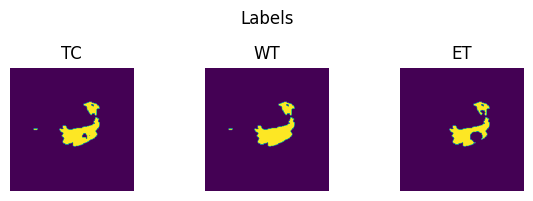

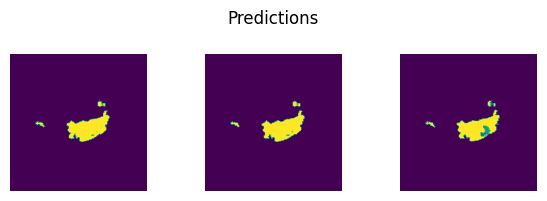

VAL
   Batch 1/31, val_loss: 0.8364
   Batch 2/31, val_loss: 0.8921
   Batch 3/31, val_loss: 0.9655
   Batch 4/31, val_loss: 0.9435
   Batch 5/31, val_loss: 0.9861
   Batch 6/31, val_loss: 0.6821
   Batch 7/31, val_loss: 0.8174
   Batch 8/31, val_loss: 0.9600
   Batch 9/31, val_loss: 0.7098
   Batch 10/31, val_loss: 0.9373
   Batch 11/31, val_loss: 0.7961
   Batch 12/31, val_loss: 0.9649
   Batch 13/31, val_loss: 0.9416
   Batch 14/31, val_loss: 0.9362
   Batch 15/31, val_loss: 0.9878
   Batch 16/31, val_loss: 0.9477
   Batch 17/31, val_loss: 0.9599
   Batch 18/31, val_loss: 0.9305
   Batch 19/31, val_loss: 0.7435
   Batch 20/31, val_loss: 0.8799
   Batch 21/31, val_loss: 0.9466
   Batch 22/31, val_loss: 0.9723
   Batch 23/31, val_loss: 0.9593
   Batch 24/31, val_loss: 0.7332
   Batch 25/31, val_loss: 0.7961
   Batch 26/31, val_loss: 0.9096
   Batch 27/31, val_loss: 0.9828
   Batch 28/31, val_loss: 0.7823
   Batch 29/31, val_loss: 0.9813
   Batch 30/31, val_loss: 0.9617
   Batch 31/31,

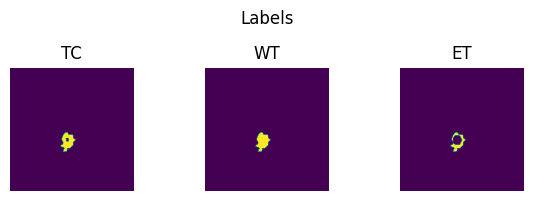

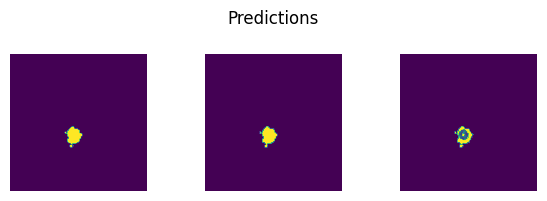

epoch 75
   average train loss: 0.2872
   average validation loss: 0.8971
   saved as best model: False
   current mean dice: 0.5234
   current TC dice: 0.5608
   current WT dice: 0.5609
   current ET dice: 0.4823
Best Mean Metric: 0.5343
time consuming of epoch 75 is: 1630.1723
----------
epoch 76/100
TRAIN
   Batch 1/248, train_loss: 0.0894, step time: 1.0551
   Batch 2/248, train_loss: 0.7230, step time: 1.0451
   Batch 3/248, train_loss: 0.3791, step time: 1.0344
   Batch 4/248, train_loss: 0.9304, step time: 1.0271
   Batch 5/248, train_loss: 0.2200, step time: 1.0273
   Batch 6/248, train_loss: 0.2387, step time: 1.0517
   Batch 7/248, train_loss: 0.0777, step time: 1.0192
   Batch 8/248, train_loss: 0.6395, step time: 1.0482
   Batch 9/248, train_loss: 0.0544, step time: 1.0386
   Batch 10/248, train_loss: 0.3155, step time: 1.0486
   Batch 11/248, train_loss: 0.2389, step time: 1.0469
   Batch 12/248, train_loss: 0.3645, step time: 1.0287
   Batch 13/248, train_loss: 0.3550, st

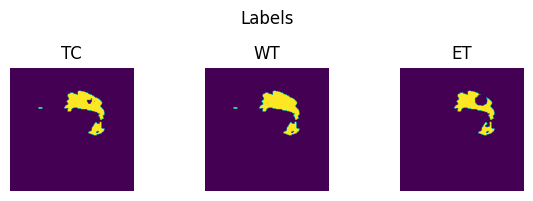

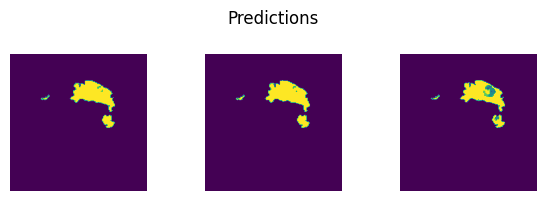

VAL
   Batch 1/31, val_loss: 0.8173
   Batch 2/31, val_loss: 0.8755
   Batch 3/31, val_loss: 0.9696
   Batch 4/31, val_loss: 0.9428
   Batch 5/31, val_loss: 0.9840
   Batch 6/31, val_loss: 0.6771
   Batch 7/31, val_loss: 0.8141
   Batch 8/31, val_loss: 0.9717
   Batch 9/31, val_loss: 0.6850
   Batch 10/31, val_loss: 0.9120
   Batch 11/31, val_loss: 0.7885
   Batch 12/31, val_loss: 0.9661
   Batch 13/31, val_loss: 0.9325
   Batch 14/31, val_loss: 0.9418
   Batch 15/31, val_loss: 0.9834
   Batch 16/31, val_loss: 0.9414
   Batch 17/31, val_loss: 0.9673
   Batch 18/31, val_loss: 0.9312
   Batch 19/31, val_loss: 0.7479
   Batch 20/31, val_loss: 0.8397
   Batch 21/31, val_loss: 0.9460
   Batch 22/31, val_loss: 0.9799
   Batch 23/31, val_loss: 0.9582
   Batch 24/31, val_loss: 0.7299
   Batch 25/31, val_loss: 0.7780
   Batch 26/31, val_loss: 0.8929
   Batch 27/31, val_loss: 0.9821
   Batch 28/31, val_loss: 0.7395
   Batch 29/31, val_loss: 0.9821
   Batch 30/31, val_loss: 0.9609
   Batch 31/31,

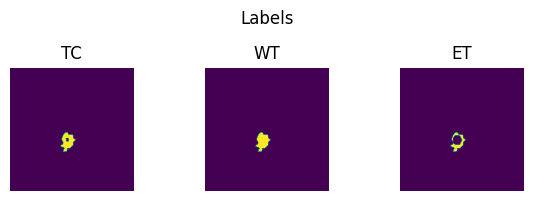

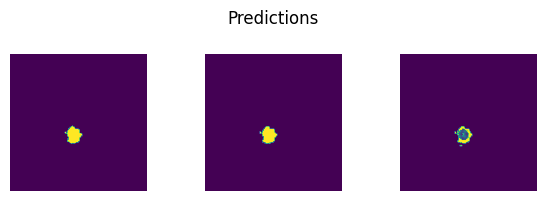

epoch 76
   average train loss: 0.2670
   average validation loss: 0.8903
   saved as best model: False
   current mean dice: 0.5051
   current TC dice: 0.5423
   current WT dice: 0.5419
   current ET dice: 0.4725
Best Mean Metric: 0.5343
time consuming of epoch 76 is: 1619.0565
----------
epoch 77/100
TRAIN
   Batch 1/248, train_loss: 0.0862, step time: 1.0428
   Batch 2/248, train_loss: 0.6133, step time: 1.0454
   Batch 3/248, train_loss: 0.3666, step time: 1.0491
   Batch 4/248, train_loss: 0.9531, step time: 1.0271
   Batch 5/248, train_loss: 0.1878, step time: 1.0492
   Batch 6/248, train_loss: 0.1903, step time: 1.0361
   Batch 7/248, train_loss: 0.0786, step time: 1.0293
   Batch 8/248, train_loss: 0.5222, step time: 1.0264
   Batch 9/248, train_loss: 0.0465, step time: 1.0411
   Batch 10/248, train_loss: 0.2593, step time: 1.0470
   Batch 11/248, train_loss: 0.1990, step time: 1.0323
   Batch 12/248, train_loss: 0.3560, step time: 1.0271
   Batch 13/248, train_loss: 0.2719, st

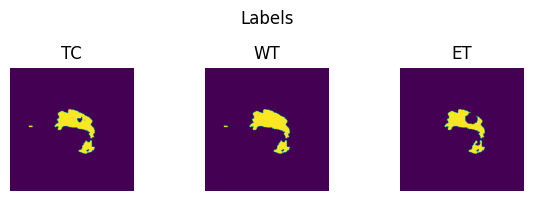

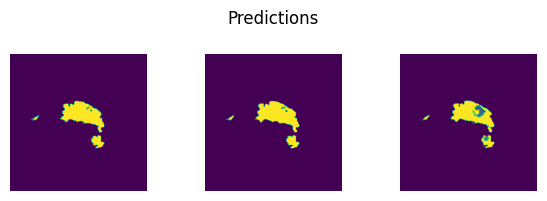

VAL
   Batch 1/31, val_loss: 0.8145
   Batch 2/31, val_loss: 0.8616
   Batch 3/31, val_loss: 0.9675
   Batch 4/31, val_loss: 0.9429
   Batch 5/31, val_loss: 0.9824
   Batch 6/31, val_loss: 0.6738
   Batch 7/31, val_loss: 0.8194
   Batch 8/31, val_loss: 0.9642
   Batch 9/31, val_loss: 0.6841
   Batch 10/31, val_loss: 0.9132
   Batch 11/31, val_loss: 0.7813
   Batch 12/31, val_loss: 0.9630
   Batch 13/31, val_loss: 0.9256
   Batch 14/31, val_loss: 0.9370
   Batch 15/31, val_loss: 0.9836
   Batch 16/31, val_loss: 0.9350
   Batch 17/31, val_loss: 0.9648
   Batch 18/31, val_loss: 0.9284
   Batch 19/31, val_loss: 0.7427
   Batch 20/31, val_loss: 0.8437
   Batch 21/31, val_loss: 0.9459
   Batch 22/31, val_loss: 0.9758
   Batch 23/31, val_loss: 0.9563
   Batch 24/31, val_loss: 0.7253
   Batch 25/31, val_loss: 0.7725
   Batch 26/31, val_loss: 0.8850
   Batch 27/31, val_loss: 0.9804
   Batch 28/31, val_loss: 0.7393
   Batch 29/31, val_loss: 0.9803
   Batch 30/31, val_loss: 0.9609
   Batch 31/31,

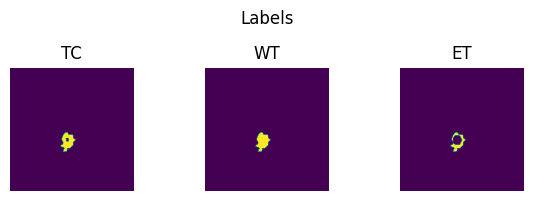

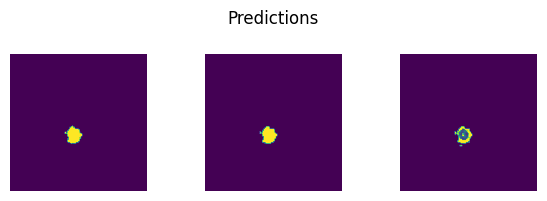

epoch 77
   average train loss: 0.2558
   average validation loss: 0.8874
   saved as best model: False
   current mean dice: 0.5263
   current TC dice: 0.5661
   current WT dice: 0.5652
   current ET dice: 0.4829
Best Mean Metric: 0.5343
time consuming of epoch 77 is: 1622.0272
----------
epoch 78/100
TRAIN
   Batch 1/248, train_loss: 0.0828, step time: 1.0571
   Batch 2/248, train_loss: 0.8314, step time: 1.0397
   Batch 3/248, train_loss: 0.3506, step time: 1.0449
   Batch 4/248, train_loss: 0.9575, step time: 1.0221
   Batch 5/248, train_loss: 0.1834, step time: 1.0405
   Batch 6/248, train_loss: 0.2101, step time: 1.0520
   Batch 7/248, train_loss: 0.0731, step time: 1.0416
   Batch 8/248, train_loss: 0.4956, step time: 1.0340
   Batch 9/248, train_loss: 0.0472, step time: 1.0395
   Batch 10/248, train_loss: 0.2533, step time: 1.0399
   Batch 11/248, train_loss: 0.2191, step time: 1.0402
   Batch 12/248, train_loss: 0.3993, step time: 1.0339
   Batch 13/248, train_loss: 0.3099, st

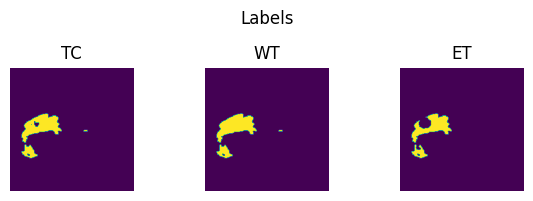

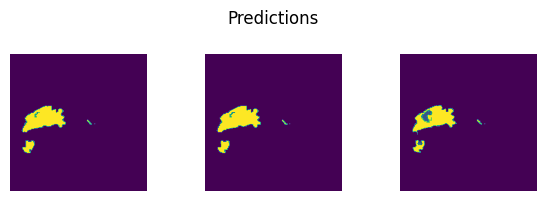

VAL
   Batch 1/31, val_loss: 0.8261
   Batch 2/31, val_loss: 0.8611
   Batch 3/31, val_loss: 0.9685
   Batch 4/31, val_loss: 0.9426
   Batch 5/31, val_loss: 0.9836
   Batch 6/31, val_loss: 0.6728
   Batch 7/31, val_loss: 0.8191
   Batch 8/31, val_loss: 0.9526
   Batch 9/31, val_loss: 0.6862
   Batch 10/31, val_loss: 0.9551
   Batch 11/31, val_loss: 0.7851
   Batch 12/31, val_loss: 0.9658
   Batch 13/31, val_loss: 0.9263
   Batch 14/31, val_loss: 0.9334
   Batch 15/31, val_loss: 0.9851
   Batch 16/31, val_loss: 0.9345
   Batch 17/31, val_loss: 0.9675
   Batch 18/31, val_loss: 0.9277
   Batch 19/31, val_loss: 0.7410
   Batch 20/31, val_loss: 0.8428
   Batch 21/31, val_loss: 0.9416
   Batch 22/31, val_loss: 0.9778
   Batch 23/31, val_loss: 0.9614
   Batch 24/31, val_loss: 0.7260
   Batch 25/31, val_loss: 0.7692
   Batch 26/31, val_loss: 0.8887
   Batch 27/31, val_loss: 0.9820
   Batch 28/31, val_loss: 0.7436
   Batch 29/31, val_loss: 0.9801
   Batch 30/31, val_loss: 0.9550
   Batch 31/31,

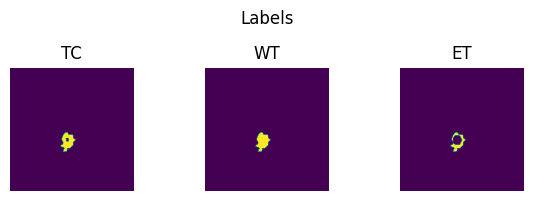

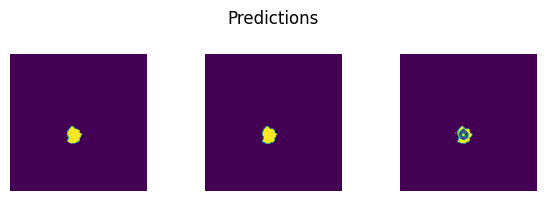

epoch 78
   average train loss: 0.2646
   average validation loss: 0.8892
   saved as best model: False
   current mean dice: 0.4945
   current TC dice: 0.5231
   current WT dice: 0.5247
   current ET dice: 0.4744
Best Mean Metric: 0.5343
time consuming of epoch 78 is: 1623.7354
----------
epoch 79/100
TRAIN
   Batch 1/248, train_loss: 0.0890, step time: 1.0313
   Batch 2/248, train_loss: 0.6984, step time: 1.0527
   Batch 3/248, train_loss: 0.3479, step time: 1.0336
   Batch 4/248, train_loss: 0.9419, step time: 1.0419
   Batch 5/248, train_loss: 0.2490, step time: 1.0410
   Batch 6/248, train_loss: 0.2718, step time: 1.0351
   Batch 7/248, train_loss: 0.0768, step time: 1.0250
   Batch 8/248, train_loss: 0.5752, step time: 1.0375
   Batch 9/248, train_loss: 0.0540, step time: 1.0242
   Batch 10/248, train_loss: 0.2180, step time: 1.0454
   Batch 11/248, train_loss: 0.2060, step time: 1.0467
   Batch 12/248, train_loss: 0.3695, step time: 1.0389
   Batch 13/248, train_loss: 0.2869, st

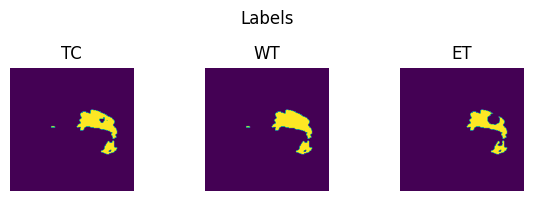

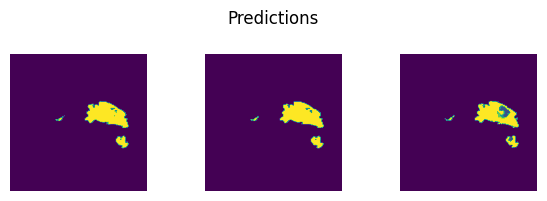

VAL
   Batch 1/31, val_loss: 0.8207
   Batch 2/31, val_loss: 0.8584
   Batch 3/31, val_loss: 0.9652
   Batch 4/31, val_loss: 0.9423
   Batch 5/31, val_loss: 0.9841
   Batch 6/31, val_loss: 0.6749
   Batch 7/31, val_loss: 0.8206
   Batch 8/31, val_loss: 0.9655
   Batch 9/31, val_loss: 0.6825
   Batch 10/31, val_loss: 0.9389
   Batch 11/31, val_loss: 0.7832
   Batch 12/31, val_loss: 0.9615
   Batch 13/31, val_loss: 0.9276
   Batch 14/31, val_loss: 0.9333
   Batch 15/31, val_loss: 0.9840
   Batch 16/31, val_loss: 0.9362
   Batch 17/31, val_loss: 0.9677
   Batch 18/31, val_loss: 0.9303
   Batch 19/31, val_loss: 0.7450
   Batch 20/31, val_loss: 0.8501
   Batch 21/31, val_loss: 0.9436
   Batch 22/31, val_loss: 0.9758
   Batch 23/31, val_loss: 0.9554
   Batch 24/31, val_loss: 0.7283
   Batch 25/31, val_loss: 0.7722
   Batch 26/31, val_loss: 0.8862
   Batch 27/31, val_loss: 0.9767
   Batch 28/31, val_loss: 0.7367
   Batch 29/31, val_loss: 0.9803
   Batch 30/31, val_loss: 0.9581
   Batch 31/31,

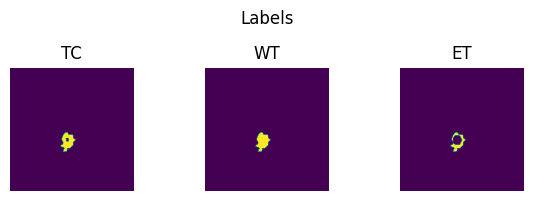

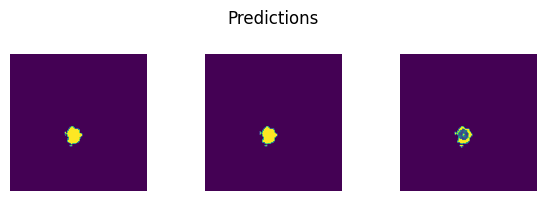

epoch 79
   average train loss: 0.2717
   average validation loss: 0.8886
   saved as best model: False
   current mean dice: 0.5260
   current TC dice: 0.5552
   current WT dice: 0.5542
   current ET dice: 0.5055
Best Mean Metric: 0.5343
time consuming of epoch 79 is: 1616.1443
----------
epoch 80/100
TRAIN
   Batch 1/248, train_loss: 0.0856, step time: 1.0489
   Batch 2/248, train_loss: 0.7341, step time: 1.0382
   Batch 3/248, train_loss: 0.3107, step time: 1.0301
   Batch 4/248, train_loss: 0.9973, step time: 1.0385
   Batch 5/248, train_loss: 0.2139, step time: 1.0277
   Batch 6/248, train_loss: 0.1822, step time: 1.0406
   Batch 7/248, train_loss: 0.0701, step time: 1.0289
   Batch 8/248, train_loss: 0.5430, step time: 1.0490
   Batch 9/248, train_loss: 0.0479, step time: 1.0232
   Batch 10/248, train_loss: 0.2256, step time: 1.0303
   Batch 11/248, train_loss: 0.2049, step time: 1.0349
   Batch 12/248, train_loss: 0.3141, step time: 1.0324
   Batch 13/248, train_loss: 0.2888, st

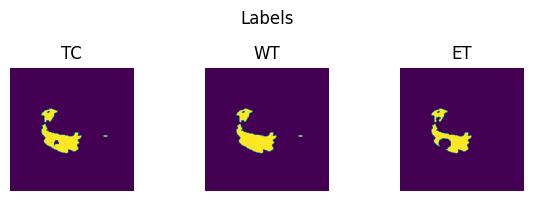

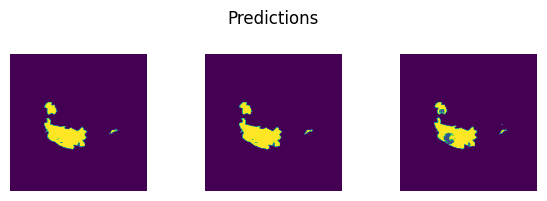

VAL
   Batch 1/31, val_loss: 0.8223
   Batch 2/31, val_loss: 0.8564
   Batch 3/31, val_loss: 0.9659
   Batch 4/31, val_loss: 0.9427
   Batch 5/31, val_loss: 0.9837
   Batch 6/31, val_loss: 0.6725
   Batch 7/31, val_loss: 0.8147
   Batch 8/31, val_loss: 0.9625
   Batch 9/31, val_loss: 0.6822
   Batch 10/31, val_loss: 0.9428
   Batch 11/31, val_loss: 0.7819
   Batch 12/31, val_loss: 0.9610
   Batch 13/31, val_loss: 0.9267
   Batch 14/31, val_loss: 0.9311
   Batch 15/31, val_loss: 0.9788
   Batch 16/31, val_loss: 0.9360
   Batch 17/31, val_loss: 0.9678
   Batch 18/31, val_loss: 0.9286
   Batch 19/31, val_loss: 0.7416
   Batch 20/31, val_loss: 0.8479
   Batch 21/31, val_loss: 0.9421
   Batch 22/31, val_loss: 0.9779
   Batch 23/31, val_loss: 0.9556
   Batch 24/31, val_loss: 0.7261
   Batch 25/31, val_loss: 0.7694
   Batch 26/31, val_loss: 0.8854
   Batch 27/31, val_loss: 0.9724
   Batch 28/31, val_loss: 0.7354
   Batch 29/31, val_loss: 0.9799
   Batch 30/31, val_loss: 0.9591
   Batch 31/31,

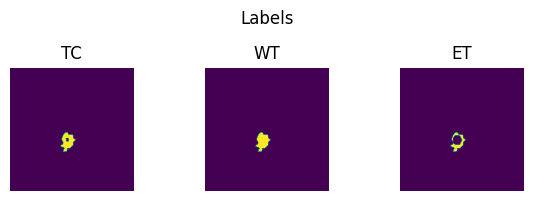

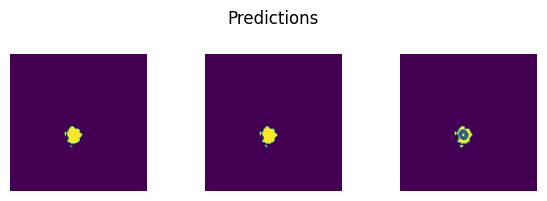

epoch 80
   average train loss: 0.2565
   average validation loss: 0.8875
   saved as best model: False
   current mean dice: 0.5327
   current TC dice: 0.5690
   current WT dice: 0.5683
   current ET dice: 0.4983
Best Mean Metric: 0.5343
time consuming of epoch 80 is: 1626.6812
----------
epoch 81/100
TRAIN
   Batch 1/248, train_loss: 0.0827, step time: 1.0381
   Batch 2/248, train_loss: 0.7193, step time: 1.0394
   Batch 3/248, train_loss: 0.3355, step time: 1.0287
   Batch 4/248, train_loss: 0.9377, step time: 1.0350
   Batch 5/248, train_loss: 0.1863, step time: 1.0401
   Batch 6/248, train_loss: 0.2230, step time: 1.0360
   Batch 7/248, train_loss: 0.0711, step time: 1.0334
   Batch 8/248, train_loss: 0.5694, step time: 1.0393
   Batch 9/248, train_loss: 0.0480, step time: 1.0520
   Batch 10/248, train_loss: 0.2430, step time: 1.0421
   Batch 11/248, train_loss: 0.1934, step time: 1.0275
   Batch 12/248, train_loss: 0.3371, step time: 1.0337
   Batch 13/248, train_loss: 0.2953, st

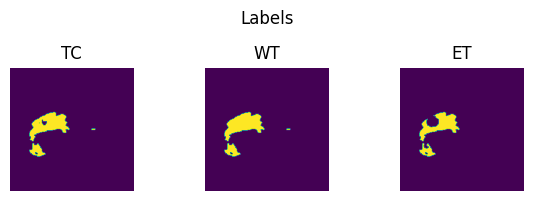

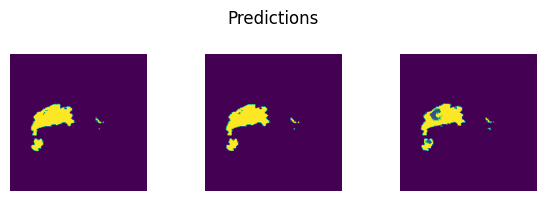

VAL
   Batch 1/31, val_loss: 0.8153
   Batch 2/31, val_loss: 0.8600
   Batch 3/31, val_loss: 0.9638
   Batch 4/31, val_loss: 0.9413
   Batch 5/31, val_loss: 0.9835
   Batch 6/31, val_loss: 0.6729
   Batch 7/31, val_loss: 0.8219
   Batch 8/31, val_loss: 0.9582
   Batch 9/31, val_loss: 0.6825
   Batch 10/31, val_loss: 0.9201
   Batch 11/31, val_loss: 0.7811
   Batch 12/31, val_loss: 0.9590
   Batch 13/31, val_loss: 0.9259
   Batch 14/31, val_loss: 0.9306
   Batch 15/31, val_loss: 0.9827
   Batch 16/31, val_loss: 0.9345
   Batch 17/31, val_loss: 0.9636
   Batch 18/31, val_loss: 0.9260
   Batch 19/31, val_loss: 0.7426
   Batch 20/31, val_loss: 0.8519
   Batch 21/31, val_loss: 0.9452
   Batch 22/31, val_loss: 0.9782
   Batch 23/31, val_loss: 0.9581
   Batch 24/31, val_loss: 0.7292
   Batch 25/31, val_loss: 0.7717
   Batch 26/31, val_loss: 0.8843
   Batch 27/31, val_loss: 0.9734
   Batch 28/31, val_loss: 0.7353
   Batch 29/31, val_loss: 0.9799
   Batch 30/31, val_loss: 0.9546
   Batch 31/31,

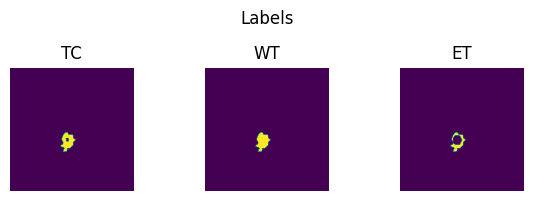

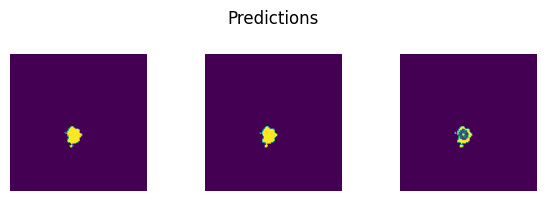

epoch 81
   average train loss: 0.2537
   average validation loss: 0.8867
   saved as best model: False
   current mean dice: 0.5301
   current TC dice: 0.5626
   current WT dice: 0.5644
   current ET dice: 0.5082
Best Mean Metric: 0.5343
time consuming of epoch 81 is: 1649.9164
----------
epoch 82/100
TRAIN
   Batch 1/248, train_loss: 0.0830, step time: 1.0400
   Batch 2/248, train_loss: 0.6631, step time: 1.0418
   Batch 3/248, train_loss: 0.2940, step time: 1.0434
   Batch 4/248, train_loss: 0.9423, step time: 1.0260
   Batch 5/248, train_loss: 0.1895, step time: 1.0262
   Batch 6/248, train_loss: 0.2030, step time: 1.0278
   Batch 7/248, train_loss: 0.0741, step time: 1.0387
   Batch 8/248, train_loss: 0.5738, step time: 1.0233
   Batch 9/248, train_loss: 0.0450, step time: 1.0210
   Batch 10/248, train_loss: 0.2286, step time: 1.0441
   Batch 11/248, train_loss: 0.1908, step time: 1.0240
   Batch 12/248, train_loss: 0.3180, step time: 1.0350
   Batch 13/248, train_loss: 0.2850, st

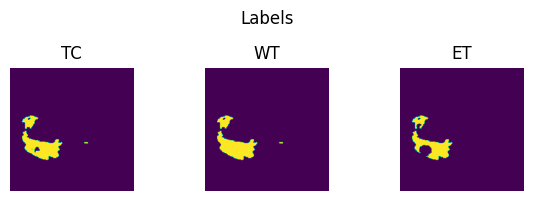

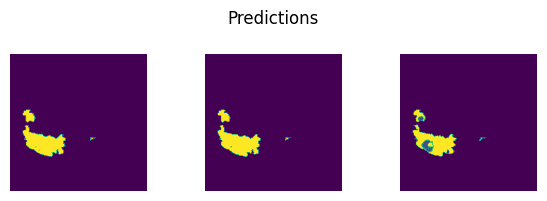

VAL
   Batch 1/31, val_loss: 0.8303
   Batch 2/31, val_loss: 0.8515
   Batch 3/31, val_loss: 0.9653
   Batch 4/31, val_loss: 0.9403
   Batch 5/31, val_loss: 0.9836
   Batch 6/31, val_loss: 0.6749
   Batch 7/31, val_loss: 0.8183
   Batch 8/31, val_loss: 0.9644
   Batch 9/31, val_loss: 0.6822
   Batch 10/31, val_loss: 0.9318
   Batch 11/31, val_loss: 0.7813
   Batch 12/31, val_loss: 0.9641
   Batch 13/31, val_loss: 0.9412
   Batch 14/31, val_loss: 0.9519
   Batch 15/31, val_loss: 0.9783
   Batch 16/31, val_loss: 0.9370
   Batch 17/31, val_loss: 0.9641
   Batch 18/31, val_loss: 0.9274
   Batch 19/31, val_loss: 0.7383
   Batch 20/31, val_loss: 0.8556
   Batch 21/31, val_loss: 0.8972
   Batch 22/31, val_loss: 0.9755
   Batch 23/31, val_loss: 0.9595
   Batch 24/31, val_loss: 0.7293
   Batch 25/31, val_loss: 0.7701
   Batch 26/31, val_loss: 0.8843
   Batch 27/31, val_loss: 0.9737
   Batch 28/31, val_loss: 0.7368
   Batch 29/31, val_loss: 0.9804
   Batch 30/31, val_loss: 0.9538
   Batch 31/31,

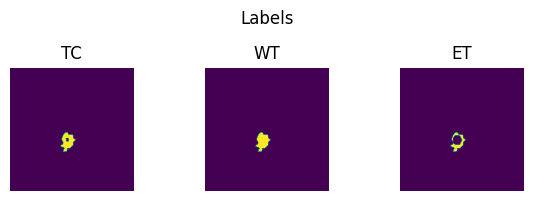

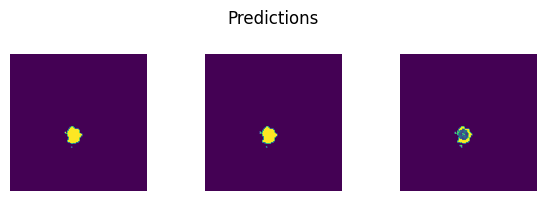

epoch 82
   average train loss: 0.2712
   average validation loss: 0.8872
   saved as best model: False
   current mean dice: 0.4962
   current TC dice: 0.5278
   current WT dice: 0.5320
   current ET dice: 0.4708
Best Mean Metric: 0.5343
time consuming of epoch 82 is: 1636.0274
----------
epoch 83/100
TRAIN
   Batch 1/248, train_loss: 0.0854, step time: 1.0475
   Batch 2/248, train_loss: 0.6541, step time: 1.0331
   Batch 3/248, train_loss: 0.3653, step time: 1.0281
   Batch 4/248, train_loss: 0.9236, step time: 1.0297
   Batch 5/248, train_loss: 0.1796, step time: 1.0363
   Batch 6/248, train_loss: 0.4951, step time: 1.0409
   Batch 7/248, train_loss: 0.0751, step time: 1.0347
   Batch 8/248, train_loss: 0.6676, step time: 1.0270
   Batch 9/248, train_loss: 0.0453, step time: 1.0211
   Batch 10/248, train_loss: 0.2208, step time: 1.0223
   Batch 11/248, train_loss: 0.1847, step time: 1.0396
   Batch 12/248, train_loss: 0.3209, step time: 1.0288
   Batch 13/248, train_loss: 0.2670, st

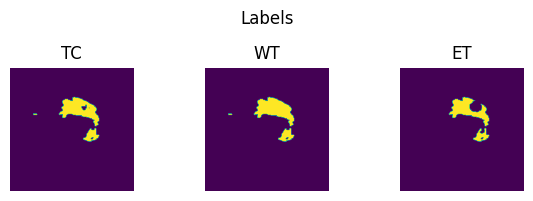

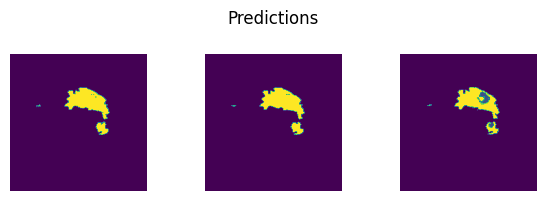

VAL
   Batch 1/31, val_loss: 0.8250
   Batch 2/31, val_loss: 0.8518
   Batch 3/31, val_loss: 0.9643
   Batch 4/31, val_loss: 0.9422
   Batch 5/31, val_loss: 0.9829
   Batch 6/31, val_loss: 0.6723
   Batch 7/31, val_loss: 0.8230
   Batch 8/31, val_loss: 0.9652
   Batch 9/31, val_loss: 0.6813
   Batch 10/31, val_loss: 0.9263
   Batch 11/31, val_loss: 0.7790
   Batch 12/31, val_loss: 0.9618
   Batch 13/31, val_loss: 0.9239
   Batch 14/31, val_loss: 0.9357
   Batch 15/31, val_loss: 0.9824
   Batch 16/31, val_loss: 0.9340
   Batch 17/31, val_loss: 0.9671
   Batch 18/31, val_loss: 0.9289
   Batch 19/31, val_loss: 0.7413
   Batch 20/31, val_loss: 0.8488
   Batch 21/31, val_loss: 0.9424
   Batch 22/31, val_loss: 0.9723
   Batch 23/31, val_loss: 0.9563
   Batch 24/31, val_loss: 0.7257
   Batch 25/31, val_loss: 0.7689
   Batch 26/31, val_loss: 0.8816
   Batch 27/31, val_loss: 0.9763
   Batch 28/31, val_loss: 0.7375
   Batch 29/31, val_loss: 0.9796
   Batch 30/31, val_loss: 0.9608
   Batch 31/31,

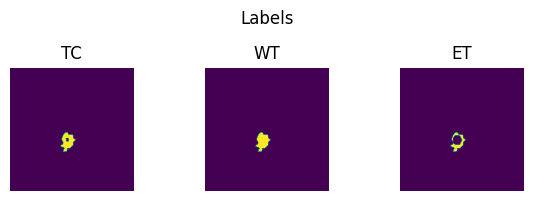

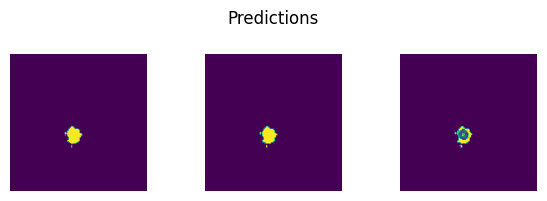

epoch 83
   average train loss: 0.2537
   average validation loss: 0.8870
   saved as best model: False
   current mean dice: 0.5147
   current TC dice: 0.5485
   current WT dice: 0.5476
   current ET dice: 0.4851
Best Mean Metric: 0.5343
time consuming of epoch 83 is: 1633.7166
----------
epoch 84/100
TRAIN
   Batch 1/248, train_loss: 0.0790, step time: 1.0283
   Batch 2/248, train_loss: 0.6704, step time: 1.0348
   Batch 3/248, train_loss: 0.2774, step time: 1.0499
   Batch 4/248, train_loss: 0.9965, step time: 1.0387
   Batch 5/248, train_loss: 0.1754, step time: 1.0253
   Batch 6/248, train_loss: 0.1840, step time: 1.0527
   Batch 7/248, train_loss: 0.0738, step time: 1.0389
   Batch 8/248, train_loss: 0.6017, step time: 1.0264
   Batch 9/248, train_loss: 0.0453, step time: 1.0498
   Batch 10/248, train_loss: 0.2167, step time: 1.0303
   Batch 11/248, train_loss: 0.1878, step time: 1.0544
   Batch 12/248, train_loss: 0.3470, step time: 1.0461
   Batch 13/248, train_loss: 0.2626, st

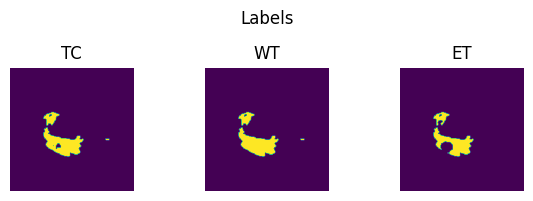

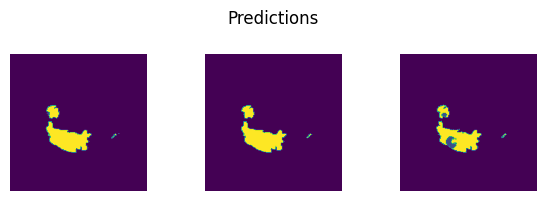

VAL
   Batch 1/31, val_loss: 0.8389
   Batch 2/31, val_loss: 0.8385
   Batch 3/31, val_loss: 0.9530
   Batch 4/31, val_loss: 0.9380
   Batch 5/31, val_loss: 0.9792
   Batch 6/31, val_loss: 0.6709
   Batch 7/31, val_loss: 0.8189
   Batch 8/31, val_loss: 0.9516
   Batch 9/31, val_loss: 0.6778
   Batch 10/31, val_loss: 0.9209
   Batch 11/31, val_loss: 0.7747
   Batch 12/31, val_loss: 0.9578
   Batch 13/31, val_loss: 0.9212
   Batch 14/31, val_loss: 0.9306
   Batch 15/31, val_loss: 0.9818
   Batch 16/31, val_loss: 0.9275
   Batch 17/31, val_loss: 0.9614
   Batch 18/31, val_loss: 0.9245
   Batch 19/31, val_loss: 0.7319
   Batch 20/31, val_loss: 0.8334
   Batch 21/31, val_loss: 0.9323
   Batch 22/31, val_loss: 0.9729
   Batch 23/31, val_loss: 0.9596
   Batch 24/31, val_loss: 0.7249
   Batch 25/31, val_loss: 0.7652
   Batch 26/31, val_loss: 0.8769
   Batch 27/31, val_loss: 0.9687
   Batch 28/31, val_loss: 0.7331
   Batch 29/31, val_loss: 0.9765
   Batch 30/31, val_loss: 0.9558
   Batch 31/31,

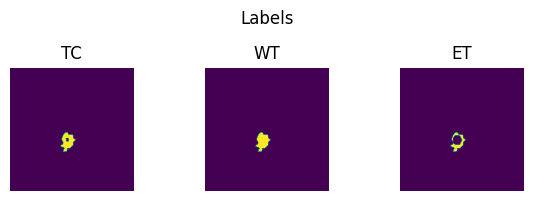

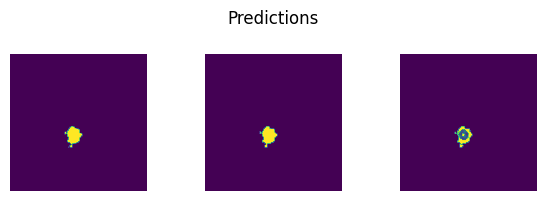

epoch 84
   average train loss: 0.2547
   average validation loss: 0.8824
   saved as best model: False
   current mean dice: 0.5053
   current TC dice: 0.5359
   current WT dice: 0.5379
   current ET dice: 0.4786
Best Mean Metric: 0.5343
time consuming of epoch 84 is: 1625.1708
----------
epoch 85/100
TRAIN
   Batch 1/248, train_loss: 0.0857, step time: 1.0400
   Batch 2/248, train_loss: 0.6373, step time: 1.0400
   Batch 3/248, train_loss: 0.3641, step time: 1.0375
   Batch 4/248, train_loss: 0.9797, step time: 1.0279
   Batch 5/248, train_loss: 0.2037, step time: 1.0252
   Batch 6/248, train_loss: 0.5989, step time: 1.0235
   Batch 7/248, train_loss: 0.0668, step time: 1.0266
   Batch 8/248, train_loss: 0.6968, step time: 1.0443
   Batch 9/248, train_loss: 0.0453, step time: 1.0393
   Batch 10/248, train_loss: 0.2244, step time: 1.0313
   Batch 11/248, train_loss: 0.1835, step time: 1.0427
   Batch 12/248, train_loss: 0.3019, step time: 1.0253
   Batch 13/248, train_loss: 0.3121, st

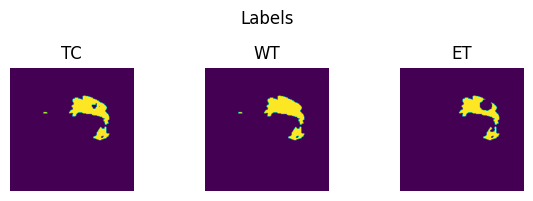

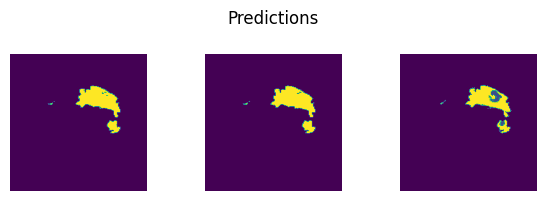

VAL
   Batch 1/31, val_loss: 0.8238
   Batch 2/31, val_loss: 0.8621
   Batch 3/31, val_loss: 0.9564
   Batch 4/31, val_loss: 0.9377
   Batch 5/31, val_loss: 0.9827
   Batch 6/31, val_loss: 0.6696
   Batch 7/31, val_loss: 0.8093
   Batch 8/31, val_loss: 0.9440
   Batch 9/31, val_loss: 0.6807
   Batch 10/31, val_loss: 0.9180
   Batch 11/31, val_loss: 0.7776
   Batch 12/31, val_loss: 0.9634
   Batch 13/31, val_loss: 0.9257
   Batch 14/31, val_loss: 0.9342
   Batch 15/31, val_loss: 0.9853
   Batch 16/31, val_loss: 0.9335
   Batch 17/31, val_loss: 0.9561
   Batch 18/31, val_loss: 0.9198
   Batch 19/31, val_loss: 0.7292
   Batch 20/31, val_loss: 0.8491
   Batch 21/31, val_loss: 0.9430
   Batch 22/31, val_loss: 0.9652
   Batch 23/31, val_loss: 0.9546
   Batch 24/31, val_loss: 0.7242
   Batch 25/31, val_loss: 0.7680
   Batch 26/31, val_loss: 0.8843
   Batch 27/31, val_loss: 0.9718
   Batch 28/31, val_loss: 0.7347
   Batch 29/31, val_loss: 0.9788
   Batch 30/31, val_loss: 0.9531
   Batch 31/31,

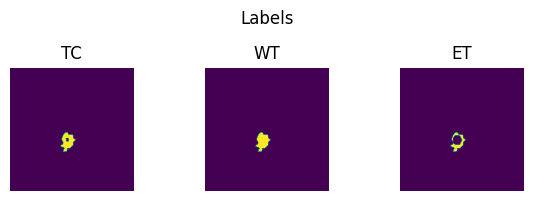

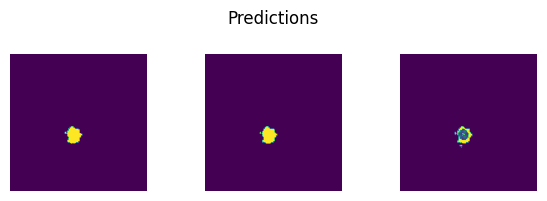

epoch 85
   average train loss: 0.2487
   average validation loss: 0.8838
   saved as best model: True
   current mean dice: 0.5436
   current TC dice: 0.5790
   current WT dice: 0.5810
   current ET dice: 0.5094
Best Mean Metric: 0.5436
time consuming of epoch 85 is: 1624.1343
----------
epoch 86/100
TRAIN
   Batch 1/248, train_loss: 0.0788, step time: 1.0302
   Batch 2/248, train_loss: 0.7676, step time: 1.0581
   Batch 3/248, train_loss: 0.2898, step time: 1.0262
   Batch 4/248, train_loss: 0.9786, step time: 1.0477
   Batch 5/248, train_loss: 0.1820, step time: 1.0504
   Batch 6/248, train_loss: 0.2017, step time: 1.0505
   Batch 7/248, train_loss: 0.0701, step time: 1.0319
   Batch 8/248, train_loss: 0.5617, step time: 1.0247
   Batch 9/248, train_loss: 0.0442, step time: 1.0264
   Batch 10/248, train_loss: 0.2421, step time: 1.0436
   Batch 11/248, train_loss: 0.1803, step time: 1.0354
   Batch 12/248, train_loss: 0.3150, step time: 1.0394
   Batch 13/248, train_loss: 0.2714, ste

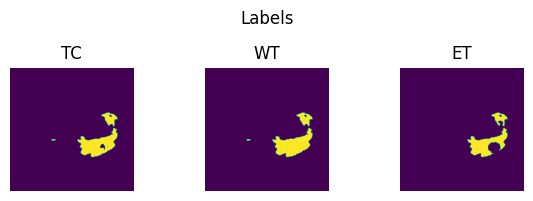

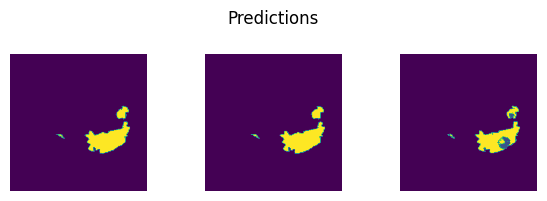

VAL
   Batch 1/31, val_loss: 0.8216
   Batch 2/31, val_loss: 0.8418
   Batch 3/31, val_loss: 0.9532
   Batch 4/31, val_loss: 0.9339
   Batch 5/31, val_loss: 0.9804
   Batch 6/31, val_loss: 0.6693
   Batch 7/31, val_loss: 0.8147
   Batch 8/31, val_loss: 0.9553
   Batch 9/31, val_loss: 0.6794
   Batch 10/31, val_loss: 0.9064
   Batch 11/31, val_loss: 0.7726
   Batch 12/31, val_loss: 0.9615
   Batch 13/31, val_loss: 0.9185
   Batch 14/31, val_loss: 0.9335
   Batch 15/31, val_loss: 0.9823
   Batch 16/31, val_loss: 0.9281
   Batch 17/31, val_loss: 0.9591
   Batch 18/31, val_loss: 0.9244
   Batch 19/31, val_loss: 0.7354
   Batch 20/31, val_loss: 0.8438
   Batch 21/31, val_loss: 0.9147
   Batch 22/31, val_loss: 0.9713
   Batch 23/31, val_loss: 0.9504
   Batch 24/31, val_loss: 0.7212
   Batch 25/31, val_loss: 0.7665
   Batch 26/31, val_loss: 0.8781
   Batch 27/31, val_loss: 0.9704
   Batch 28/31, val_loss: 0.7358
   Batch 29/31, val_loss: 0.9761
   Batch 30/31, val_loss: 0.9550
   Batch 31/31,

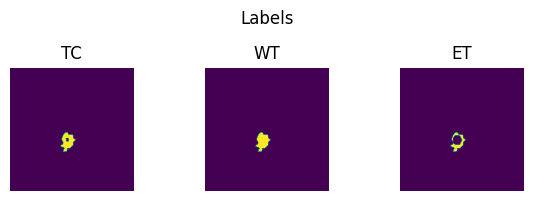

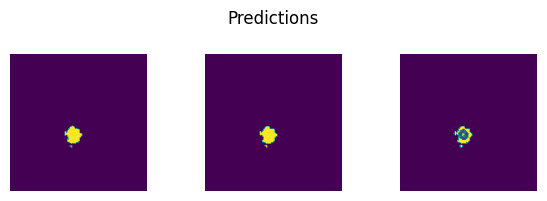

epoch 86
   average train loss: 0.2472
   average validation loss: 0.8810
   saved as best model: False
   current mean dice: 0.5222
   current TC dice: 0.5562
   current WT dice: 0.5623
   current ET dice: 0.4895
Best Mean Metric: 0.5436
time consuming of epoch 86 is: 1609.9209
----------
epoch 87/100
TRAIN
   Batch 1/248, train_loss: 0.0829, step time: 1.0267
   Batch 2/248, train_loss: 0.6295, step time: 1.0316
   Batch 3/248, train_loss: 0.3067, step time: 1.0315
   Batch 4/248, train_loss: 0.9446, step time: 1.0530
   Batch 5/248, train_loss: 0.1857, step time: 1.0443
   Batch 6/248, train_loss: 0.2309, step time: 1.0495
   Batch 7/248, train_loss: 0.0702, step time: 1.0302
   Batch 8/248, train_loss: 0.5318, step time: 1.0340
   Batch 9/248, train_loss: 0.0468, step time: 1.0239
   Batch 10/248, train_loss: 0.2508, step time: 1.0231
   Batch 11/248, train_loss: 0.1912, step time: 1.0419
   Batch 12/248, train_loss: 0.2913, step time: 1.0545
   Batch 13/248, train_loss: 0.2729, st

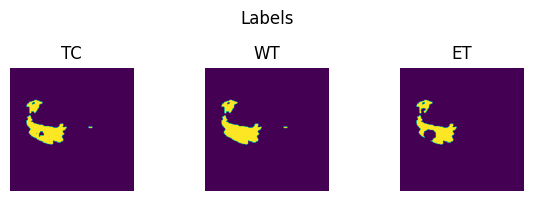

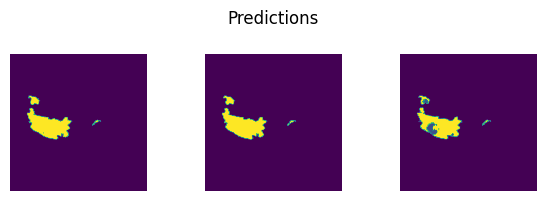

VAL
   Batch 1/31, val_loss: 0.8167
   Batch 2/31, val_loss: 0.8362
   Batch 3/31, val_loss: 0.9553
   Batch 4/31, val_loss: 0.9378
   Batch 5/31, val_loss: 0.9782
   Batch 6/31, val_loss: 0.6674
   Batch 7/31, val_loss: 0.8245
   Batch 8/31, val_loss: 0.9420
   Batch 9/31, val_loss: 0.6788
   Batch 10/31, val_loss: 0.9650
   Batch 11/31, val_loss: 0.7708
   Batch 12/31, val_loss: 0.9622
   Batch 13/31, val_loss: 0.9549
   Batch 14/31, val_loss: 0.9339
   Batch 15/31, val_loss: 0.9809
   Batch 16/31, val_loss: 0.9213
   Batch 17/31, val_loss: 0.9548
   Batch 18/31, val_loss: 0.9191
   Batch 19/31, val_loss: 0.7263
   Batch 20/31, val_loss: 0.8743
   Batch 21/31, val_loss: 0.9383
   Batch 22/31, val_loss: 0.9694
   Batch 23/31, val_loss: 0.9571
   Batch 24/31, val_loss: 0.7195
   Batch 25/31, val_loss: 0.7620
   Batch 26/31, val_loss: 0.8725
   Batch 27/31, val_loss: 0.9676
   Batch 28/31, val_loss: 0.7323
   Batch 29/31, val_loss: 0.9750
   Batch 30/31, val_loss: 0.9480
   Batch 31/31,

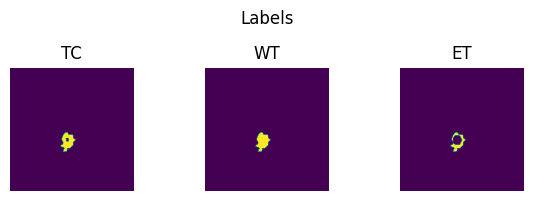

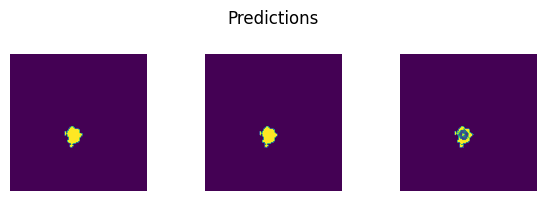

epoch 87
   average train loss: 0.2515
   average validation loss: 0.8838
   saved as best model: False
   current mean dice: 0.5024
   current TC dice: 0.5339
   current WT dice: 0.5359
   current ET dice: 0.4697
Best Mean Metric: 0.5436
time consuming of epoch 87 is: 1637.2152
----------
epoch 88/100
TRAIN
   Batch 1/248, train_loss: 0.0941, step time: 1.0506
   Batch 2/248, train_loss: 0.7547, step time: 1.0361
   Batch 3/248, train_loss: 0.3140, step time: 1.0490
   Batch 4/248, train_loss: 0.9994, step time: 1.0464
   Batch 5/248, train_loss: 0.2340, step time: 1.0322
   Batch 6/248, train_loss: 0.2364, step time: 1.0402
   Batch 7/248, train_loss: 0.0722, step time: 1.0442
   Batch 8/248, train_loss: 0.5136, step time: 1.0397
   Batch 9/248, train_loss: 0.0465, step time: 1.0495
   Batch 10/248, train_loss: 0.2624, step time: 1.0344
   Batch 11/248, train_loss: 0.2187, step time: 1.0255
   Batch 12/248, train_loss: 0.3169, step time: 1.0321
   Batch 13/248, train_loss: 0.2929, st

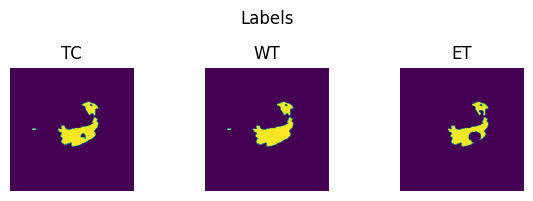

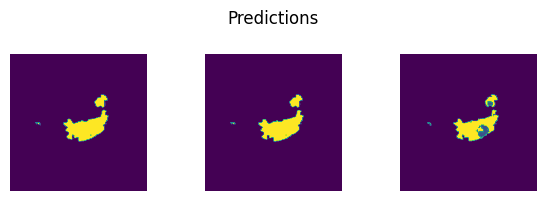

VAL
   Batch 1/31, val_loss: 0.8143
   Batch 2/31, val_loss: 0.8359
   Batch 3/31, val_loss: 0.9586
   Batch 4/31, val_loss: 0.9370
   Batch 5/31, val_loss: 0.9785
   Batch 6/31, val_loss: 0.6686
   Batch 7/31, val_loss: 0.8120
   Batch 8/31, val_loss: 0.9518
   Batch 9/31, val_loss: 0.6789
   Batch 10/31, val_loss: 0.9176
   Batch 11/31, val_loss: 0.7700
   Batch 12/31, val_loss: 0.9589
   Batch 13/31, val_loss: 0.9187
   Batch 14/31, val_loss: 0.9275
   Batch 15/31, val_loss: 0.9815
   Batch 16/31, val_loss: 0.9224
   Batch 17/31, val_loss: 0.9562
   Batch 18/31, val_loss: 0.9218
   Batch 19/31, val_loss: 0.7284
   Batch 20/31, val_loss: 0.8442
   Batch 21/31, val_loss: 0.9409
   Batch 22/31, val_loss: 0.9713
   Batch 23/31, val_loss: 0.9533
   Batch 24/31, val_loss: 0.7187
   Batch 25/31, val_loss: 0.7586
   Batch 26/31, val_loss: 0.8711
   Batch 27/31, val_loss: 0.9690
   Batch 28/31, val_loss: 0.7327
   Batch 29/31, val_loss: 0.9762
   Batch 30/31, val_loss: 0.9619
   Batch 31/31,

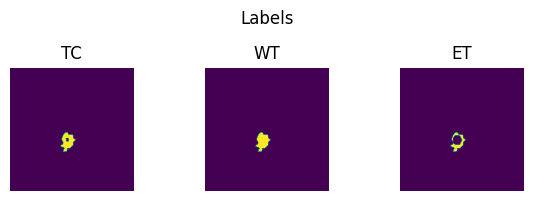

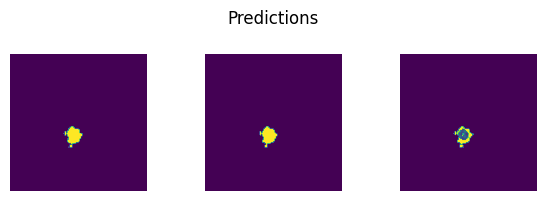

epoch 88
   average train loss: 0.2567
   average validation loss: 0.8804
   saved as best model: False
   current mean dice: 0.5235
   current TC dice: 0.5561
   current WT dice: 0.5572
   current ET dice: 0.4974
Best Mean Metric: 0.5436
time consuming of epoch 88 is: 1627.4372
----------
epoch 89/100
TRAIN
   Batch 1/248, train_loss: 0.0783, step time: 1.0417
   Batch 2/248, train_loss: 0.6718, step time: 1.0402
   Batch 3/248, train_loss: 0.3093, step time: 1.0293
   Batch 4/248, train_loss: 0.9791, step time: 1.0190
   Batch 5/248, train_loss: 0.2107, step time: 1.0324
   Batch 6/248, train_loss: 0.1763, step time: 1.0505
   Batch 7/248, train_loss: 0.0698, step time: 1.0495
   Batch 8/248, train_loss: 0.4908, step time: 1.0358
   Batch 9/248, train_loss: 0.0475, step time: 1.0462
   Batch 10/248, train_loss: 0.2427, step time: 1.0336
   Batch 11/248, train_loss: 0.1874, step time: 1.0504
   Batch 12/248, train_loss: 0.3116, step time: 1.0385
   Batch 13/248, train_loss: 0.2646, st

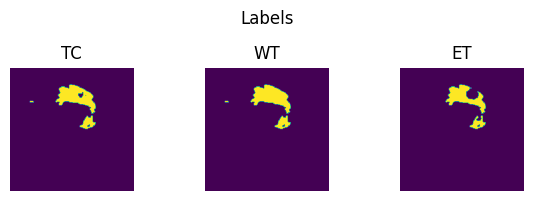

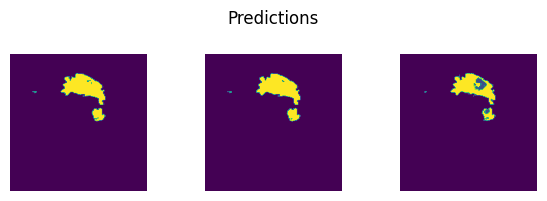

VAL
   Batch 1/31, val_loss: 0.8092
   Batch 2/31, val_loss: 0.8252
   Batch 3/31, val_loss: 0.9518
   Batch 4/31, val_loss: 0.9323
   Batch 5/31, val_loss: 0.9750
   Batch 6/31, val_loss: 0.6651
   Batch 7/31, val_loss: 0.8095
   Batch 8/31, val_loss: 0.9452
   Batch 9/31, val_loss: 0.6752
   Batch 10/31, val_loss: 0.9052
   Batch 11/31, val_loss: 0.7604
   Batch 12/31, val_loss: 0.9564
   Batch 13/31, val_loss: 0.9111
   Batch 14/31, val_loss: 0.9254
   Batch 15/31, val_loss: 0.9772
   Batch 16/31, val_loss: 0.9143
   Batch 17/31, val_loss: 0.9539
   Batch 18/31, val_loss: 0.9170
   Batch 19/31, val_loss: 0.7260
   Batch 20/31, val_loss: 0.8398
   Batch 21/31, val_loss: 0.9390
   Batch 22/31, val_loss: 0.9687
   Batch 23/31, val_loss: 0.9482
   Batch 24/31, val_loss: 0.7188
   Batch 25/31, val_loss: 0.7530
   Batch 26/31, val_loss: 0.8624
   Batch 27/31, val_loss: 0.9665
   Batch 28/31, val_loss: 0.7280
   Batch 29/31, val_loss: 0.9733
   Batch 30/31, val_loss: 0.9498
   Batch 31/31,

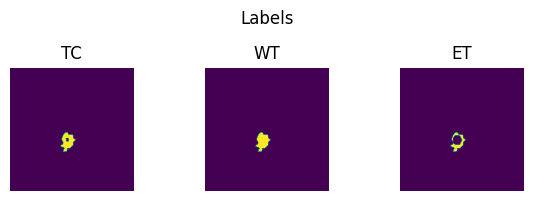

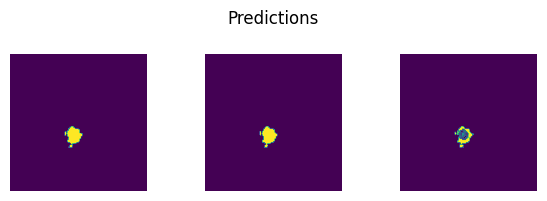

epoch 89
   average train loss: 0.2448
   average validation loss: 0.8753
   saved as best model: False
   current mean dice: 0.5322
   current TC dice: 0.5675
   current WT dice: 0.5673
   current ET dice: 0.5017
Best Mean Metric: 0.5436
time consuming of epoch 89 is: 1632.9258
----------
epoch 90/100
TRAIN
   Batch 1/248, train_loss: 0.0821, step time: 1.0559
   Batch 2/248, train_loss: 0.6994, step time: 1.0344
   Batch 3/248, train_loss: 0.2944, step time: 1.0215
   Batch 4/248, train_loss: 0.9958, step time: 1.0281
   Batch 5/248, train_loss: 0.2331, step time: 1.0213
   Batch 6/248, train_loss: 0.1781, step time: 1.0307
   Batch 7/248, train_loss: 0.0666, step time: 1.0482
   Batch 8/248, train_loss: 0.5429, step time: 1.0225
   Batch 9/248, train_loss: 0.0483, step time: 1.0214
   Batch 10/248, train_loss: 0.2408, step time: 1.0516
   Batch 11/248, train_loss: 0.1732, step time: 1.0453
   Batch 12/248, train_loss: 0.3232, step time: 1.0218
   Batch 13/248, train_loss: 0.2833, st

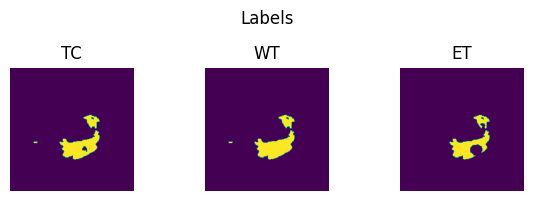

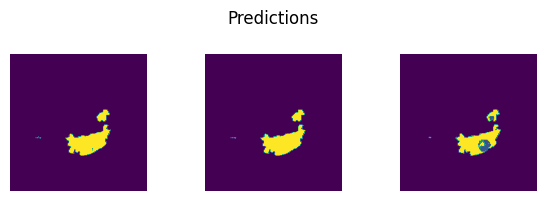

VAL
   Batch 1/31, val_loss: 0.8102
   Batch 2/31, val_loss: 0.8325
   Batch 3/31, val_loss: 0.9533
   Batch 4/31, val_loss: 0.9309
   Batch 5/31, val_loss: 0.9744
   Batch 6/31, val_loss: 0.6626
   Batch 7/31, val_loss: 0.8048
   Batch 8/31, val_loss: 0.9492
   Batch 9/31, val_loss: 0.6743
   Batch 10/31, val_loss: 0.9213
   Batch 11/31, val_loss: 0.7546
   Batch 12/31, val_loss: 0.9570
   Batch 13/31, val_loss: 0.9046
   Batch 14/31, val_loss: 0.9263
   Batch 15/31, val_loss: 0.9771
   Batch 16/31, val_loss: 0.9110
   Batch 17/31, val_loss: 0.9560
   Batch 18/31, val_loss: 0.9167
   Batch 19/31, val_loss: 0.7240
   Batch 20/31, val_loss: 0.8404
   Batch 21/31, val_loss: 0.9380
   Batch 22/31, val_loss: 0.9658
   Batch 23/31, val_loss: 0.9439
   Batch 24/31, val_loss: 0.7162
   Batch 25/31, val_loss: 0.7472
   Batch 26/31, val_loss: 0.8605
   Batch 27/31, val_loss: 0.9680
   Batch 28/31, val_loss: 0.7288
   Batch 29/31, val_loss: 0.9728
   Batch 30/31, val_loss: 0.9530
   Batch 31/31,

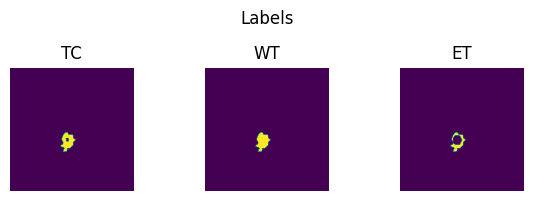

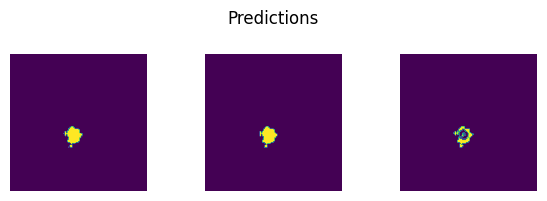

epoch 90
   average train loss: 0.2440
   average validation loss: 0.8750
   saved as best model: False
   current mean dice: 0.5276
   current TC dice: 0.5649
   current WT dice: 0.5667
   current ET dice: 0.4921
Best Mean Metric: 0.5436
time consuming of epoch 90 is: 1631.6859
----------
epoch 91/100
TRAIN
   Batch 1/248, train_loss: 0.0790, step time: 1.0310
   Batch 2/248, train_loss: 0.6647, step time: 1.0332
   Batch 3/248, train_loss: 0.2994, step time: 1.0346
   Batch 4/248, train_loss: 0.9671, step time: 1.0434
   Batch 5/248, train_loss: 0.2059, step time: 1.0422
   Batch 6/248, train_loss: 0.1915, step time: 1.0270
   Batch 7/248, train_loss: 0.0673, step time: 1.0317
   Batch 8/248, train_loss: 0.5072, step time: 1.0302
   Batch 9/248, train_loss: 0.0462, step time: 1.0482
   Batch 10/248, train_loss: 0.2343, step time: 1.0576
   Batch 11/248, train_loss: 0.1680, step time: 1.0356
   Batch 12/248, train_loss: 0.3361, step time: 1.0496
   Batch 13/248, train_loss: 0.2777, st

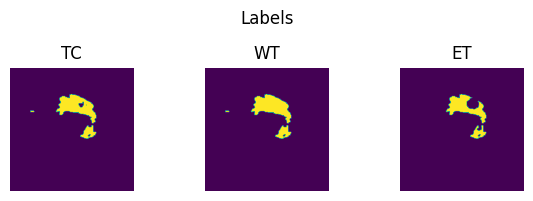

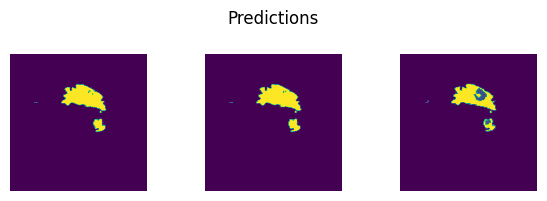

VAL
   Batch 1/31, val_loss: 0.8042
   Batch 2/31, val_loss: 0.8147
   Batch 3/31, val_loss: 0.9501
   Batch 4/31, val_loss: 0.9267
   Batch 5/31, val_loss: 0.9701
   Batch 6/31, val_loss: 0.6596
   Batch 7/31, val_loss: 0.8018
   Batch 8/31, val_loss: 0.9488
   Batch 9/31, val_loss: 0.6700
   Batch 10/31, val_loss: 0.9150
   Batch 11/31, val_loss: 0.7479
   Batch 12/31, val_loss: 0.9545
   Batch 13/31, val_loss: 0.8989
   Batch 14/31, val_loss: 0.9236
   Batch 15/31, val_loss: 0.9734
   Batch 16/31, val_loss: 0.9039
   Batch 17/31, val_loss: 0.9511
   Batch 18/31, val_loss: 0.9132
   Batch 19/31, val_loss: 0.7213
   Batch 20/31, val_loss: 0.8277
   Batch 21/31, val_loss: 0.9351
   Batch 22/31, val_loss: 0.9640
   Batch 23/31, val_loss: 0.9408
   Batch 24/31, val_loss: 0.7159
   Batch 25/31, val_loss: 0.7429
   Batch 26/31, val_loss: 0.8517
   Batch 27/31, val_loss: 0.9656
   Batch 28/31, val_loss: 0.7263
   Batch 29/31, val_loss: 0.9709
   Batch 30/31, val_loss: 0.9476
   Batch 31/31,

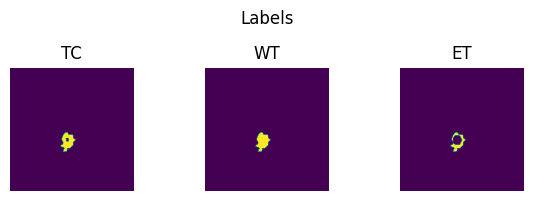

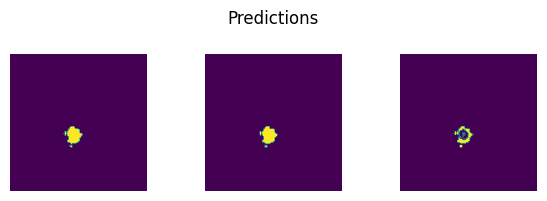

epoch 91
   average train loss: 0.2381
   average validation loss: 0.8705
   saved as best model: False
   current mean dice: 0.5268
   current TC dice: 0.5631
   current WT dice: 0.5631
   current ET dice: 0.4946
Best Mean Metric: 0.5436
time consuming of epoch 91 is: 1667.8359
----------
epoch 92/100
TRAIN
   Batch 1/248, train_loss: 0.0839, step time: 1.0450
   Batch 2/248, train_loss: 0.6534, step time: 1.0420
   Batch 3/248, train_loss: 0.2821, step time: 1.0327
   Batch 4/248, train_loss: 0.9494, step time: 1.0441
   Batch 5/248, train_loss: 0.1779, step time: 1.0418
   Batch 6/248, train_loss: 0.1977, step time: 1.0410
   Batch 7/248, train_loss: 0.0656, step time: 1.0295
   Batch 8/248, train_loss: 0.4915, step time: 1.0457
   Batch 9/248, train_loss: 0.0463, step time: 1.0326
   Batch 10/248, train_loss: 0.2534, step time: 1.0548
   Batch 11/248, train_loss: 0.1707, step time: 1.0483
   Batch 12/248, train_loss: 0.3233, step time: 1.0500
   Batch 13/248, train_loss: 0.2853, st

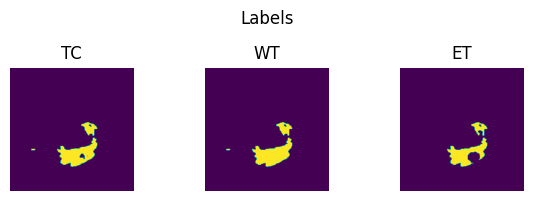

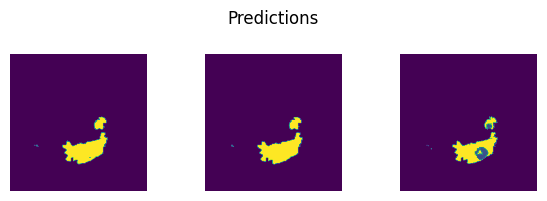

VAL
   Batch 1/31, val_loss: 0.8048
   Batch 2/31, val_loss: 0.8255
   Batch 3/31, val_loss: 0.9482
   Batch 4/31, val_loss: 0.9255
   Batch 5/31, val_loss: 0.9697
   Batch 6/31, val_loss: 0.6558
   Batch 7/31, val_loss: 0.7991
   Batch 8/31, val_loss: 0.9364
   Batch 9/31, val_loss: 0.6670
   Batch 10/31, val_loss: 0.9020
   Batch 11/31, val_loss: 0.7457
   Batch 12/31, val_loss: 0.9546
   Batch 13/31, val_loss: 0.8972
   Batch 14/31, val_loss: 0.9220
   Batch 15/31, val_loss: 0.9723
   Batch 16/31, val_loss: 0.9045
   Batch 17/31, val_loss: 0.9496
   Batch 18/31, val_loss: 0.9079
   Batch 19/31, val_loss: 0.7185
   Batch 20/31, val_loss: 0.8291
   Batch 21/31, val_loss: 0.9344
   Batch 22/31, val_loss: 0.9523
   Batch 23/31, val_loss: 0.9388
   Batch 24/31, val_loss: 0.7106
   Batch 25/31, val_loss: 0.7396
   Batch 26/31, val_loss: 0.8554
   Batch 27/31, val_loss: 0.9647
   Batch 28/31, val_loss: 0.7245
   Batch 29/31, val_loss: 0.9700
   Batch 30/31, val_loss: 0.9439
   Batch 31/31,

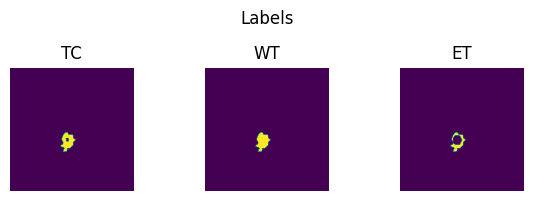

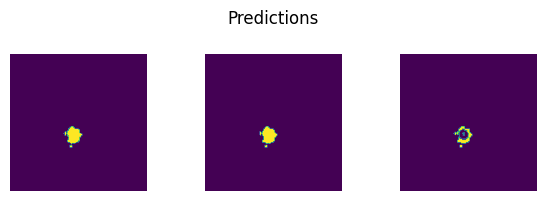

epoch 92
   average train loss: 0.2371
   average validation loss: 0.8682
   saved as best model: True
   current mean dice: 0.5454
   current TC dice: 0.5821
   current WT dice: 0.5828
   current ET dice: 0.5151
Best Mean Metric: 0.5454
time consuming of epoch 92 is: 1660.4149
----------
epoch 93/100
TRAIN
   Batch 1/248, train_loss: 0.0765, step time: 1.0533
   Batch 2/248, train_loss: 0.6600, step time: 1.0486
   Batch 3/248, train_loss: 0.2652, step time: 1.0496
   Batch 4/248, train_loss: 0.9387, step time: 1.0410
   Batch 5/248, train_loss: 0.1846, step time: 1.0479
   Batch 6/248, train_loss: 0.1960, step time: 1.0345
   Batch 7/248, train_loss: 0.0661, step time: 1.0405
   Batch 8/248, train_loss: 0.4567, step time: 1.0286
   Batch 9/248, train_loss: 0.0459, step time: 1.0356
   Batch 10/248, train_loss: 0.2484, step time: 1.0383
   Batch 11/248, train_loss: 0.1653, step time: 1.0396
   Batch 12/248, train_loss: 0.3060, step time: 1.0389
   Batch 13/248, train_loss: 0.2612, ste

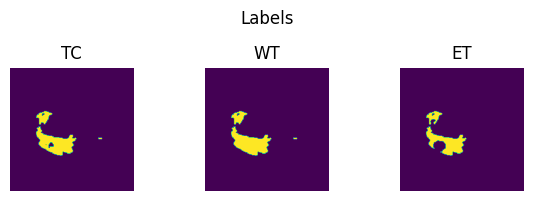

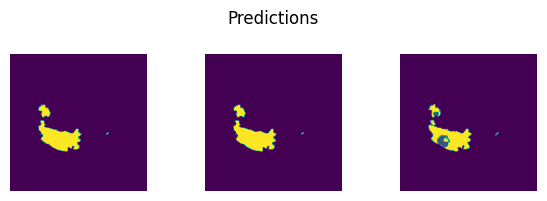

VAL
   Batch 1/31, val_loss: 0.7984
   Batch 2/31, val_loss: 0.8084
   Batch 3/31, val_loss: 0.9483
   Batch 4/31, val_loss: 0.9218
   Batch 5/31, val_loss: 0.9616
   Batch 6/31, val_loss: 0.6514
   Batch 7/31, val_loss: 0.8076
   Batch 8/31, val_loss: 0.9424
   Batch 9/31, val_loss: 0.6646
   Batch 10/31, val_loss: 0.9201
   Batch 11/31, val_loss: 0.7299
   Batch 12/31, val_loss: 0.9464
   Batch 13/31, val_loss: 0.8837
   Batch 14/31, val_loss: 0.9144
   Batch 15/31, val_loss: 0.9660
   Batch 16/31, val_loss: 0.8869
   Batch 17/31, val_loss: 0.9430
   Batch 18/31, val_loss: 0.9054
   Batch 19/31, val_loss: 0.7186
   Batch 20/31, val_loss: 0.8333
   Batch 21/31, val_loss: 0.9178
   Batch 22/31, val_loss: 0.9610
   Batch 23/31, val_loss: 0.9344
   Batch 24/31, val_loss: 0.7080
   Batch 25/31, val_loss: 0.7257
   Batch 26/31, val_loss: 0.8354
   Batch 27/31, val_loss: 0.9602
   Batch 28/31, val_loss: 0.7199
   Batch 29/31, val_loss: 0.9653
   Batch 30/31, val_loss: 0.9402
   Batch 31/31,

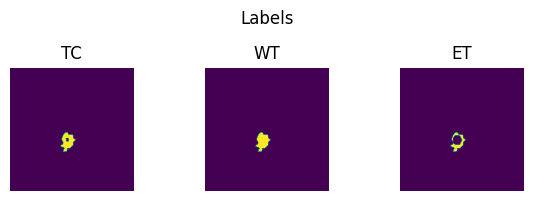

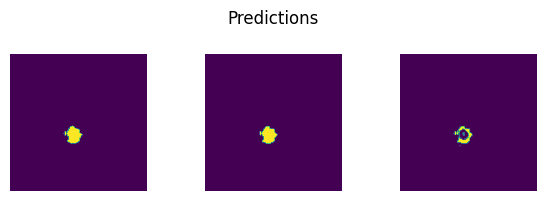

epoch 93
   average train loss: 0.2335
   average validation loss: 0.8632
   saved as best model: False
   current mean dice: 0.5177
   current TC dice: 0.5462
   current WT dice: 0.5515
   current ET dice: 0.4995
Best Mean Metric: 0.5454
time consuming of epoch 93 is: 1636.1625
----------
epoch 94/100
TRAIN
   Batch 1/248, train_loss: 0.0793, step time: 1.0179
   Batch 2/248, train_loss: 0.6736, step time: 1.0201
   Batch 3/248, train_loss: 0.3583, step time: 1.0167
   Batch 4/248, train_loss: 0.8884, step time: 1.0258
   Batch 5/248, train_loss: 0.1810, step time: 1.0185
   Batch 6/248, train_loss: 0.1759, step time: 1.0297
   Batch 7/248, train_loss: 0.0669, step time: 1.0062
   Batch 8/248, train_loss: 0.4853, step time: 1.0176
   Batch 9/248, train_loss: 0.0465, step time: 1.0217
   Batch 10/248, train_loss: 0.2579, step time: 1.0146
   Batch 11/248, train_loss: 0.1733, step time: 1.0208
   Batch 12/248, train_loss: 0.2907, step time: 1.0212
   Batch 13/248, train_loss: 0.2768, st

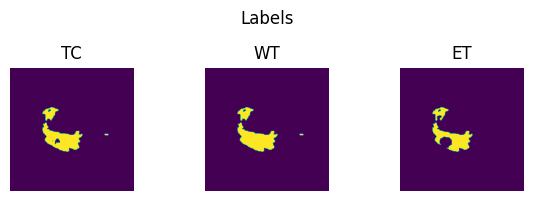

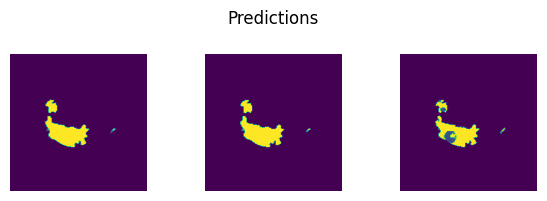

VAL
   Batch 1/31, val_loss: 0.7990
   Batch 2/31, val_loss: 0.8217
   Batch 3/31, val_loss: 0.9458
   Batch 4/31, val_loss: 0.9272
   Batch 5/31, val_loss: 0.9643
   Batch 6/31, val_loss: 0.6534
   Batch 7/31, val_loss: 0.8039
   Batch 8/31, val_loss: 0.9408
   Batch 9/31, val_loss: 0.6633
   Batch 10/31, val_loss: 0.8951
   Batch 11/31, val_loss: 0.7317
   Batch 12/31, val_loss: 0.9495
   Batch 13/31, val_loss: 0.8866
   Batch 14/31, val_loss: 0.9182
   Batch 15/31, val_loss: 0.9703
   Batch 16/31, val_loss: 0.8896
   Batch 17/31, val_loss: 0.9372
   Batch 18/31, val_loss: 0.9069
   Batch 19/31, val_loss: 0.7144
   Batch 20/31, val_loss: 0.8373
   Batch 21/31, val_loss: 0.9270
   Batch 22/31, val_loss: 0.9603
   Batch 23/31, val_loss: 0.9329
   Batch 24/31, val_loss: 0.7085
   Batch 25/31, val_loss: 0.7269
   Batch 26/31, val_loss: 0.8408
   Batch 27/31, val_loss: 0.9580
   Batch 28/31, val_loss: 0.7194
   Batch 29/31, val_loss: 0.9663
   Batch 30/31, val_loss: 0.9408
   Batch 31/31,

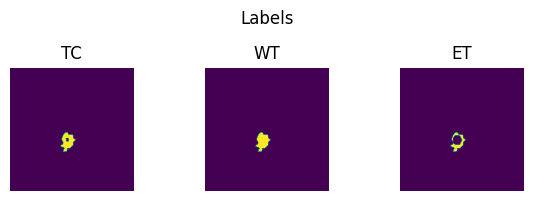

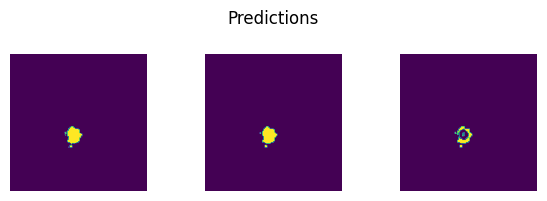

epoch 94
   average train loss: 0.2435
   average validation loss: 0.8639
   saved as best model: False
   current mean dice: 0.5286
   current TC dice: 0.5624
   current WT dice: 0.5661
   current ET dice: 0.5016
Best Mean Metric: 0.5454
time consuming of epoch 94 is: 1660.3264
----------
epoch 95/100
TRAIN
   Batch 1/248, train_loss: 0.0774, step time: 1.0296
   Batch 2/248, train_loss: 0.5967, step time: 1.0276
   Batch 3/248, train_loss: 0.2821, step time: 1.0231
   Batch 4/248, train_loss: 0.9079, step time: 1.0292
   Batch 5/248, train_loss: 0.1873, step time: 1.0285
   Batch 6/248, train_loss: 0.1649, step time: 1.0234
   Batch 7/248, train_loss: 0.0659, step time: 1.0186
   Batch 8/248, train_loss: 0.5825, step time: 1.0298
   Batch 9/248, train_loss: 0.0453, step time: 1.0189
   Batch 10/248, train_loss: 0.2148, step time: 1.0307
   Batch 11/248, train_loss: 0.1689, step time: 1.0292
   Batch 12/248, train_loss: 0.3555, step time: 1.0247
   Batch 13/248, train_loss: 0.2596, st

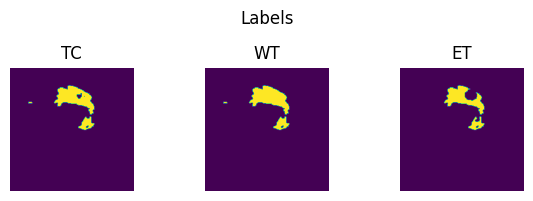

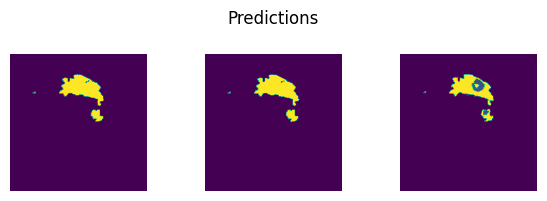

VAL
   Batch 1/31, val_loss: 0.8077
   Batch 2/31, val_loss: 0.8136
   Batch 3/31, val_loss: 0.9465
   Batch 4/31, val_loss: 0.9193
   Batch 5/31, val_loss: 0.9592
   Batch 6/31, val_loss: 0.6438
   Batch 7/31, val_loss: 0.7867
   Batch 8/31, val_loss: 0.9194
   Batch 9/31, val_loss: 0.6580
   Batch 10/31, val_loss: 0.9309
   Batch 11/31, val_loss: 0.7133
   Batch 12/31, val_loss: 0.9446
   Batch 13/31, val_loss: 0.8889
   Batch 14/31, val_loss: 0.9125
   Batch 15/31, val_loss: 0.9639
   Batch 16/31, val_loss: 0.8722
   Batch 17/31, val_loss: 0.9335
   Batch 18/31, val_loss: 0.8939
   Batch 19/31, val_loss: 0.7034
   Batch 20/31, val_loss: 0.8310
   Batch 21/31, val_loss: 0.9250
   Batch 22/31, val_loss: 0.9538
   Batch 23/31, val_loss: 0.9237
   Batch 24/31, val_loss: 0.7059
   Batch 25/31, val_loss: 0.7085
   Batch 26/31, val_loss: 0.8196
   Batch 27/31, val_loss: 0.9558
   Batch 28/31, val_loss: 0.7421
   Batch 29/31, val_loss: 0.9614
   Batch 30/31, val_loss: 0.9343
   Batch 31/31,

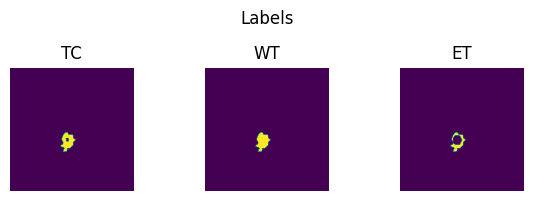

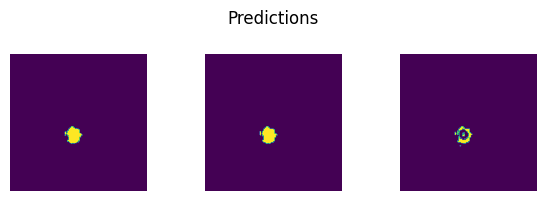

epoch 95
   average train loss: 0.2438
   average validation loss: 0.8582
   saved as best model: False
   current mean dice: 0.5197
   current TC dice: 0.5545
   current WT dice: 0.5546
   current ET dice: 0.4853
Best Mean Metric: 0.5454
time consuming of epoch 95 is: 1666.6726
----------
epoch 96/100
TRAIN
   Batch 1/248, train_loss: 0.0920, step time: 1.0458
   Batch 2/248, train_loss: 0.7069, step time: 1.0589
   Batch 3/248, train_loss: 0.2829, step time: 1.0441
   Batch 4/248, train_loss: 0.9494, step time: 1.0347
   Batch 5/248, train_loss: 0.1806, step time: 1.0352
   Batch 6/248, train_loss: 0.1849, step time: 1.0415
   Batch 7/248, train_loss: 0.0691, step time: 1.0356
   Batch 8/248, train_loss: 0.5297, step time: 1.0370
   Batch 9/248, train_loss: 0.0479, step time: 1.0288
   Batch 10/248, train_loss: 0.2242, step time: 1.0287
   Batch 11/248, train_loss: 0.1789, step time: 1.0337
   Batch 12/248, train_loss: 0.2986, step time: 1.0486
   Batch 13/248, train_loss: 0.2791, st

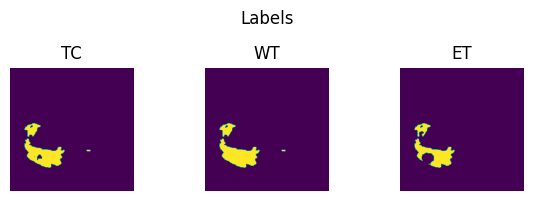

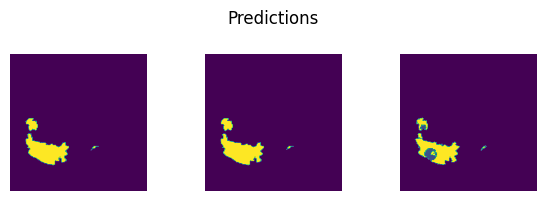

VAL
   Batch 1/31, val_loss: 0.7846
   Batch 2/31, val_loss: 0.8144
   Batch 3/31, val_loss: 0.9358
   Batch 4/31, val_loss: 0.9066
   Batch 5/31, val_loss: 0.9493
   Batch 6/31, val_loss: 0.6336
   Batch 7/31, val_loss: 0.7788
   Batch 8/31, val_loss: 0.9090
   Batch 9/31, val_loss: 0.6488
   Batch 10/31, val_loss: 0.8873
   Batch 11/31, val_loss: 0.6957
   Batch 12/31, val_loss: 0.9357
   Batch 13/31, val_loss: 0.8564
   Batch 14/31, val_loss: 0.9016
   Batch 15/31, val_loss: 0.9547
   Batch 16/31, val_loss: 0.8564
   Batch 17/31, val_loss: 0.9205
   Batch 18/31, val_loss: 0.8832
   Batch 19/31, val_loss: 0.6914
   Batch 20/31, val_loss: 0.8165
   Batch 21/31, val_loss: 0.9145
   Batch 22/31, val_loss: 0.9414
   Batch 23/31, val_loss: 0.9121
   Batch 24/31, val_loss: 0.6906
   Batch 25/31, val_loss: 0.6937
   Batch 26/31, val_loss: 0.8027
   Batch 27/31, val_loss: 0.9429
   Batch 28/31, val_loss: 0.7073
   Batch 29/31, val_loss: 0.9530
   Batch 30/31, val_loss: 0.9209
   Batch 31/31,

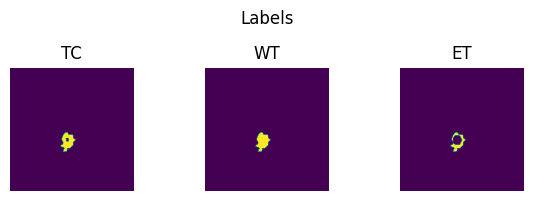

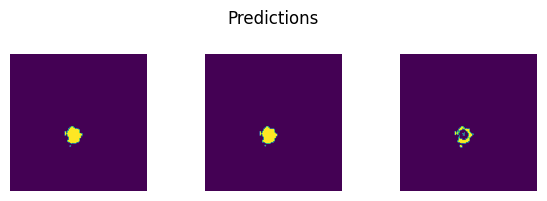

epoch 96
   average train loss: 0.2299
   average validation loss: 0.8439
   saved as best model: False
   current mean dice: 0.5395
   current TC dice: 0.5778
   current WT dice: 0.5816
   current ET dice: 0.5021
Best Mean Metric: 0.5454
time consuming of epoch 96 is: 1661.1540
----------
epoch 97/100
TRAIN
   Batch 1/248, train_loss: 0.0868, step time: 1.0166
   Batch 2/248, train_loss: 0.6592, step time: 1.0059
   Batch 3/248, train_loss: 0.3162, step time: 1.0078
   Batch 4/248, train_loss: 0.8937, step time: 1.0188
   Batch 5/248, train_loss: 0.1737, step time: 1.0267
   Batch 6/248, train_loss: 0.1724, step time: 1.0110
   Batch 7/248, train_loss: 0.0638, step time: 1.0221
   Batch 8/248, train_loss: 0.4927, step time: 1.0288
   Batch 9/248, train_loss: 0.0451, step time: 1.0211
   Batch 10/248, train_loss: 0.2405, step time: 1.0180
   Batch 11/248, train_loss: 0.1647, step time: 1.0085
   Batch 12/248, train_loss: 0.2753, step time: 1.0081
   Batch 13/248, train_loss: 0.2860, st

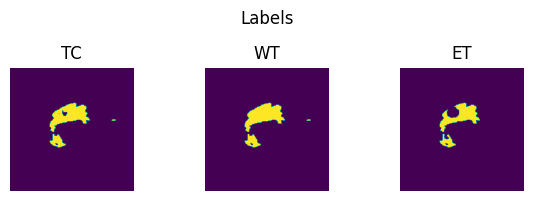

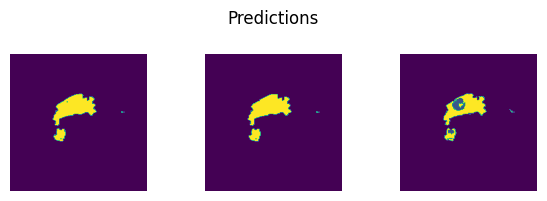

VAL
   Batch 1/31, val_loss: 0.7901
   Batch 2/31, val_loss: 0.8120
   Batch 3/31, val_loss: 0.9375
   Batch 4/31, val_loss: 0.9103
   Batch 5/31, val_loss: 0.9492
   Batch 6/31, val_loss: 0.6348
   Batch 7/31, val_loss: 0.7773
   Batch 8/31, val_loss: 0.9135
   Batch 9/31, val_loss: 0.6477
   Batch 10/31, val_loss: 0.8915
   Batch 11/31, val_loss: 0.6986
   Batch 12/31, val_loss: 0.9379
   Batch 13/31, val_loss: 0.8591
   Batch 14/31, val_loss: 0.9053
   Batch 15/31, val_loss: 0.9540
   Batch 16/31, val_loss: 0.8606
   Batch 17/31, val_loss: 0.9220
   Batch 18/31, val_loss: 0.8842
   Batch 19/31, val_loss: 0.6936
   Batch 20/31, val_loss: 0.8200
   Batch 21/31, val_loss: 0.9135
   Batch 22/31, val_loss: 0.9387
   Batch 23/31, val_loss: 0.9141
   Batch 24/31, val_loss: 0.6920
   Batch 25/31, val_loss: 0.6961
   Batch 26/31, val_loss: 0.8059
   Batch 27/31, val_loss: 0.9480
   Batch 28/31, val_loss: 0.7102
   Batch 29/31, val_loss: 0.9543
   Batch 30/31, val_loss: 0.9275
   Batch 31/31,

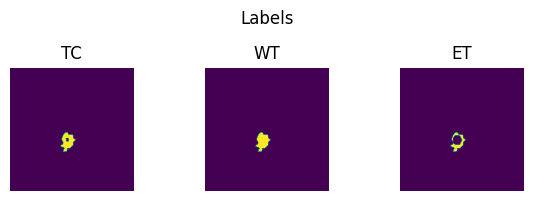

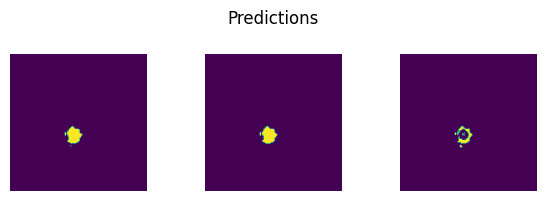

epoch 97
   average train loss: 0.2303
   average validation loss: 0.8459
   saved as best model: False
   current mean dice: 0.5228
   current TC dice: 0.5647
   current WT dice: 0.5642
   current ET dice: 0.4846
Best Mean Metric: 0.5454
time consuming of epoch 97 is: 1646.0587
----------
epoch 98/100
TRAIN
   Batch 1/248, train_loss: 0.0763, step time: 1.0199
   Batch 2/248, train_loss: 0.5912, step time: 1.0356
   Batch 3/248, train_loss: 0.2569, step time: 1.0225
   Batch 4/248, train_loss: 0.9279, step time: 1.0243
   Batch 5/248, train_loss: 0.1767, step time: 1.0086
   Batch 6/248, train_loss: 0.1605, step time: 1.0172
   Batch 7/248, train_loss: 0.0664, step time: 1.0242
   Batch 8/248, train_loss: 0.4507, step time: 1.0262
   Batch 9/248, train_loss: 0.0439, step time: 1.0088
   Batch 10/248, train_loss: 0.2416, step time: 1.0180
   Batch 11/248, train_loss: 0.1633, step time: 1.0181
   Batch 12/248, train_loss: 0.2837, step time: 1.0049
   Batch 13/248, train_loss: 0.2614, st

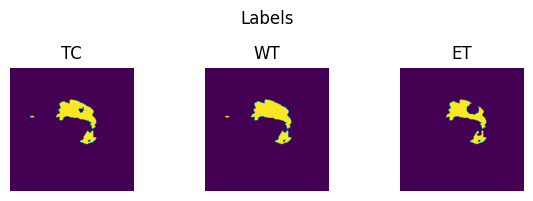

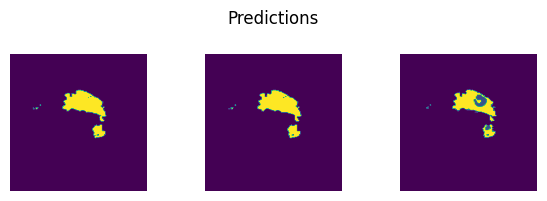

VAL
   Batch 1/31, val_loss: 0.7841
   Batch 2/31, val_loss: 0.8133
   Batch 3/31, val_loss: 0.9298
   Batch 4/31, val_loss: 0.9034
   Batch 5/31, val_loss: 0.9456
   Batch 6/31, val_loss: 0.6299
   Batch 7/31, val_loss: 0.7754
   Batch 8/31, val_loss: 0.9020
   Batch 9/31, val_loss: 0.6451
   Batch 10/31, val_loss: 0.8740
   Batch 11/31, val_loss: 0.6949
   Batch 12/31, val_loss: 0.9310
   Batch 13/31, val_loss: 0.8539
   Batch 14/31, val_loss: 0.8993
   Batch 15/31, val_loss: 0.9499
   Batch 16/31, val_loss: 0.8561
   Batch 17/31, val_loss: 0.9177
   Batch 18/31, val_loss: 0.8776
   Batch 19/31, val_loss: 0.6884
   Batch 20/31, val_loss: 0.8147
   Batch 21/31, val_loss: 0.9160
   Batch 22/31, val_loss: 0.9300
   Batch 23/31, val_loss: 0.9078
   Batch 24/31, val_loss: 0.6891
   Batch 25/31, val_loss: 0.6912
   Batch 26/31, val_loss: 0.8026
   Batch 27/31, val_loss: 0.9377
   Batch 28/31, val_loss: 0.7036
   Batch 29/31, val_loss: 0.9511
   Batch 30/31, val_loss: 0.9227
   Batch 31/31,

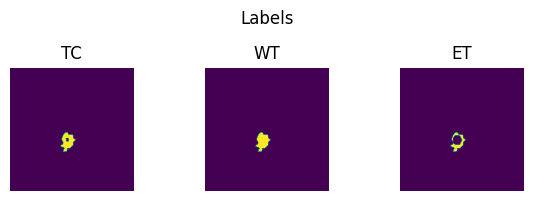

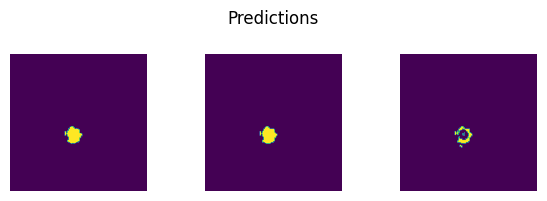

epoch 98
   average train loss: 0.2265
   average validation loss: 0.8405
   saved as best model: False
   current mean dice: 0.5343
   current TC dice: 0.5714
   current WT dice: 0.5728
   current ET dice: 0.5053
Best Mean Metric: 0.5454
time consuming of epoch 98 is: 1636.2128
----------
epoch 99/100
TRAIN
   Batch 1/248, train_loss: 0.0723, step time: 1.0234
   Batch 2/248, train_loss: 0.6098, step time: 1.0192
   Batch 3/248, train_loss: 0.2806, step time: 1.0118
   Batch 4/248, train_loss: 0.9392, step time: 1.0271
   Batch 5/248, train_loss: 0.1780, step time: 1.0193
   Batch 6/248, train_loss: 0.1561, step time: 1.0192
   Batch 7/248, train_loss: 0.0650, step time: 1.0061
   Batch 8/248, train_loss: 0.4550, step time: 1.0306
   Batch 9/248, train_loss: 0.0456, step time: 1.0184
   Batch 10/248, train_loss: 0.2279, step time: 1.0294
   Batch 11/248, train_loss: 0.1616, step time: 1.0069
   Batch 12/248, train_loss: 0.2916, step time: 1.0172
   Batch 13/248, train_loss: 0.2780, st

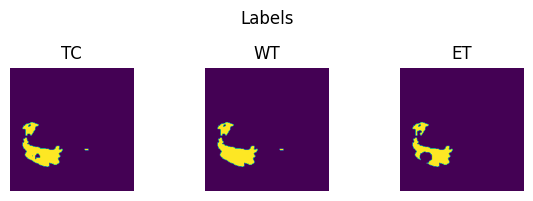

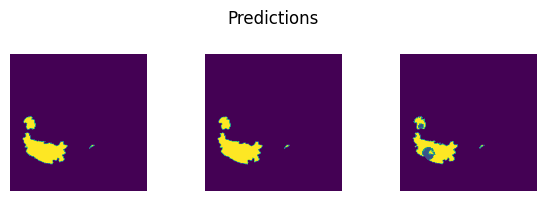

VAL
   Batch 1/31, val_loss: 0.7802
   Batch 2/31, val_loss: 0.8103
   Batch 3/31, val_loss: 0.9282
   Batch 4/31, val_loss: 0.9065
   Batch 5/31, val_loss: 0.9434
   Batch 6/31, val_loss: 0.6300
   Batch 7/31, val_loss: 0.7818
   Batch 8/31, val_loss: 0.9034
   Batch 9/31, val_loss: 0.6422
   Batch 10/31, val_loss: 0.8761
   Batch 11/31, val_loss: 0.6956
   Batch 12/31, val_loss: 0.9300
   Batch 13/31, val_loss: 0.8516
   Batch 14/31, val_loss: 0.8984
   Batch 15/31, val_loss: 0.9481
   Batch 16/31, val_loss: 0.8515
   Batch 17/31, val_loss: 0.9190
   Batch 18/31, val_loss: 0.8758
   Batch 19/31, val_loss: 0.6878
   Batch 20/31, val_loss: 0.8056
   Batch 21/31, val_loss: 0.9151
   Batch 22/31, val_loss: 0.9358
   Batch 23/31, val_loss: 0.9049
   Batch 24/31, val_loss: 0.6887
   Batch 25/31, val_loss: 0.6944
   Batch 26/31, val_loss: 0.7982
   Batch 27/31, val_loss: 0.9380
   Batch 28/31, val_loss: 0.7030
   Batch 29/31, val_loss: 0.9493
   Batch 30/31, val_loss: 0.9205
   Batch 31/31,

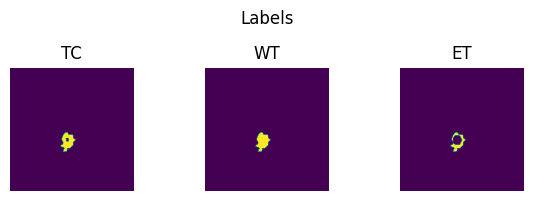

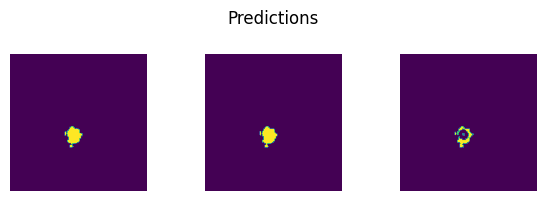

epoch 99
   average train loss: 0.2263
   average validation loss: 0.8397
   saved as best model: False
   current mean dice: 0.5240
   current TC dice: 0.5589
   current WT dice: 0.5607
   current ET dice: 0.4948
Best Mean Metric: 0.5454
time consuming of epoch 99 is: 1642.7718
----------
epoch 100/100
TRAIN
   Batch 1/248, train_loss: 0.0802, step time: 1.0168
   Batch 2/248, train_loss: 0.5738, step time: 1.0191
   Batch 3/248, train_loss: 0.2673, step time: 1.0405
   Batch 4/248, train_loss: 0.8824, step time: 1.0106
   Batch 5/248, train_loss: 0.1729, step time: 1.0165
   Batch 6/248, train_loss: 0.1714, step time: 1.0073
   Batch 7/248, train_loss: 0.0632, step time: 1.0271
   Batch 8/248, train_loss: 0.4649, step time: 1.0187
   Batch 9/248, train_loss: 0.0438, step time: 1.0159
   Batch 10/248, train_loss: 0.2092, step time: 1.0074
   Batch 11/248, train_loss: 0.1559, step time: 1.0168
   Batch 12/248, train_loss: 0.2721, step time: 1.0075
   Batch 13/248, train_loss: 0.2562, s

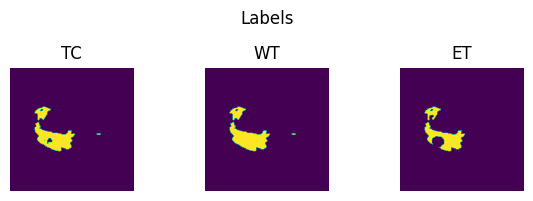

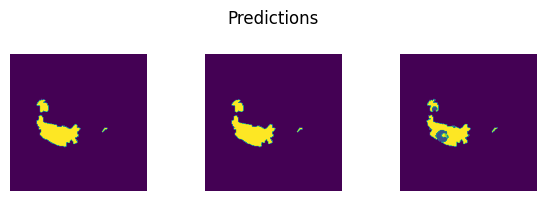

VAL
   Batch 1/31, val_loss: 0.7840
   Batch 2/31, val_loss: 0.8284
   Batch 3/31, val_loss: 0.9274
   Batch 4/31, val_loss: 0.9052
   Batch 5/31, val_loss: 0.9459
   Batch 6/31, val_loss: 0.6282
   Batch 7/31, val_loss: 0.7793
   Batch 8/31, val_loss: 0.9063
   Batch 9/31, val_loss: 0.6434
   Batch 10/31, val_loss: 0.8841
   Batch 11/31, val_loss: 0.6991
   Batch 12/31, val_loss: 0.9324
   Batch 13/31, val_loss: 0.8559
   Batch 14/31, val_loss: 0.9000
   Batch 15/31, val_loss: 0.9518
   Batch 16/31, val_loss: 0.8591
   Batch 17/31, val_loss: 0.9229
   Batch 18/31, val_loss: 0.8812
   Batch 19/31, val_loss: 0.6850
   Batch 20/31, val_loss: 0.8094
   Batch 21/31, val_loss: 0.9187
   Batch 22/31, val_loss: 0.9389
   Batch 23/31, val_loss: 0.9076
   Batch 24/31, val_loss: 0.6911
   Batch 25/31, val_loss: 0.6934
   Batch 26/31, val_loss: 0.8056
   Batch 27/31, val_loss: 0.9405
   Batch 28/31, val_loss: 0.7041
   Batch 29/31, val_loss: 0.9515
   Batch 30/31, val_loss: 0.9288
   Batch 31/31,

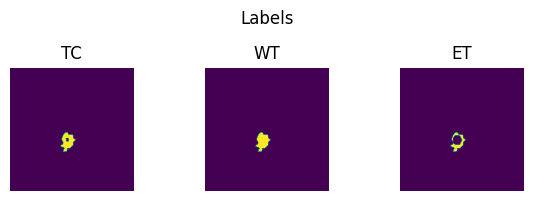

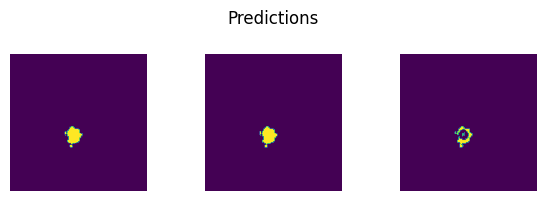

epoch 100
   average train loss: 0.2245
   average validation loss: 0.8429
   saved as best model: False
   current mean dice: 0.5332
   current TC dice: 0.5717
   current WT dice: 0.5727
   current ET dice: 0.4998
Best Mean Metric: 0.5454
time consuming of epoch 100 is: 1651.5616


In [12]:
total_start = time.time()
for epoch in range(init_epoch, max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # TRAINING
    model.train()
    epoch_loss = 0
    step = 0
    print('TRAIN')
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        # Batch Information
        print(f"   Batch {step}/{len(train_dataset) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}")

        # Store the image to plot
        if step == max_step:
          plt_imgs = [labels[0], transforms.post()(outputs[0])]

    # Epoch Training Loss
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Plot the Img
    if (epoch + 1) % plot_interval == 0:
      plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], True)

    # VALIDATION
    print('VAL')
    val_loss = 0
    val_step = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            best_val_dice = -1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_step += 1
                val_outputs = inference(val_inputs)
                loss_value = loss_function(val_outputs[0], val_labels[0])
                val_loss += loss_value.item()

                val_outputs = [transforms.post()(x) for x in val_outputs]

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                # Batch Information
                print(f"   Batch {val_step}/{len(val_dataset) // val_loader.batch_size}"
                      f", val_loss: {loss_value.item():.4f}")

                # Store plot image
                if val_step == max_val_step:
                  plt_imgs = [val_labels[0], val_outputs[0]]

            # Epoch Validation Loss
            val_loss /= val_step
            val_loss_values.append(val_loss)

            # Plot the img
            if (epoch + 1) % plot_interval == 0:
              plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], False)

            # Metric Calculation
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            # Save Last State
            torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch+1}.pth"),
            )

            # Remove previous state
            if epoch > 0:
                os.remove(
                      os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch}.pth")
                )

            # Update Best Metric
            if metric > best_metric:
                # Save best state
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                # Save best model
                torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/best_{model_name}_{epoch+1}.pth"),
                )
                # Remove previous best model
                if best_metric_update_epoch != -1:
                    os.remove(
                        os.path.join(f"outputs/{model_name}/best_{model_name}_{best_metric_update_epoch}.pth")
                    )
                # Update best epoch
                best_metric_update_epoch = epoch + 1
                best_metric_update = True

            # Save all metrics in csv
            with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
                f.write(f"{epoch + 1},{metric},{metric_tc},{metric_wt},{metric_et},{epoch_loss},{val_loss}\n")

    # REPORT
    print(f"epoch {epoch + 1}\n"
          f"   average train loss: {epoch_loss:.4f}\n"
          f"   average validation loss: {val_loss:.4f}\n"
          f"   saved as best model: {best_metric_update}\n"
          f"   current mean dice: {metric_values[-1]:.4f}\n"
          f"   current TC dice: {metric_values_tc[-1]:.4f}\n"
          f"   current WT dice: {metric_values_wt[-1]:.4f}\n"
          f"   current ET dice: {metric_values_et[-1]:.4f}")
    print(f"Best Mean Metric: {best_metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    best_metric_update = False

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

In [13]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.5454 at epoch: 92, total time: 83261.41735076904.
